In [1]:
# math tools
import numpy as np
import math

# file handling tools 
import os
import uproot
import pickle
import pickletools

# data handling tools
import copy
import time
import datetime 
import pytz
from   FV_class import toolbox
tb     = toolbox()# Define class object

# fitting tools
import scipy.optimize    as scipy
from   scipy.interpolate import interp1d
from   scipy.integrate   import quad
from   scipy.optimize    import curve_fit
from   scipy.special     import erf
from   scipy.signal      import find_peaks
from   scipy.stats       import skew
from   scipy.stats       import kurtosis
from   scipy.stats       import iqr
from   scipy.stats       import gaussian_kde
from   scipy.ndimage     import gaussian_filter1d
import seaborn           as sns

# plotting tools
import matplotlib
import matplotlib.pyplot     as plt
from   matplotlib            import colors
from   matplotlib.ticker     import ScalarFormatter
from   matplotlib.path       import Path
from   matplotlib.patches    import Ellipse
import matplotlib.transforms as transforms
from   functools             import partial

# LZStyle file:
if None != os.getenv('NERSC_HOST'):
    import matplotlib.font_manager as font_manager
    font_manager.fontManager.addfont('/global/cfs/cdirs/lz/physics/WS/SR1/msttcorefonts/Times_New_Roman.ttf')
plt.style.use('/global/cfs/cdirs/lz/users/dkodroff/LZStyle/SetLZStyle.mplstyle')
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'

import sys
print(sys.version)
import scipy
print(scipy.__version__)


/cvmfs/lz.opensciencegrid.org/external/Python/3.8.9_CI/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


3.8.9 (default, May 21 2021, 08:55:19) 
[GCC 8.2.0]
1.4.1


# Initial Functions

In [2]:
def get_list_shape(lst):
    
    list_shape = []
    
    for x in range(len(lst)):
        y = len(lst[x])
        
        list_shape.append(y)
        
    return list_shape


In [3]:
# get shapes and dtypes of list of variables

def get_shapes_and_dtypes(var_list, var_str_list, show_dtype=True, show_shape=True):
    """
    ______________________________________________________
    FUNC INFO:
    (list) var_list:     list of variables and their data 
    (list) var_str_list: list of strings of var names
    ______________________________________________________
    RETURNS:
    -NONE-
    ______________________________________________________
    PRINTS:
    * the data type of each list element
    * the dimensions of each list element
    ______________________________________________________
    """
    
    print()
    
    for var, var_str in zip(var_list, var_str_list):
        
        if show_dtype and show_shape:
        
            # print the data type of each list element
            print(f"type({var_str}) = {type(var)}")
            
            # print the dimensions of each list element
            # arrays
            if isinstance(var, np.ndarray):
                print(f"dim({var_str})  = {var.shape}")
            # lists
            elif isinstance(var, list):
                list_shape = get_list_shape(var)
                print(f"dim({var_str})  = ({len(var)}, {list_shape})")
            # neither array nor list
            else:
                print(f"dim({var_str})  = Not an array or list")
        
            print(f"__________")
            print()
        
        elif show_dtype and not show_shape:
            
            # print the data type of each list element
            print(f"type({var_str}) = {type(var)}")
            
        elif show_shape and not show_dtype:
            
            # print the dimensions of each list element
            # arrays
            if isinstance(var, np.ndarray):
                print(f"dim({var_str})  = {var.shape}")
            # lists
            elif isinstance(var, list):
                list_shape = get_list_shape(var)
                print(f"dim({var_str})  = ({len(var)}, {list_shape})")
            # neither array nor list
            else:
                print(f"dim({var_str})  = Not an array or list")
    
    print()
    

In [4]:
# "Decorator" to show the elapsed time of a function

# establish eastern time for timer later
est = pytz.timezone('America/New_York')

def function_timer(func):
    """
    Methods to call:
    _____________________________________________________
    1. Define functions that always use timer as
    
             @function_timer
             def some_function(a, b):
    _____________________________________________________   
    2. Define functions not to always use timer normally 
       and call the timer when wanted by doing
             
             function_timer(some_function)(a, b)
    _____________________________________________________
    """
    def wrapper(*args, **kwargs):
        
        # declare and print starting time 
        start_time     = time.time()
        start_time_utc = datetime.datetime.fromtimestamp(start_time, pytz.utc)
        start_time_est = start_time_utc.astimezone(est)
        print(f"START: {start_time_est.strftime('%Y-%m-%d %H:%M:%S %Z%z')}")
    
        try:
            # run the function
            result = func(*args, **kwargs)
        except Exception as e:
            end_time = time.time()
            end_time_utc = datetime.datetime.fromtimestamp(end_time, pytz.utc)
            end_time_est = end_time_utc.astimezone(pytz.timezone('America/New_York'))
            print(f"END:   {end_time_est.strftime('%Y-%m-%d %H:%M:%S %Z%z')}")
            raise e
        else:
            # declare and print end time
            end_time       = time.time()
            end_time_utc   = datetime.datetime.fromtimestamp(end_time, pytz.utc)
            end_time_est   = end_time_utc.astimezone(pytz.timezone('America/New_York'))
            print(f"END:   {end_time_est.strftime('%Y-%m-%d %H:%M:%S %Z%z')}")

        # find and print elapsed time
        elapsed_time     = end_time - start_time
        hours, remainder = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        print()
        print(f"RUNTIME: {int(hours):02} hrs, {int(minutes):02} mins, {seconds:05.2f} secs")
        print()
        return result if result is not None else None

    
    return wrapper


In [5]:

def get_num_sigmas_away_from_peak(amp_height, target_height):
    
    ratio         = target_height / amp_height    
    sigmas        = np.arange(0.0, 15.0, 0.01)
    gauss_amp     = f_gaussian_val((sigmas), 1, 0, 1)
    
    if (amp_height - target_height) < amp_height * (gauss_amp[0] - gauss_amp[1]):
        index_before = [0]
    else:
        index_before = np.where((gauss_amp[:-1] >= ratio) & (gauss_amp[1:] <= ratio))[0]
    
    index_between = [[index, index + 1] for index in index_before][0]
    num_sigmas    = np.mean(sigmas[index_between])
    
    return num_sigmas


In [6]:
def find_max_min_index_from_data_subset(data_arr_x, data_arr_y, rel_index=None, rel_val=None, cond='>'):
    """
    Finds the indices of elements in data_arr_x that satisfy a condition relative to a value in data_arr1 at the specified index.
    Also performs a specified search operation on data_arr_y within the subset.

    Parameters:
    - data_arr_x: numpy array, the main array to search through.
    - data_arr_y: numpy array, the second array to use for additional operations (e.g., getting max values).
    - rel_index:  int, the index of the value in data_arr_x to compare against.
    - cond:       str, the condition to use for comparison ('>', '<', '>=', '<=').

    Returns:
    - numpy array: Indices of elements in data_arr_x that satisfy the condition.
    - int:         Index of the value in data_arr_y within the subset satisfying the condition based on the search operation.
    """
    if rel_index:
        rel_val = data_arr_x[rel_index]
    elif rel_val:
        rel_val = rel_val
    else:
        print(f"No rel_index or rel_val provided.")
    
    if   cond == '>':
        passes_cond_mask = data_arr_x > rel_val
    elif cond == '<':
        passes_cond_mask = data_arr_x < rel_val
    elif cond == '>=':
        passes_cond_mask = data_arr_x >= rel_val
    elif cond == '<=':
        passes_cond_mask = data_arr_x <= rel_val
    else:
        raise ValueError(f"Unsupported condition: {cond}")
    
    # get passing indices
    passes_cond_indices = np.where(passes_cond_mask)[0]
    
    # Indices pass the condition
    if len(passes_cond_indices) > 0:
        
        # get subset
        subset_data_arr_y = data_arr_y[passes_cond_indices]
        
        # find indices within subset
        max_index_masked = np.argmax(subset_data_arr_y)
        min_index_masked = np.argmin(subset_data_arr_y)
        
        # find indices of the whole array
        max_index        = passes_cond_indices[max_index_masked]
        min_index        = passes_cond_indices[min_index_masked]
    
    # No indices pass the condition
    else:
        max_index = None  
        min_index = None
    
    return passes_cond_indices, max_index, min_index

In [7]:
def f_gaussian_val(x, A, mu, sig):
    
    gaussian_val = A * np.exp(- (x - mu)**2 / (2 * sig**2))
    
    return gaussian_val

In [8]:


# def get_num_sigmas_before_peak(amp_height, target_height):
    
#     sigmas        = np.arange(0.0, 15.0, 0.01)
#     gauss_amp     = f_gaussian_val((sigmas), 1, 0, 1)
#     ratio         = target_height / amp_height
#     # index_before  = np.where((gauss_amp[:-1] >= ratio) & (gauss_amp[1:] <= ratio))[0]
#     if np.abs((amp_height - target_height)) < gauss_amp[np.argmax(gauss_amp) - 1]:
#         index_before = [0]
#     else:
#         index_before = np.where((gauss_amp[:-1] >= ratio) & (gauss_amp[1:] <= ratio))[0]
#     index_between = [[index, index + 1] for index in index_before][0]
#     num_sigmas    = np.mean(sigmas[index_between])
    
#     return num_sigmas


In [9]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they 
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    stddev = math.sqrt(variance)
    return average, stddev

In [10]:


def find_max_min_index_from_data_subset(data_arr_x, data_arr_y, rel_index=None, rel_val=None, cond='>'):
    """
    Finds the indices of elements in data_arr1 that satisfy a condition relative to a value in data_arr1 at the specified index.
    Also performs a specified search operation on data_arr2 within the subset.

    Parameters:
    - data_arr_x: numpy array, the main array to search through.
    - data_arr_y: numpy array, the second array to use for additional operations (e.g., getting max values).
    - rel_index: int, the index of the value in data_arr_x to compare against.
    - cond: str, the condition to use for comparison ('>', '<', '>=', '<=').

    Returns:
    - numpy array: Indices of elements in data_arr1 that satisfy the condition.
    - int: Index of the value in data_arr2 within the subset satisfying the condition based on the search operation.
    """
    
    rel_val  = data_arr_x[rel_index] if rel_index else rel_val
    
    if   cond == '>':
        passes_cond_mask = data_arr_x > rel_val
    elif cond == '<':
        passes_cond_mask = data_arr_x < rel_val
    elif cond == '>=':
        passes_cond_mask = data_arr_x >= rel_val
    elif cond == '<=':
        passes_cond_mask = data_arr_x <= rel_val
    else:
        raise ValueError(f"Unsupported condition: {cond}")
    
    # get passing indices
    passes_cond_indices = np.where(passes_cond_mask)[0]
    
    # Indices pass the condition
    if len(passes_cond_indices) > 0:
        
        # get subset
        subset_data_arr_y = data_arr_y[passes_cond_indices]
        
        # find indices within subset
        max_index_masked = np.argmax(subset_data_arr_y)
        min_index_masked = np.argmin(subset_data_arr_y)
        
        # find indices of the whole array
        max_index        = passes_cond_indices[max_index_masked]
        min_index        = passes_cond_indices[min_index_masked]
    
    # No indices pass the condition
    else:
        max_index = None  
        min_index = None
    
    return passes_cond_indices, max_index, min_index

## Ellipse

In [11]:
# define graphical cut 

def graphical_cut(x, y, polygon):
    
    """
    For a given set of (x, y) points, returns a mask
    that applies a graphical cut such that only points
    within the constructed polygon are selected. 
    The polygon should be in the form: [(x1, y1), (x2, y2), ...]
    """
    # # ---------------------------------------------------
    # # below is from chatgpt
    # # Ensure that the polygon has the correct shape
    # if len(polygon.shape) == 1:
    #     polygon = polygon.reshape(-1, 2)
    # # ---------------------------------------------------
    
    # Join datapoints together
    points = np.vstack((x, y)).T 
    
    # Construct polygon and produce mask
    p = Path(polygon)
    mask = p.contains_points(points)
    
    return mask


In [12]:
# define a confidence ellipse function 

def confidence_ellipse(x, y, ax, n_std, facecolor = 'none', **kwargs):

        """
        Based on function from:
        https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
        - Create a plot of the covariance confidence ellipse of *x* and *y*.
        ________________________________________________________________________________
        Parameters
        ----------
        x, y  : array-like, shape (n, )
                - Input data.
        ax    : matplotlib.axes.Axes
                - The Axes object to draw the ellipse into.
        n_std : float
                - The number of standard deviations to determine the ellipse's radiuses.
        **kwargs
            Forwarded to `~matplotlib.patches.Ellipse`
        Returns
        -------
        matplotlib.patches.Ellipse
        ________________________________________________________________________________

        Plots a confidence ellipse for a 2D Gaussian, and returns the mean (x, y)
        with associated standard errors. Also returns the ellipse as a polygon
        to be used for elliptical cuts.
        """

        # Calculate covariance matrix and pearson coefficient
        cov     = np.cov(x, y)
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

        # Using a special case to obtain the eigenvalues of 2D dataset
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse      = Ellipse((0, 0), width = ell_radius_x * 2, height = ell_radius_y * 2,
                       facecolor = "none", **kwargs)

        # Calculating n_stdevs by square-rooting covariance matrix diagonals
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x  = np.mean(x)
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y  = np.mean(y)
        n_samples = len(x)

        # For non-plotted version
        if (ax == None):
            return 0, mean_x, mean_y, scale_x, scale_y

        # With plots
        else:
            # Create and add contour ellipse
            transf = transforms.Affine2D() \
                    .rotate_deg(45) \
                    .scale(scale_x, scale_y) \
                    .translate(mean_x, mean_y)
            ellipse.set_transform(transf + ax.transData)
            ell_poly = ax.transData.inverted().transform(ellipse.get_verts())
            return ax.add_patch(ellipse), mean_x, mean_y, scale_x, scale_y, ell_poly


In [13]:
# define function to fit data to confidence ellipse function

def fit_pop_ellipse(S1s, S2s, cuts, poly, nbins=150, show_plot=True, draw_poly=False,
                        bin_range=((100, 1e3),(10**2.5, 1e5)), figsize=(6, 4), overlay=None,
                        logz=False, save_str=None, ret_fit=False, flag=False):

        """
        Plots a 2D histogram of S2c vs. S1c, and fits elliptical contours
        to a population specified by a given polygon, with supplied cuts
        applied. Returns a 2-sigma elliptical cut for the population.
        Additional options allow for drawing the original graphical cut, or
        overlaying the elliptical fit of different data.
        """
        
        # create histogram that will do fit without being plotted
        hist = np.histogram2d(S1s[cuts], S2s[cuts], bins = nbins, range = bin_range)
        
        # If overlay is specified
        (S1ov, S2ov, cutsov) = overlay if overlay != None else (S1s, S2s, cuts)

        # Define rough graphical cut
        popcut = graphical_cut(S1ov, S2ov, poly)
        
        # set up subplots
        fig, ax = plt.subplots(figsize = figsize)
        
        if show_plot:
            
            # Fit 2D Gaussian to selected population
            h = ax.hist2d(S1s[cuts], S2s[cuts], bins = nbins, range = bin_range, cmin = 1,
                          norm = mplc.LogNorm() if logz else None)
            cb = fig.colorbar(h[3])
            
            # Fit and plot Gaussian contours
            confidence_ellipse(S1ov[cutsov & popcut], S2ov[cutsov & popcut], ax, 1, edgecolor = "r")
            fit = confidence_ellipse(S1ov[cutsov & popcut], S2ov[cutsov & popcut], ax, 2, edgecolor = "r")
            ax.plot(fit[1], fit[2], 'r.') # Draw mean as a point
            
            # Draw polygon if specified
            if draw_poly:
                ax.plot(np.array(poly[:, 0]), np.array(poly[:, 1]), "r--")

            # Formatting
            plt.ticklabel_format(axis = "both", style = "sci", scilimits = (0,0), useMathText = True)
            plt.xlabel(r"S1$_{\mathdefault{c}}$ [phd]")
            plt.ylabel(r"S2$_{\mathdefault{c}}$ [phd]")
            cb.set_label(f"SS counts - {len(S1ov[cutsov & popcut])} total")
            if save_str != None:
                plt.savefig("output/{:s}.png".format(save_str), dpi = 300, bbox_inches = 'tight')
            plt.show()
            
            # print(f"if true: fit = {fit}")
            
        else:
            # Fit Gaussian contours
            fit = confidence_ellipse(S1ov[cutsov & popcut], S2ov[cutsov & popcut], None if ax is None else ax, n_std = 2)
            
            # Clear the plot
            ax.clear()
            plt.close(fig)
            
        # Return 2-sigma elliptical cut and fit together if specified
        if ret_fit:
            
            if flag == True:
                print(f"graphical_cut(S1s, S2s, fit[-1]) = {graphical_cut(S1s, S2s, fit[-1])}")
                print()
                print(f"fit = {fit}")
                print()
            return graphical_cut(S1s, S2s, fit[-1]), fit
        
        # Otherwise return 2-sigma elliptical cut only
        else: 
            if flag == True:
                print(f"graphical_cut(S1s, S2s, fit[-1]) = {graphical_cut(S1s, S2s, fit[-1])}")
                print()
            return graphical_cut(S1s, S2s, fit[-1])
        

## Get Single $(t_{cal},t_{drift})$ Slice

In [14]:
# define polygon shape 
polygon_main = [ (0.75e3,1.82e5), (0.94e3,1.5e5), (1.05e3,1.2e5), (1.1e3,0.8e5), (0.98e3,0.97e5), (0.845e3,1.28e5), (0.75e3,1.82e5) ]


def get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                    calT_int_dict, dT_slice_dict,\
                                                    calT_index, dT_index, \
                                                    poly=polygon_main, \
                                                    plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                    show_ellipse_plots=False, \
                                                    flag=False):
    # __________________________________________________________________________________
    """
    select a single calendar time interval 
    """
    
    # unpack calendar time interval dictionary
    calT_mask, calT_title_string, calT_span = calT_int_dict[calT_index]
    
    # apply calT_mask (work with one calT_index)
    rqs_dict_calT_int = apply_mask_to_dict(rqs_dict, calT_mask)
    
    # unpack rqs dictionary (one calendar time)
    s1c_phd = rqs_dict_calT_int['s1c_phd']
    s2c_phd = rqs_dict_calT_int['s2c_phd']
    cuts    = rqs_dict_calT_int['cuts']
    
    # exclude empty time periods
    if len(s1c_phd) == 0:
        
        # make return value empty array
        r2_vals_one_calT_onedT = [] # *** changed from [0] ***
        
        if flag == True:
            print(f"calT_index[{calT_index}] is empty")
        
    else:
        if flag == True:
            print(f"calT_index[{calT_index}]")
        # __________________________________________________________________________________
        """
        create and apply 2 sigma elliptical mask 
        """

        # whether to show the ellipse plot generated by creating 2 sigma mask 
        make_ell_plot = True if show_ellipse_plots else False 

        # create the 2 sigma elliptical mask
        ellipse_mask   = fit_pop_ellipse(s1c_phd, s2c_phd, cuts, poly, \
                                         show_plot = make_ell_plot, nbins=100, \
                                         bin_range = plot_range_ellipse)

        # apply ell_mask (work with tight fit around source signal)
        rqs_dict_calT_int_2sigma_sel = apply_mask_to_dict(rqs_dict_calT_int, ellipse_mask)

        # unpack rqs dictionary (one calendar time interval with elliptical selection)
        dT_vals = rqs_dict_calT_int_2sigma_sel['dT_us']
        r2_vals = rqs_dict_calT_int_2sigma_sel['r2_cm2']

        # __________________________________________________________________________________
        """
        select a single drift time interval 
        """

        # unpack drift time dictionary
        dT_i = dT_slice_dict['dT_i']
        dT_f = dT_slice_dict['dT_f']

        # create mask to select single drift time slice
        dT_mask = ( dT_vals >= dT_i[dT_index] ) & ( dT_vals < dT_f[dT_index] )

        # apply dT_mask to r2_vals to select single drift time slice
        r2_vals_one_calT_onedT = r2_vals[dT_mask]

        # __________________________________________________________________________________
    
    return r2_vals_one_calT_onedT
    

In [15]:
@function_timer
def get_counts_vs_r2_values_for_all_calT_all_dT_slices(rqs_dict, 
                                                       calT_int_dict, dT_slice_dict,
                                                       poly = polygon_main, 
                                                       flag = True, dT_flag = False):
    
    # create empty r2_events list (all calT, all dT)
    r2_events = []
    
    # get numbers of slices to iterate over
    calT_tot_num_slices = len(calT_int_dict)
    dT_tot_num_slices   = len(dT_slice_dict['dT_mid'])
    
    # iterate over the length of calT_int_dict (25 calT slices)
    for calT in range(calT_tot_num_slices):
        
        if flag:
            print()
            print(f"calT[{calT}] - STARTING")
            print()
        
        # create empty r2_events_one_calT_all_dT list (1 calT, all dT)
        r2_events_one_calT_all_dT = []
        
        # iterate over the length of dT_mid (36 dT slices)
        for dT in range(dT_tot_num_slices):
            
            # get events for one calendar time and one drift time (1 calT, 1 dT)
            r2_events_one_calT_one_dT = \
                get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                                calT_int_dict, dT_slice_dict,\
                                                                calT_index = calT, dT_index = dT, \
                                                                poly = poly)
            
            # add (1 calT, 1 dT) events to (1 calT, all dT) list
            r2_events_one_calT_all_dT.append(r2_events_one_calT_one_dT)
            
            # calculate the indices for 25%, 50%, and 75% progress
            progress_indices = [int(dT_tot_num_slices * 0.25), \
                                int(dT_tot_num_slices * 0.5), \
                                int(dT_tot_num_slices * 0.75)]
            
            if flag and dT in progress_indices and not dT_flag:
                print(f"calT[{calT}] - {(progress_indices.index(dT) + 1) * 25}% ")
                
            if flag and dT_flag:
                if dT < 10:
                    print(f"   ~ dT[0{dT}] ~   ")
                else:
                    print(f"   ~ dT[{dT}] ~   ")
                
        # add (1 calT, all dT) events to (all calT, all dT) list
        r2_events.append(r2_events_one_calT_all_dT)
        
        if flag:
            print()
            print(f"calT[{calT}] - COMPLETED")
            print()
            print(f"--------------------")
            
    return r2_events
            

## Data Handling

In [16]:
# Function to load data from a pickle file and display it

def load_and_display_data(file_name, flag=False):
    """
    ____________________________________________________________________________________________
    FUNC INFO:
    (string) file_name: the path of the file from the location where this function is called 
                        e.g. 'file_name.pickle' OR 'subfolder/file_name.pickle'
                        
    (bool)   flag:      DEFAULT False, set True to view the objects stored in the files
    ____________________________________________________________________________________________
    USAGE:
    * To use for one file:
        loaded_data      = load_and_display_data('file_name_path')
        
    * To use for list of files: 
        file_names       = ['file_name1_path', 'file_name2_path', 'file_name3_path', ...]
        loaded_data_list = [load_and_display_data(file_name) for file_name in file_names] 
    ____________________________________________________________________________________________
    """
    
    
    with open(file_name, 'rb') as file:
        
        loaded_data = pickle.load(file)
        
        if flag == True:
            
            var_names = list(loaded_data.keys())
            print()
            print(f"Loaded Data from {file_name}:")
            print()
            for var_name in var_names:
                print(f"- {var_name}")
            print()
            
    return loaded_data

In [17]:
# define function that retrieves variable names from list of variables

def get_var_name(var):
    for name, value in globals().items():
        if value is var:
            return name 

In [18]:
# define function to print dictionary keys

def print_keys(var_dict):
    
    # get name of var_dict
    var_dict_name = get_var_name(var_dict)
    print(f"variables in dictionary: {var_dict_name}")
    print()
    for key in var_dict.keys():
        print(key)
    

In [19]:
# define function to take an input dictionary, apply mask to it, return an output dictionary

def apply_mask_to_dict(input_dict, mask, remove_suffix=None, add_suffix=None, flag=False):
    
    # create blank dictionary
    new_dict = {}
    
    for name, value in input_dict.items():
        
        if flag == True:
            print(f"{name} = {value}")
            
        # apply mask to each variable in input_dict
        new_value = value[mask]
        
        # remove suffix if remove_suffix is specified 
        if remove_suffix:
            name = name.replace(remove_suffix, "")
        
        # add suffix if add_suffix is specified
        if add_suffix:
            new_name = name + add_suffix
        
        else:
            new_name = name 
            
        # fill new_dict with new names and their corresponding new values
        new_dict[new_name] = new_value 
        
    return new_dict

In [20]:
def f_gaussian_val(x, A, mu, sig):
    
    gaussian_val = A * np.exp(- (x - mu)**2 / (2 * sig**2))
    
    return gaussian_val

# Import Data 

In [21]:
# """
# RQs Variable Dictionaries
# """

# # open pickle file

# # get data 
# file_names0 = ['pickle-files/SR3LENR_WS_finalVersion_Xe131m_rqs-dict.pickle', 
#                'pickle-files/SR3LENR_WS_finalVersion_Xe131m_rqs-dict-post-cuts.pickle', 
#                'pickle-files/SR3LENR_WS_finalVersion_Xe131m_rqs-dict-2sigma.pickle']
# print(f"_____________________________________________________________________________")

# loaded_data_list0 = [load_and_display_data(file_name, flag=True) for file_name in file_names0] 


# # get dictionaries from pickle files 

# # dictionary of rqs - no cuts
# rqs_dict = loaded_data_list0[0]

# # dictionary of rqs - rough cuts only
# rqs_dict_post_cuts = loaded_data_list0[1]

# # dictionary of rqs - elliptical selection for all calendar times together
# rqs_dict_2sigma  = loaded_data_list0[2]

# print(f"_____________________________________________________________________________")
# print()

# """
# Calendar Time and Drift Time Slice Information
# """

# # get data 
# file_names1 = ['pickle-files/SR3LENR_WS_finalVersion_Xe131m_calT-int-dict.pickle', 
#                'pickle-files/SR3LENR_WS_finalVersion_Xe131m_dT-slice-dict.pickle']

# loaded_data_list1 = [load_and_display_data(file_name, flag=False) for file_name in file_names1] 

# # Access loaded dictionaries
# calT_int_dict = loaded_data_list1[0]
# dT_slice_dict = loaded_data_list1[1]

# # print calT_dict info
# print(f"variables in dictionary: calT_int_dict")
# print()
# print(f"each interval (index = (0 - {len(calT_int_dict) - 1})) contains variables:")
# print(f"    calT_int_dict[i] =  calT_mask, calT_title_string, calT_span")
# print(f"_____________________________________________________________________________")

# # print dT_slice_dict info
# print()
# print_keys(dT_slice_dict)

# """
# R2 Events - each slice data 
# """
 
# r2_events_file = 'pickle-files/SR3LENR_WS_finalVersion_Xe131m_EllSel_AND_Cuts_r2_events_calT_dT_slices.pickle'
# r2_events      = load_and_display_data(r2_events_file) 


# # Print shape of result
# print(f"_____________________________________________________________________________")
# print()
# print(f"Shape of r2_events: ({len(r2_events)}, {len(r2_events[1])}, varying number of events)")
# print(f"_____________________________________________________________________________")


In [22]:
"""
RQs Variable Dictionaries
"""

# open pickle file

# get data 
file_names0 = ['pickle-files/SR3_WS_data_2024_Sept_Xe131m-rqs-dict.pickle', 
               'pickle-files/SR3_WS_data_2024_Sept_Xe131m-rqs-dict-post-cuts.pickle', 
               'pickle-files/SR3_WS_data_2024_Sept_Xe131m-rqs-dict-2sigma.pickle']
print(f"_____________________________________________________________________________")

loaded_data_list0 = [load_and_display_data(file_name, flag=True) for file_name in file_names0] 


# get dictionaries from pickle files 

# dictionary of rqs - no cuts
rqs_dict = loaded_data_list0[0]

# dictionary of rqs - rough cuts only
rqs_dict_post_cuts = loaded_data_list0[1]

# dictionary of rqs - elliptical selection for all calendar times together
rqs_dict_2sigma  = loaded_data_list0[2]

print(f"_____________________________________________________________________________")
print()

"""
Calendar Time and Drift Time Slice Information
"""

# get data 
file_names1 = ['pickle-files/SR3_WS_data_2024_Sept_Xe131m-calT-int-dict.pickle', 
               'pickle-files/SR3_WS_data_2024_Sept_Xe131m-dT-slice-dict.pickle']

loaded_data_list1 = [load_and_display_data(file_name, flag=False) for file_name in file_names1] 

# Access loaded dictionaries
calT_int_dict = loaded_data_list1[0]
dT_slice_dict = loaded_data_list1[1]

# print calT_dict info
print(f"variables in dictionary: calT_int_dict")
print()
print(f"each interval (index = (0 - {len(calT_int_dict) - 1})) contains variables:")
print(f"    calT_int_dict[i] =  calT_mask, calT_title_string, calT_span")
print(f"_____________________________________________________________________________")

# print dT_slice_dict info
print()
print_keys(dT_slice_dict)

"""
R2 Events - each slice data 
"""
 
r2_events_file = 'pickle-files/SR3_WS_data_2024_Sept_Xe131m-rqs_dict_2sigma_slices.pickle'
r2_events_dict = load_and_display_data(r2_events_file, flag=True) 
r2_events      = r2_events_dict['r2_cm2']


# # Print shape of result
# print(f"_____________________________________________________________________________")
# print()
# print(f"Shape of r2_events: ({len(r2_events)}, {len(r2_events[1])}, varying number of events)")
# print(f"_____________________________________________________________________________")


_____________________________________________________________________________

Loaded Data from pickle-files/SR3_WS_data_2024_Sept_Xe131m-rqs-dict.pickle:

- dT_us
- s1c_phd
- s2c_phd
- x_cm
- y_cm
- r2_cm2
- cuts


Loaded Data from pickle-files/SR3_WS_data_2024_Sept_Xe131m-rqs-dict-post-cuts.pickle:

- dT_us
- r2_cm2


Loaded Data from pickle-files/SR3_WS_data_2024_Sept_Xe131m-rqs-dict-2sigma.pickle:

- dT_us
- r2_cm2

_____________________________________________________________________________

variables in dictionary: calT_int_dict

each interval (index = (0 - 24)) contains variables:
    calT_int_dict[i] =  calT_mask, calT_title_string, calT_span
_____________________________________________________________________________

variables in dictionary: dT_slice_dict

dT_i
dT_f
dT_mid

Loaded Data from pickle-files/SR3_WS_data_2024_Sept_Xe131m-rqs_dict_2sigma_slices.pickle:

- dT_us
- s1c_phd
- s2c_phd
- x_cm
- y_cm
- r2_cm2
- r_cm
- cuts
- ell_mask



In [23]:
# # get percentage of how many events are in each calT interval

# # get calT interval spectra
# dT_vs_r2_spectra_file = 'pickle-files/SR3LENR_WS_aprilVersion_Xe131m_dT-vs-r2-spectra-dict.pickle'
# dT_vs_r2_spectra_dict = load_and_display_data(dT_vs_r2_spectra_file, flag=False)

# # get events in each calT int
# r2_spectra_cal_ints = dT_vs_r2_spectra_dict['r2_spectra_cal_ints']
# r2_spectra_cal_ints = [r2_spectra_cal_ints[i] for i in range(len(r2_spectra_cal_ints))]

# r2_spectra_cal_ints.shape
# # empty list for num events in each calT
# num_events_EACH_calT = []

# for i in r2_spectra_cal_ints:
#     # len of each r2 spect
#     num_events_ONE_calT = len(r2_spectra_cal_ints[i])
#     num_events_EACH_calT.append(num_events_ONE_calT)

# print(f"num_events_EACH_calT = {num_events_EACH_calT}")

# print(f"Number of events in each calendar time interval")
# print()
# for i in num_events_EACH_calT:
    
#     # reformat n_tot for labeling 
#     n_tot          = "{:.2e}".format(round(num_events_EACH_calT[i],2))
#     base, exponent = n_tot.split("e")
#     n_tot          = f"${base} \\times {{10}}^{int(exponent)}$"
    
#     if calT_index < 10:
#         print(f"calT[{i}]:  {n_tot}")
#     else:
#         print(f"calT[{i}]: {n_tot}")

# print()


# # get total number of events
# tot_num_events_ALL_calT = len(rqs_dict['r2_cm2'])
# print(f"tot_num_events_all_calT = {tot_num_events_all_calT}")



# Functions

## Crystal Ball

### Fit Function

In [24]:
def f_crystal_ball(x, alpha, n, xbar, sigma):
    """
    piecewise function  
    with modications to crystal ball function to add a constant to the power series piece
    """
    
    # value shortcuts
    abs_alpha    = np.abs(alpha)
    n_over_alpha = n / abs_alpha
    exp          = np.exp(- abs_alpha**2 / 2)

    # constants 
    A = n_over_alpha**n * exp
    B = n_over_alpha - abs_alpha
    C = n_over_alpha * (1 / (n - 1)) * exp if n != 1 else np.inf
    D = np.sqrt(np.pi / 2) * (1 + erf(abs_alpha / np.sqrt(2)))
    N = 1 / (sigma * (C + D))
    
    # define value of the split of the piecewise function
    split_val = (x - xbar) / sigma
    mask      = split_val > -alpha
    
    # define function pieces
    gauss_exp     = - (x[mask] - xbar)**2 / (2 * sigma**2)
    gaussian      = N * np.exp(gauss_exp)
    powerLaw_base = B - (x[~mask] - xbar) / sigma
    powerLaw      = N * A * powerLaw_base**(-n)
    
    # get result
    crystal_ball        = np.zeros_like(x)
    crystal_ball[~mask] = powerLaw
    crystal_ball[mask]  = gaussian
    
    return crystal_ball
    
#     return crystal_ball, mask

# def f_crystal_ball_fit(x, alpha, n, xbar, sigma):
#     """
#     only return the fit itself 
#     """
#     crystal_ball, _ = f_crystal_ball(x, alpha, n, xbar, sigma)
    
#     return crystal_ball

### Error Propagation

In [25]:
def get_crystal_ball_partial_derivs_wrt_params(x, alpha, n, xbar, sigma, constant):
    """
    get partial derivatives for error propagation
    """
    
    # value shortcuts
    abs_alpha    = np.abs(alpha)
    n_over_alpha = n / abs_alpha
    exp          = np.exp(- abs_alpha**2 / 2)

    # constants 
    A = n_over_alpha**n * exp
    B = n_over_alpha - abs_alpha
    C = n_over_alpha * (1 / (n - 1)) * exp
    D = np.sqrt(np.pi / 2) * (1 + erf(abs_alpha / np.sqrt(2)))
    N = 1 / (sigma * (C + D))
    
    # define value of the split of the piecewise function
    split_val = (x - xbar) / sigma
    mask      = split_val > -alpha
    
    # define partials of A wrt parameters [n, alpha]
    dA_dn     = n_over_alpha**n * (1 + np.log(n_over_alpha))
    dA_dalpha = - ((1 / abs_alpha**2) + n_over_alpha) * n_over_alpha**(n-1) * exp * np.sign(alpha)
    
    # define partials of B wrt parameters [n, alpha]
    dB_dn     = (1 / abs_alpha) - abs_alpha
    dB_dalpha = - ((n / abs_alpha**2) + 1) * np.sign(alpha)
    
    # define partials of C wrt parameters [n, alpha]
    dC_dn     = ((1 / abs_alpha) * (1 / (n - 1)) - n_over_alpha * (1 / (n - 1)**2)) * exp
    dC_dalpha = - ((1 / abs_alpha**2) + 1) * (n * np.sign(alpha) * exp / (n - 1))
             
    # define partials of D wrt parameters [n, alpha]
    dD_dn     = 0
    dD_dalpha = 2 * exp
    
    # define partial of N wrt parameters [n, alpha, sigma]
    dN_dC     = - (1 / sigma) * (C + D)**(-2)
    dN_dD     = - (1 / sigma) * (C + D)**(-2)
    dN_dn     = dN_dC * dC_dn + dN_dD * dD_dn
    dN_dalpha = dN_dC * dC_dalpha + dN_dD * dD_dalpha 
    dN_dsigma = - 1 / (sigma**2 * (C + D)) 
    
    # define partials of gaussian wrt parameters
    exp_gauss        = np.exp( (x[mask] - xbar)**2 / (2 * sigma**2) )
    gaussian         = N * exp_gauss
    dGaussian_dN     = exp_gauss  
    dGaussian_dxbar  = - N * ( exp_gauss * (x[mask] - xbar) / sigma**2 )
    dGaussian_dsigma = N * ( exp_gauss * (x[mask] - xbar)**2 / sigma**3 ) + dGaussian_dN * dN_dsigma 
    dGaussian_dn     = dGaussian_dN * dN_dn
    dGaussian_dalpha = dGaussian_dN * dN_dalpha
    
    # define partials of power law wrt parameters
    powerLaw_parenth = B - (x[~mask] - xbar) / sigma
    powerLaw_notN    = A * powerLaw_parenth**(- n)
    powerLaw         = N * powerLaw_notN
    dPowerLaw_dN     = powerLaw_notN 
    dPowerLaw_dA     = N * powerLaw_parenth**(- n)
    dPowerLaw_dB     = N * A * (-n) * powerLaw_parenth**(- n - 1)
    dPowerLaw_dxbar  = N * A * (-n) * powerLaw_parenth**(- n - 1) * (-1 / sigma)
    dPowerLaw_dsigma = N * A * (-n) * powerLaw_parenth**(- n - 1) * ((x[~mask] - xbar) / sigma**2) + dPowerLaw_dN * dN_dsigma
    dPowerLaw_dn     = dPowerLaw_dN * dN_dn + dPowerLaw_dA * dA_dn \
                       + dPowerLaw_dB * dB_dn \
                       - N * A * np.log(powerLaw_parenth) / powerLaw_parenth**n
    dPowerLaw_dalpha = dPowerLaw_dN * dN_dalpha + dPowerLaw_dA * dA_dalpha + dPowerLaw_dB * dB_dalpha 
    
    # initialize empty lists of parameters the length of the input data 
    dCrystalBall_dalpha    = np.zeros_like(x)
    dCrystalBall_dn        = np.zeros_like(x)
    dCrystalBall_dxbar     = np.zeros_like(x)
    dCrystalBall_dsigma    = np.zeros_like(x)
    
    # fill gaussian bit with partials
    dCrystalBall_dalpha[mask]     = dGaussian_dalpha
    dCrystalBall_dn[mask]         = dGaussian_dn
    dCrystalBall_dxbar[mask]      = dGaussian_dxbar
    dCrystalBall_dsigma[mask]     = dGaussian_dsigma
    
    # fill power law bit with partials 
    dCrystalBall_dalpha[~mask]    = dPowerLaw_dalpha
    dCrystalBall_dn[~mask]        = dPowerLaw_dn
    dCrystalBall_dxbar[~mask]     = dPowerLaw_dxbar
    dCrystalBall_dsigma[~mask]    = dPowerLaw_dsigma
    
    return dCrystalBall_dalpha, dCrystalBall_dn, dCrystalBall_dxbar, dCrystalBall_dsigma

## Crystal Ball with Modifications

### Fit Function

In [25]:
def f_crystal_ball_mod(x, alpha, n, xbar, sigma, amplitude):
    """
    piecewise function  
    with modications to crystal ball function to add a constant to the power series piece
    """
    
    # value shortcuts
    abs_alpha    = np.abs(alpha)
    n_over_alpha = n / abs_alpha
    exp          = np.exp(- abs_alpha**2 / 2)

    # constants 
    A = n_over_alpha**n * exp # ADD!!!!!!!correct sign in exponent issue
    B = n_over_alpha - abs_alpha
    C = n_over_alpha * (1 / (n - 1)) * exp if n != 1 else np.inf
    D = np.sqrt(np.pi / 2) * (1 + erf(abs_alpha / np.sqrt(2)))
    N = amplitude / (sigma * (C + D))
    
    # define value of the split of the piecewise function
    split_val = (x - xbar) / sigma
    mask      = split_val > -alpha
    
    # define function pieces
    gauss_exp     = - (x[mask] - xbar)**2 / (2 * sigma**2)
    gaussian      = N * np.exp(gauss_exp)
    powerLaw_base = B - (x[~mask] - xbar) / sigma
    powerLaw      = N * A * powerLaw_base**(-n)
    # print(f"powerLaw_base = {powerLaw_base}")
    # powerLaw      = N * A * np.sign(powerLaw_base) * np.abs(powerLaw_base)**(-n)
    left_side     =  powerLaw * amplitude
    right_side    =  gaussian * amplitude
    
    # get result
    crystal_ball        = np.zeros_like(x)
    crystal_ball[~mask] = left_side
    crystal_ball[mask]  = right_side
    
    return crystal_ball

def f_crystal_ball_mod_fit(x, alpha, n, xbar, sigma, amplitude):
    """
    only return the fit itself 
    """
    crystal_ball, _ = f_crystal_ball_mod(x, alpha, n, xbar, sigma, amplitude)
    
    return crystal_ball

### Error Propagation

In [26]:
def get_crystal_ball_mod_partial_derivs_wrt_params(x, alpha, n, xbar, sigma, constant):
    """
    get partial derivatives for error propagation
    """
    
    # value shortcuts
    abs_alpha    = np.abs(alpha)
    n_over_alpha = n / abs_alpha
    exp          = np.exp(- abs_alpha**2 / 2)

    # constants 
    A = n_over_alpha**n * exp
    B = n_over_alpha - abs_alpha
    C = n_over_alpha * (1 / (n - 1)) * exp
    D = np.sqrt(np.pi / 2) * (1 + erf(abs_alpha / np.sqrt(2)))
    N = 1 / (sigma * (C + D))
    
    # define value of the split of the piecewise function
    split_val = (x - xbar) / sigma
    mask      = split_val > -alpha
    
    # define partials of A wrt parameters [n, alpha]
    dA_dn     = n_over_alpha**n * (1 + np.log(n_over_alpha))
    dA_dalpha = - ((1 / abs_alpha**2) + n_over_alpha) * n_over_alpha**(n-1) * exp * np.sign(alpha)
    
    # define partials of B wrt parameters [n, alpha]
    dB_dn     = (1 / abs_alpha) - abs_alpha
    dB_dalpha = - ((n / abs_alpha**2) + 1) * np.sign(alpha)
    
    # define partials of C wrt parameters [n, alpha]
    dC_dn     = ((1 / abs_alpha) * (1 / (n - 1)) - n_over_alpha * (1 / (n - 1)**2)) * exp
    dC_dalpha = - ((1 / abs_alpha**2) + 1) * (n * np.sign(alpha) * exp / (n - 1))
             
    # define partials of D wrt parameters [n, alpha]
    dD_dn     = 0
    dD_dalpha = 2 * exp
    
    # define partial of N wrt parameters [n, alpha, sigma]
    dN_dC     = - (1 / sigma) * (C + D)**(-2)
    dN_dD     = - (1 / sigma) * (C + D)**(-2)
    dN_dn     = dN_dC * dC_dn + dN_dD * dD_dn
    dN_dalpha = dN_dC * dC_dalpha + dN_dD * dD_dalpha 
    dN_dsigma = - 1 / (sigma**2 * (C + D)) 
    
    # define partials of gaussian wrt parameters
    exp_gauss        = np.exp( (x[mask] - xbar)**2 / (2 * sigma**2) )
    gaussian         = N * exp_gauss
    dGaussian_dN     = exp_gauss  
    dGaussian_dxbar  = - N * ( exp_gauss * (x[mask] - xbar) / sigma**2 )
    dGaussian_dsigma = N * ( exp_gauss * (x[mask] - xbar)**2 / sigma**3 ) + dGaussian_dN * dN_dsigma 
    dGaussian_dn     = dGaussian_dN * dN_dn
    dGaussian_dalpha = dGaussian_dN * dN_dalpha
    
    # define partials of power law wrt parameters
    powerLaw_parenth = B - (x[~mask] - xbar) / sigma
    powerLaw_notN    = A * powerLaw_parenth**(- n)
    powerLaw         = N * powerLaw_notN
    dPowerLaw_dN     = powerLaw_notN 
    dPowerLaw_dA     = N * powerLaw_parenth**(- n)
    dPowerLaw_dB     = N * A * (-n) * powerLaw_parenth**(- n - 1)
    dPowerLaw_dxbar  = N * A * (-n) * powerLaw_parenth**(- n - 1) * (-1 / sigma)
    dPowerLaw_dsigma = N * A * (-n) * powerLaw_parenth**(- n - 1) * ((x[~mask] - xbar) / sigma**2) + dPowerLaw_dN * dN_dsigma
    dPowerLaw_dn     = dPowerLaw_dN * dN_dn + dPowerLaw_dA * dA_dn \
                       + dPowerLaw_dB * dB_dn \
                       - N * A * np.log(powerLaw_parenth) / powerLaw_parenth**n
    dPowerLaw_dalpha = dPowerLaw_dN * dN_dalpha + dPowerLaw_dA * dA_dalpha + dPowerLaw_dB * dB_dalpha 
    
    # initialize empty lists of parameters the length of the input data 
    dCrystalBall_dalpha    = np.zeros_like(x)
    dCrystalBall_dn        = np.zeros_like(x)
    dCrystalBall_dxbar     = np.zeros_like(x)
    dCrystalBall_dsigma    = np.zeros_like(x)
    dCrystalBall_dconstant = np.zeros_like(x) # adding one for the constant -> it's partial is 0 
    
    # fill gaussian bit with partials
    dCrystalBall_dalpha[mask]     = dGaussian_dalpha
    dCrystalBall_dn[mask]         = dGaussian_dn
    dCrystalBall_dxbar[mask]      = dGaussian_dxbar
    dCrystalBall_dsigma[mask]     = dGaussian_dsigma
    dCrystalBall_dconstant[mask]  = 0
    
    # fill power law bit with partials 
    dCrystalBall_dalpha[~mask]    = dPowerLaw_dalpha
    dCrystalBall_dn[~mask]        = dPowerLaw_dn
    dCrystalBall_dxbar[~mask]     = dPowerLaw_dxbar
    dCrystalBall_dsigma[~mask]    = dPowerLaw_dsigma
    dCrystalBall_dconstant[~mask] = 0
    
    return dCrystalBall_dalpha, dCrystalBall_dn, dCrystalBall_dxbar, dCrystalBall_dsigma, dCrystalBall_dconstant

## do the crystal ball fit

### fit hist data 

In [27]:

max_r2_bin_r2val  = r_bin_vals_no0[np.argmax(r_bin_vals_no0)]
max_n_bin_r2val   = r_bin_vals_no0[np.argmax(n_counts_no0)]
peak_width        = max_r2_bin_r2val - max_n_bin_r2val
gauss_shape_start = max_n_bin_r2val - (peak_width + 50)
gauss_shape_mask  = r_bin_vals_no0 > gauss_shape_start

skewness         = skew(n_counts_no0[gauss_shape_mask]) # [r_bin_vals_no0 > #4000])
alpha0_try       = 2 / skewness
alpha0           = 2 / skewness if skewness>0 else 0.02

kurt             = kurtosis(n_counts_no0[gauss_shape_mask]) # [r_bin_vals_no0 > gauss_shape_start])
n0_try           = 4 / kurt
n0               = 4 / kurt if kurt>0 else 0.5

print(f"skewness         = {skewness}")
print(f"alpha0_try       = {alpha0_try}")
print(f"alpha0           = {alpha0}")
print()
print(f"max_r2_bin_r2val = {max_r2_bin_r2val}")
print(f"max_n_bin_r2val  = {max_n_bin_r2val}")
print(f"peak_width       = {peak_width}")
#print(f"kurt_start       = {kurt_start}")
print(f"kurt             = {kurt}")
print(f"n0_try           = {n0_try}")
print(f"n0               = {n0}")
print()

# initial parameter guesses 
xbar0      = max_n_bin_r2val
#sigma0     = np.std(r_bin_vals_no0[gauss_shape_mask])
_, sigma0  = weighted_avg_and_std(r_bin_vals_no0[r_bin_vals_no0 > (xbar0-200)], n_counts_no0[r_bin_vals_no0 > (xbar0-200)])
amp0       = np.max(n_counts_no0)
print(amp0)
alpha0     = 0.2 
n0         = 20
xbar0      = 4700. #/10
sigma0     = 100.0 #/10

# Define bounds for parameters: (min, max) for each parameter
param_bounds = (
    [0, 0, 0, 0, 0],   # lower bounds for alpha, n, xbar, sigma, constant
    [np.inf, np.inf, np.inf, np.inf, np.inf]  # upper bounds for alpha, n, xbar, sigma, constant
)

# crystal ball with mods 
p0_Crystal = np.array([alpha0, n0, xbar0, sigma0, amp0])

popt_crystal, pcov_crystal = curve_fit(f_crystal_ball_mod, \
                                       r_bin_vals_no0, n_counts_no0, \
                                       p0_Crystal, \
                                       sigma=np.sqrt(n_counts_no0), absolute_sigma=True, bounds=param_bounds)

r_bins_fine_max      = np.linspace(r_bin_vals_no0[0], r_bin_vals_no0[-1], 1000, endpoint=True)
n_counts_fine_max    = f_crystal_ball_mod(r_bins_fine_max, *popt_crystal)
# ---------------------------------------------------------------------------------------------

# debug prints
print("Parameter Guesses:")
print(f"alpha0 = {np.round(alpha0, 2)}")
print(f"n0     = {np.round(n0, 2)}")
print(f"xbar0  = {np.round(xbar0, 2)}")
print(f"sigma0 = {np.round(sigma0, 2)}")
print(f"amp0   = {np.round(amp0, 2)}")
print()

alpha, n, xbar, sigma, amp = popt_crystal
print("Parameter Result:")
print(f"alpha = {np.round(alpha, 2)}")
print(f"n     = {np.round(n, 2)}")
print(f"xbar  = {np.round(xbar, 2)}")
print(f"sigma = {np.round(sigma, 2)}")
print(f"amp   = {np.round(amp, 2)}")
print()

# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# plot histogram
ax.bar(r_bin_vals, n_counts, width=np.diff(r_bin_edges), \
       color='xkcd:powder blue', alpha=0.5)

# plot crystal ball function fit attempt
ax.plot(r_bins_fine_max, n_counts_fine_max, '-', linewidth=2, color='xkcd:greeny blue', label='Fitting attempt')
#ax.set_xlim([40,55])
ax.legend()


NameError: name 'r_bin_vals_no0' is not defined

### fit smoothed data

In [ ]:
# smoothing 

# remove 0 count points
r_smooth_vals   = r_smooth_vals # [kde_vals1 > 0]
kde_vals_smooth = kde_vals_smooth # [kde_vals1 > 0]

max_r2_smooth_r2val  = r_smooth_vals[np.argmax(r_smooth_vals)]
max_n_smooth_r2val   = r_smooth_vals[np.argmax(kde_vals_smooth)]
peak_width           = max_r2_bin_r2val - max_n_bin_r2val # keep with hist values
gauss_shape_start    = max_n_bin_r2val - (peak_width + 50) # keep with hist values
gauss_shape_mask     = r_smooth_vals > gauss_shape_start

skewness         = skew(kde_vals_smooth[gauss_shape_mask]) # [r_bin_vals_no0 > #4000])
alpha0_try       = 2 / np.abs(skewness)
alpha0           = alpha0_try
alpha0           = 2 / np.abs(skewness) if skewness>0 else 0.02

kurt             = kurtosis(kde_vals_smooth[gauss_shape_mask]) # [r_bin_vals_no0 > gauss_shape_start])
n0_try           = 4 / kurt
n0               = 4 / kurt if kurt>0 else 0.5

print(f"skewness            = {skewness}")
print(f"alpha0_try          = {alpha0_try}")
print(f"alpha0              = {alpha0}")
print()
print(f"max_r2_smooth_r2val = {max_r2_smooth_r2val}")
print(f"max_n_smooth_r2val  = {max_n_bin_r2val}")
print(f"peak_width          = {peak_width}")
#print(f"kurt_start          = {kurt_start}")
print(f"kurt                = {kurt}")
print(f"n0_try              = {n0_try}")
print(f"n0                  = {n0}")
print()

# initial parameter guesses 
xbar0      = max_n_smooth_r2val
#sigma0     = np.std(r_smooth_vals[gauss_shape_mask])
_, sigma0  = weighted_avg_and_std(r_smooth_vals[gauss_shape_mask], kde_vals_smooth[gauss_shape_mask])
amp0       = np.max(kde_vals_smooth)
print(amp0)
# alpha0     = 0.2 
# n0         = 20
# xbar0      = 4700. 
# sigma0     = 100.0

# Define bounds for parameters: (min, max) for each parameter
param_bounds = (
    [0, 0, 0, 0, 0],   # lower bounds for alpha, n, xbar, sigma, constant
    [np.inf, np.inf, np.inf, np.inf, np.inf]  # upper bounds for alpha, n, xbar, sigma, constant
)

# crystal ball with mods 
p0_Crystal = np.array([alpha0, n0, xbar0, sigma0, amp0])

sigma_func = np.sqrt(kde_vals_smooth) + 1e-6
popt_crystal, pcov_crystal = curve_fit(f_crystal_ball_mod, \
                                       r_smooth_vals, kde_vals_smooth, \
                                       p0_Crystal, \
                                       sigma=sigma_func, absolute_sigma=True) #, bounds=param_bounds)

r_bins_fine_max      = np.linspace(r_smooth_vals[0], r_smooth_vals[-1], 1000, endpoint=True)
n_counts_fine_max    = f_crystal_ball_mod(r_bins_fine_max, *popt_crystal)
# ---------------------------------------------------------------------------------------------

# debug prints
print("Parameter Guesses:")
print(f"alpha0 = {np.round(alpha0, 2)}")
print(f"n0     = {np.round(n0, 2)}")
print(f"xbar0  = {np.round(xbar0, 2)}")
print(f"sigma0 = {np.round(sigma0, 2)}")
print(f"amp0   = {np.round(amp0, 2)}")
print()

alpha, n, xbar, sigma, amp = popt_crystal
print("Parameter Result:")
print(f"alpha = {np.round(alpha, 2)}")
print(f"n     = {np.round(n, 2)}")
print(f"xbar  = {np.round(xbar, 2)}")
print(f"sigma = {np.round(sigma, 2)}")
print(f"amp   = {np.round(amp, 2)}")
print()

# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# plot histogram
ax.bar(r_bin_vals, n_counts, width=np.diff(r_bin_edges), \
       color='xkcd:powder blue', alpha=0.5)

# plot crystal ball function fit attempt
ax.plot(r_bins_fine_max, n_counts_fine_max, '-', linewidth=2, color='xkcd:greeny blue', label='Fitting attempt')
#ax.set_xlim([40,55])
ax.legend()


## Other Function to Try

### Fit Function

In [26]:
# gaussian + linear fit 

def f_tarot0(x, mu, sig, split, m, b, force_split_gte_mu):
    
    # Ensure split is always greater than or equal to mu if the flag is set
    if force_split_gte_mu:
        split = max(split, mu)
    
    # define mask to split the fit into linear and gaussian parts
    mask = x < split
    
    # left side - linear fit 
    linear        = m * x[mask] + b
    y_split       = linear[-1]
    
    # right side - gaussian
    exp_val_split = - (   split - mu)**2 / (2 * sig**2)
    amp           = y_split / np.exp(exp_val_split)
    exp           = - (x[~mask] - mu)**2 / (2 * sig**2)
    gaussian      = amp * np.exp(exp)
    
    # combine functions
    tarot         = np.zeros_like(x)
    tarot[ mask]  = linear
    tarot[~mask]  = gaussian
    
    return tarot
    

In [27]:
def f_tarot(x, xbar, sigma, split_val, slope, intercept, flag=False):

    mask      = x <= split_val
    
    if flag:
        print(split_val)
    
    # left side fitted with linear
    linear    = slope * x[mask] + intercept
    split_amp = slope * split_val + intercept
    
    #print(f"split_amp = {split_amp}")
    
    # define gaussian piece
    gauss_exp     = - (x[~mask] - xbar)**2 / (2 * sigma**2)
    gauss_amp     = split_amp #/ (sigma * np.sqrt(2 * np.pi))
    gaussian      = gauss_amp * np.exp(gauss_exp)

    # Ensure no vertical line at the transition
    if len(x[mask]) > 0 and len(x[~mask]) > 0:
        linear_end_value = linear[-1]
        gaussian_start_value = gaussian[0]
        if linear_end_value != gaussian_start_value:
            gaussian_adjustment = linear_end_value / gaussian_start_value
            gaussian *= gaussian_adjustment
    
    # get result
    tarot        = np.zeros_like(x)
    tarot[mask]  = linear
    tarot[~mask] = gaussian
    
    return tarot

In [28]:
def f_tarot_partial_derivs_at_max(x_sel, mu, sig, xSplit, m, b):
    
    """
    gaussian part will always contain the height point
    the derivatives of tarot at max height are done with gaussian part 
    
    Gauss = A e^(-(x - mu)^2 / (2 sig**2))
    __________________________________________________________________
    for variable x_sel (x-value of the selected maximum count, i.e. the height r2 bin value):

        m      - slope
        b      - intercept
        xSplit - x-value at split between linear and guassian
        mu     - gaussian mean
        sig    - gaussian standard deviation
    
    Tarot = ( (m * xSplit + b) / e^(-(xSplit - mu)**2 / (2 sig**2)) ) * e^(-(x_sel - mu)**2 / (2 sig**2))
    
    Tarot =   (m * xSplit + b) * e^((xSplit - mu)**2 / (2 sig**2)) * e^(-(x_sel - mu)**2 / (2 sig**2))
    
        y_split   (m, b, xSplit)    =  (m * xSplit + b)
        split_exp (xSplit, mu, sig) =  (xSplit - mu)**2 / (2 * sig**2)
        gauss_exp (mu, sig)         = -(x_sel  - mu)**2 / (2 * sig**2)
        
    Tarot = y_split * e^split_exp * e^gauss_exp
    """

    mask      = x <= xSplit
    
    # left side fitted with linear
    linear    = m * x[mask] + b
    split_amp = m * xSplit + b
    
    #print(f"split_amp = {split_amp}")
    
    # define gaussian piece
    gauss_exp     = - (x[~mask] - mu)**2 / (2 * sig**2)
    gauss_amp     = split_amp #/ (sigma * np.sqrt(2 * np.pi))
    gaussian      = gauss_amp * np.exp(gauss_exp)

    # Ensure no vertical line at the transition
    if len(x[mask]) > 0 and len(x[~mask]) > 0:
        linear_end_value = linear[-1]
        gaussian_start_value = gaussian[0]
        if linear_end_value != gaussian_start_value:
            gaussian_adjustment = linear_end_value / gaussian_start_value
            gaussian *= gaussian_adjustment
    
    
    
    # get tarot pieces
    ySplit    =  (m * xSplit + b)
    split_exp =  (xSplit - mu)**2 / (2 * sig**2)
    gauss_exp = -(x_sel  - mu)**2 / (2 * sig**2)
    
    # partials of gauss_exp
    dGaussExp_dMu     = -(x_sel - mu)    / sig**2
    dGaussExp_dSig    =  (x_sel - mu)**2 / sig**3
    dGaussExp_dXSplit = 0
    dGaussExp_dM      = 0
    dGaussExp_dB      = 0
    
    # # tarot function at max value gaussian 
    # tarot = ySplit * np.exp(split_exp) * np.exp(gauss_exp)
    
    # partials of tarot wrt tarot pieces
    dTarot_dYSplit   = np.exp(split_exp) * np.exp(gauss_exp)
    dTarot_dSplitExp = ySplit * split_exp * np.exp(split_exp) * np.exp(gauss_exp)
    dTarot_dGaussExp = ySplit * np.exp(split_exp) * gauss_exp * np.exp(gauss_exp)
    
    # partials wrt parameters [mu, sig, split, m, b]
    dTarot_dMu     = dTarot_dYSplit * dYSplit_dMu     + dTarot_dSplitExp * dSplitExp_dMu     + dTarot_dGaussExp * dGaussExp_dMu
    dTarot_dSig    = dTarot_dYSplit * dYSplit_dSig    + dTarot_dSplitExp * dSplitExp_dSig    + dTarot_dGaussExp * dGaussExp_dSig
    dTarot_dXSplit = dTarot_dYSplit * dYSplit_dXSplit + dTarot_dSplitExp * dSplitExp_dXSplit + dTarot_dGaussExp * dGaussExp_dXSplit
    dTarot_dM      = dTarot_dYSplit * dYSplit_dM      + dTarot_dSplitExp * dSplitExp_dM      + dTarot_dGaussExp * dGaussExp_dM
    dTarot_dB      = dTarot_dYSplit * dYSplit_dB      + dTarot_dSplitExp * dSplitExp_dB      + dTarot_dGaussExp * dGaussExp_dB
    
    return dTarot_dMu, dTarot_dSig, dTarot_dXSplit, dTarot_dM, dTarot_dB

In [29]:
# def f_tarot0(x, amp, xbar, sigma, split_val, slope, intercept, flag=False):

#     mask      = x <= split_val
    
#     if flag:
#         print(split_val)
    
#     # left side fitted with linear
#     linear    = slope * x[mask] + intercept
#     split_amp = slope * split_val + intercept
    
#     # -------------------------------------------------------------------------------------------------------
    
#     # Define Gaussian piece
#     gauss_exp = - (x[~mask] - xbar)**2 / (2 * sigma**2)
#     gaussian  = amp * np.exp(gauss_exp)
    
#     # Ensure no vertical line at the transition
#     if len(x[mask]) > 0 and len(x[~mask]) > 0:
#         linear_end_value     = linear[-1]
#         gaussian_start_value = gaussian[0]
        
#         # Adjust the Gaussian to start smoothly at the end of the linear part
#         gaussian_adjustment = linear_end_value / gaussian_start_value if gaussian_start_value != 0 else 0
#         gaussian *= (gaussian_adjustment)
    
#     # -------------------------------------------------------------------------------------------------------
#     # WORKS-ISH 
    
# #     # Define Gaussian piece
# #     gauss_exp = - (x[~mask] - xbar)**2 / (2 * sigma**2)
# #     gaussian  = amp * np.exp(gauss_exp)
    
# #     # Ensure no vertical line at the transition
# #     if len(x[mask]) > 0 and len(x[~mask]) > 0:
# #         linear_end_value     = linear[-1]
# #         gaussian_start_value = gaussian[0]
        
# #         # Adjust the Gaussian to start smoothly at the end of the linear part
# #         gaussian_adjustment = linear_end_value / gaussian_start_value if gaussian_start_value != 0 else 0
# #         gaussian *= gaussian_adjustment

#     # -------------------------------------------------------------------------------------------------------

# #     # Define Gaussian piece with the initial amplitude
# #     gauss_exp = - (x[~mask] - xbar)**2 / (2 * sigma**2)
# #     gaussian  = split_amp * np.exp(gauss_exp)
    
# #     # Ensure no vertical line at the transition
# #     if len(x[mask]) > 0 and len(x[~mask]) > 0:
# #         linear_end_value      = linear[-1]
# #         gaussian_start_value  = gaussian[0]
        
# #         # Adjust the Gaussian to start smoothly at the end of the linear part
# #         gaussian_adjustment   = linear_end_value / gaussian_start_value if gaussian_start_value != 0 else 0
# #         gaussian             *= gaussian_adjustment
    
# #     # Adjust the amplitude parameter to reflect the actual peak value
# #     max_gaussian_value     = np.max(gaussian)
# #     if max_gaussian_value != 0:
# #         gaussian          *= amp / max_gaussian_value
    
#     # -------------------------------------------------------------------------------------------------------

# #     # Define Gaussian piece with the initial amplitude
# #     gauss_exp = - (x[~mask] - xbar)**2 / (2 * sigma**2)
# #     gaussian  = (0.5 * (split_amp + amp)) * np.exp(gauss_exp)
    
# #     # Ensure no vertical line at the transition
# #     if len(x[mask]) > 0 and len(x[~mask]) > 0:
# #         linear_end_value      = linear[-1]
# #         gaussian_start_value  = gaussian[0]
        
# #         # Adjust the Gaussian to start smoothly at the end of the linear part
# #         gaussian_adjustment   = linear_end_value / gaussian_start_value if gaussian_start_value != 0 else 0
# #         gaussian             *= gaussian_adjustment
    
#     # -------------------------------------------------------------------------------------------------------
    
# #     # Define Gaussian piece with the initial amplitude
# #     gauss_exp = - (x[~mask] - xbar)**2 / (2 * sigma**2)
# #     gaussian  = split_amp * np.exp(gauss_exp)
    
# #     # Ensure no vertical line at the transition
# #     if len(x[mask]) > 0 and len(x[~mask]) > 0:
# #         linear_end_value      = linear[-1]
# #         gaussian_start_value  = gaussian[0]
        
# #         # Adjust the Gaussian to start smoothly at the end of the linear part
# #         gaussian_adjustment   = linear_end_value / gaussian_start_value if gaussian_start_value != 0 else 0
# #         gaussian             *= gaussian_adjustment
    
# #     # Adjust the amplitude parameter to reflect the actual peak value
# #     max_gaussian_value     = np.max(gaussian)
# #     if max_gaussian_value != 0:
# #         gaussian          *= amp / max_gaussian_value
        
# #     # Ensure no vertical line at the transition
# #     if len(x[mask]) > 0 and len(x[~mask]) > 0:
# #         linear_end_value      = linear[-1]
# #         gaussian_start_value  = gaussian[0]
        
# #         # Adjust the Gaussian to start smoothly at the end of the linear part
# #         gaussian_adjustment   = linear_end_value / gaussian_start_value if gaussian_start_value != 0 else 0
# #         gaussian             *= gaussian_adjustment
    
#     # -------------------------------------------------------------------------------------------------------
    
#     # get result
#     tarot        = np.zeros_like(x)
#     tarot[mask]  = linear
#     tarot[~mask] = gaussian
    
#     return tarot

In [30]:
# def f_tarot0(x, xbar, sigma, split_val, slope, intercept, flag=False):

#     mask      = x < split_val
    
#     # left side fitted with linear
#     linear    = slope * x[mask]   + intercept
#     #y_split   = slope * split_val + intercept
#     y_split   = linear[-1]
    
#     # -------------------------------------------------------------------------------------------------------
    
#     # Define Gaussian piece
#     exp_split = - (split_val - xbar)**2 / (2 * sigma**2)
#     n_max     = y_split / np.exp(exp_split) 
#     gauss_exp = - (x[~mask] - xbar)**2 / (2 * sigma**2)
#     gaussian  = n_max * np.exp(gauss_exp)
    
#     # get result
#     tarot        = np.zeros_like(x)
#     tarot[mask]  = linear
#     tarot[~mask] = gaussian
    

#     return tarot

In [31]:
def f_tarot_partial_derivs_at_max(x_sel, mu, sig, xSplit, m, b):
    
    """
    gaussian part will always contain the height point
    the derivatives of tarot at max height are done with gaussian part 
    
    Gauss = A e^(-(x - mu)^2 / (2 sig**2))
    __________________________________________________________________
    for variable x_sel (x-value of the selected maximum count, i.e. the height r2 bin value):

        m      - slope
        b      - intercept
        xSplit - x-value at split between linear and guassian
        mu     - gaussian mean
        sig    - gaussian standard deviation
    
    Tarot = ( (m * xSplit + b) / e^(-(xSplit - mu)**2 / (2 sig**2)) ) * e^(-(x_sel - mu)**2 / (2 sig**2))
    
    Tarot =   (m * xSplit + b) * e^((xSplit - mu)**2 / (2 sig**2)) * e^(-(x_sel - mu)**2 / (2 sig**2))
    
        y_split   (m, b, xSplit)    =  (m * xSplit + b)
        split_exp (xSplit, mu, sig) =  (xSplit - mu)**2 / (2 * sig**2)
        gauss_exp (mu, sig)         = -(x_sel  - mu)**2 / (2 * sig**2)
        
    Tarot = y_split * e^split_exp * e^gauss_exp
    """

    # get tarot pieces
    ySplit    =  (m * xSplit + b)
    split_exp =  (xSplit - mu)**2 / (2 * sig**2)
    gauss_exp = -(x_sel  - mu)**2 / (2 * sig**2)
    
    # partials of y_split
    dYSplit_dMu      = 0
    dYSplit_dSig     = 0
    dYSplit_dXSplit  = m
    dYSplit_dM       = xSplit
    dYSplit_dB       = 1.
    
    # partials of split_exp
    dSplitExp_dMu     = -(xSplit - mu)    / sig**2  # (1 / (2 * sig**2)) * 2 * (xSplit - mu) * (-1)
    dSplitExp_dSig    = -(xSplit - mu)**2 / sig**3  # ((xSplit - mu)**2 / (2)) * (-2 * sig**3)
    dSplitExp_dXSplit =  (xSplit - mu)    / sig**2  # (1 / (2 * sig**2)) * 2 * (xSplit - mu) * (1)
    dSplitExp_dM      = 0
    dSplitExp_dB      = 0
    
    # partials of gauss_exp
    dGaussExp_dMu     = -(x_sel - mu)    / sig**2
    dGaussExp_dSig    =  (x_sel - mu)**2 / sig**3
    dGaussExp_dXSplit = 0
    dGaussExp_dM      = 0
    dGaussExp_dB      = 0
    
    # # tarot function at max value gaussian 
    # tarot = ySplit * np.exp(split_exp) * np.exp(gauss_exp)
    
    # partials of tarot wrt tarot pieces
    dTarot_dYSplit   = np.exp(split_exp) * np.exp(gauss_exp)
    dTarot_dSplitExp = ySplit * split_exp * np.exp(split_exp) * np.exp(gauss_exp)
    dTarot_dGaussExp = ySplit * np.exp(split_exp) * gauss_exp * np.exp(gauss_exp)
    
    # partials wrt parameters [mu, sig, split, m, b]
    dTarot_dMu     = dTarot_dYSplit * dYSplit_dMu     + dTarot_dSplitExp * dSplitExp_dMu     + dTarot_dGaussExp * dGaussExp_dMu
    dTarot_dSig    = dTarot_dYSplit * dYSplit_dSig    + dTarot_dSplitExp * dSplitExp_dSig    + dTarot_dGaussExp * dGaussExp_dSig
    dTarot_dXSplit = dTarot_dYSplit * dYSplit_dXSplit + dTarot_dSplitExp * dSplitExp_dXSplit + dTarot_dGaussExp * dGaussExp_dXSplit
    dTarot_dM      = dTarot_dYSplit * dYSplit_dM      + dTarot_dSplitExp * dSplitExp_dM      + dTarot_dGaussExp * dGaussExp_dM
    dTarot_dB      = dTarot_dYSplit * dYSplit_dB      + dTarot_dSplitExp * dSplitExp_dB      + dTarot_dGaussExp * dGaussExp_dB
    
    return dTarot_dMu, dTarot_dSig, dTarot_dXSplit, dTarot_dM, dTarot_dB

In [32]:
# def f_tarot1(x, a, b, c, mu, sigma, x_trans):
    
#     mask = x <= x_trans
    
#     f = a * x[mask] + b
#     g = c * np.exp(- (x[~mask] - mu)**2 / (2 * sigma**2))
    
#     tarot = np.zeros_like(x)
#     tarot[mask]  = f
#     tarot[~mask] = g
    
#     return tarot
    
    

### Error Propagation

# Testing Functions

## testing crystal ball function

In [ ]:
# Set up the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# params
alpha_guess1 = 0.02
n_guess1     = 0.01
xbar_guess1  = 450
sigma_guess1 = 40
p1 = np.array([alpha_guess1, n_guess1, xbar_guess1, sigma_guess1])

# plot crystal ball function initial parmeter guesses
xdata1 = np.linspace(0, 560, 1000)
ydata1 = f_crystal_ball(xdata1, *p1)
ax1.plot(xdata1, ydata1, color='red', label=f"n={n_guess1}", zorder=100)
ax1.legend(loc='lower left')

# params
alpha_guess2 = 0.02
n_guess2     = 30
xbar_guess2  = 450
sigma_guess2 = 40
p2 = np.array([alpha_guess2, n_guess2, xbar_guess2, sigma_guess2])

# plot crystal ball function initial parmeter guesses
xdata2 = np.linspace(0, 560, 1000)
ydata2 = f_crystal_ball(xdata2, *p2)
ax2.plot(xdata2, ydata2, color='red', label=f"n={n_guess2}", zorder=100)
ax2.legend(loc='lower left')

# FUNCTION BREAKS DOWN WHEN INITIAL PARAMETERS GET INTO THE THOUSANDS

In [ ]:
# Set up the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 4))

# params
alpha_guess1 = 0.05
n_guess1     = 30
xbar_guess1  = 450
sigma_guess1 = 40
p1 = np.array([alpha_guess1, n_guess1, xbar_guess1, sigma_guess1])

# plot crystal ball function initial parmeter guesses
xdata1 = np.linspace(0, 560, 1000)
ydata1 = f_crystal_ball(xdata1, *p1)
ax1.plot(xdata1, ydata1, color='red', label=f"alpha={alpha_guess1}", zorder=100)
ax1.legend(loc='lower left')

# params
alpha_guess2 = 0.5
n_guess2     = 30
xbar_guess2  = 450
sigma_guess2 = 40
p2 = np.array([alpha_guess2, n_guess2, xbar_guess2, sigma_guess2])

# plot crystal ball function initial parmeter guesses
xdata2 = np.linspace(0, 560, 1000)
ydata2 = f_crystal_ball(xdata2, *p2)
ax2.plot(xdata2, ydata2, color='red', label=f"alpha={alpha_guess2}", zorder=100)
ax2.legend(loc='lower left')

# params
alpha_guess3 = 5
n_guess3     = 30
xbar_guess3  = 450
sigma_guess3 = 40
p3 = np.array([alpha_guess3, n_guess3, xbar_guess3, sigma_guess3])

# plot crystal ball function initial parmeter guesses
xdata3 = np.linspace(0, 560, 1000)
ydata3 = f_crystal_ball(xdata3, *p3)
ax3.plot(xdata3, ydata3, color='red', label=f"alpha={alpha_guess3}", zorder=100)
ax3.legend(loc='lower left')

## testing crystal ball with mod

In [ ]:
# Set up the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 4))

# params
alpha_guess1 = 2
n_guess1     = 0.02
xbar_guess1  = 45
sigma_guess1 = 4
amp_guess1   = 100
p1 = np.array([alpha_guess1, n_guess1, xbar_guess1, sigma_guess1, amp_guess1])

# plot crystal ball function initial parmeter guesses
xdata1 = np.linspace(0, 56, 1000)
ydata1 = f_crystal_ball_mod(xdata1, *p1)
ax1.plot(xdata1, ydata1, color='red', label=f"alpha={alpha_guess1}, n={n_guess1}", zorder=100)
ax1.legend(loc='lower left')

# params
alpha_guess2 = 2
n_guess2     = 0.2
xbar_guess2  = 45
sigma_guess2 = 4
amp_guess2   = 100
p2 = np.array([alpha_guess2, n_guess2, xbar_guess2, sigma_guess2, amp_guess2])

# plot crystal ball function initial parmeter guesses
xdata2 = np.linspace(0, 56, 1000)
ydata2 = f_crystal_ball_mod(xdata2, *p2)
ax2.plot(xdata2, ydata2, color='red', label=f"alpha={alpha_guess2}, n={n_guess2}", zorder=100)
ax2.legend(loc='lower left')

# params
alpha_guess3 = 2
n_guess3     = 20
xbar_guess3  = 45
sigma_guess3 = 4
amp_guess3   = 100
p3 = np.array([alpha_guess3, n_guess3, xbar_guess3, sigma_guess3, amp_guess3])

# plot crystal ball function initial parmeter guesses
xdata3 = np.linspace(0, 56, 1000)
ydata3 = f_crystal_ball_mod(xdata3, *p3)
ax3.plot(xdata3, ydata3, color='red', label=f"alpha={alpha_guess3}, n={n_guess3}", zorder=100)
ax3.legend(loc='lower left')

# FUNCTION BREAKS DOWN WHEN INITIAL PARAMETERS GET INTO THE THOUSANDS

In [ ]:
# Set up the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 4))

# params
alpha_guess1 = 0.002
n_guess1     = 10
xbar_guess1  = 47
sigma_guess1 = 1
amp_guess1   = 907
p1 = np.array([alpha_guess1, n_guess1, xbar_guess1, sigma_guess1, amp_guess1])

# plot crystal ball function initial parmeter guesses
xdata1 = np.linspace(0, 56, 1000)
ydata1 = f_crystal_ball_mod(xdata1, *p1)
ax1.plot(xdata1, ydata1, color='red', label=f"alpha={alpha_guess1}, n={n_guess1}", zorder=100)
ax1.legend(loc='lower left')

# params
alpha_guess2 = 0.2
n_guess2     = 10
xbar_guess2  = 45
sigma_guess2 = 1
amp_guess2   = 100
p2 = np.array([alpha_guess2, n_guess2, xbar_guess2, sigma_guess2, amp_guess2])

# plot crystal ball function initial parmeter guesses
xdata2 = np.linspace(0, 56, 1000)
ydata2 = f_crystal_ball_mod(xdata2, *p2)
ax2.plot(xdata2, ydata2, color='red', label=f"alpha={alpha_guess2}, n={n_guess2}", zorder=100)
ax2.legend(loc='lower left')

# params
alpha_guess3 = 2
n_guess3     = 10
xbar_guess3  = 45
sigma_guess3 = 1
amp_guess3   = 100
p3 = np.array([alpha_guess3, n_guess3, xbar_guess3, sigma_guess3, amp_guess3])

# plot crystal ball function initial parmeter guesses
xdata3 = np.linspace(0, 56, 1000)
ydata3 = f_crystal_ball_mod(xdata3, *p3)
ax3.plot(xdata3, ydata3, color='red', label=f"alpha={alpha_guess3}, n={n_guess3}", zorder=100)
ax3.legend(loc='lower left')

# Fitting

## get different calT dT intervals to test 

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal0_dT0 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=0, dT_index=0, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)

len(r2_cal0_dT0)

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal1_dT10 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=1, dT_index=10, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal4_dT19 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=4, dT_index=19, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal13_dT22 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=13, dT_index=22, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal11_dT33 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=11, dT_index=33, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal16_dT9 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=16, dT_index=9, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal21_dT12 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=21, dT_index=12, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal23_dT15 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=23, dT_index=15, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal7_dT32 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=7, dT_index=32, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


### $t_{cal}$ 1

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal1_dT0 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=1, dT_index=0, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal1_dT2 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=1, dT_index=2, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal1_dT4 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=1, dT_index=4, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal1_dT7 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=1, dT_index=7, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal1_dT12 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=1, dT_index=12, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal1_dT19 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=1, dT_index=19, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal1_dT21 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=1, dT_index=21, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal1_dT24 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=1, dT_index=24, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal1_dT31 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=1, dT_index=31, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal1_dT32 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=1, dT_index=32, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal1_dT34 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=1, dT_index=34, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)

### $t_{cal}$ 4

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal4_dT0 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=4, dT_index=0, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal4_dT1 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=4, dT_index=1, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal4_dT2 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=4, dT_index=2, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal4_dT5 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=4, dT_index=5, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal4_dT7 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=4, dT_index=7, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal4_dT9 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=4, dT_index=9, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal4_dT13 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=4, dT_index=13, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal4_dT14 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=4, dT_index=14, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal4_dT16 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=4, dT_index=16, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal4_dT17 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=4, dT_index=17, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal4_dT23 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=4, dT_index=23, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal4_dT30 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=4, dT_index=30, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


### $t_{cal}$ 8

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal8_dT30 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=8, dT_index=30, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


### $t_{cal}$ 9

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal9_dT13 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=9, dT_index=13, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


### $t_{cal}$ 10

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal10_dT34 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=10, dT_index=34, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal10_dT35 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=10, dT_index=35, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


### $t_{cal}$ 14

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal14_dT18 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=14, dT_index=18, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


### $t_{cal}$ 17

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal17_dT3 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=17, dT_index=3, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


### $t_{cal}$ 19

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal19_dT0 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=19, dT_index=0, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal19_dT5 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=19, dT_index=5, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)

### $t_{cal}$ 21

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal21_dT0 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=21, dT_index=0, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal21_dT17 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=21, dT_index=17, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


### $t_{cal}$ 22

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal22_dT0 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=22, dT_index=0, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal22_dT2 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=22, dT_index=2, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal22_dT7 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=22, dT_index=7, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal22_dT10 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=22, dT_index=10, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal22_dT15 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=22, dT_index=15, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal22_dT18 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=22, dT_index=18, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal22_dT20 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=22, dT_index=20, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)

In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal22_dT25 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=22, dT_index=25, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal22_dT28 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=22, dT_index=28, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal22_dT30 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=22, dT_index=30, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal22_dT31 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=22, dT_index=31, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)


In [ ]:
# get all r2 values for a single calendar time interval and drift time slice
r2_cal22_dT35 = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                               calT_int_dict, dT_slice_dict,\
                                                               calT_index=22, dT_index=35, \
                                                               poly=polygon_main, \
                                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                               show_ellipse_plots=False, \
                                                               flag=False)

## select and view data 

#### method as of 7/29 - functional

In [34]:
# SELECT WHICH CAL_T DT

#  r2_cal22_dT30 r2_cal19_dT0 r2_cal8_dT30 r2_cal17_dT3 r2_cal22_dT10 r2_cal22_dT18 r2_cal19_dT0 
#      r2_cal22_dT35 r2_cal22_dT25 r2_cal22_dT31 r2_cal1_dT7
# r2_cal22_dT7  r2_cal22_dT2 r2_cal22_dT10 r2_cal22_dT20  r2_cal22_dT28 r2_cal22_dT15  

# r2_cal1_dT0 r2_cal1_dT2 r2_cal1_dT4 r2_cal1_dT12 r2_cal1_dT7 r2_cal1_dT19 r2_cal1_dT21 r2_cal1_dT24 r2_cal1_dT31 r2_cal1_dT32 r2_cal1_dT34
# r2_cal21_dT0 r2_cal21_dT17

# r2_cal4_dT0 r2_cal4_dT2 r2_cal4_dT5 r2_cal4_dT7 r2_cal4_dT17 r2_cal4_dT23 r2_cal4_dT30
# r2_cal8_dT30
# r2_cal9_dT13
# r2_cal10_dT34 r2_cal10_dT35
# r2_cal14_dT18
# r2_cal19_dT0 r2_cal19_dT5
# r2_cal22_dT35

# PRONOUNCED PEAK DATA HAS PRONOUNCED PEAK
# OTHER DATA HAS PEAK WHERE I WANT IT TO BE 
# r2_cal1_dT2 r2_cal1_dT12 r2_cal1_dT21 
# r2_cal4_dT0 r2_cal4_dT5 r2_cal4_dT13
# r2_cal8_dT30
# r2_cal10_dT34
# r2_cal19_dT0 r2_cal19_dT5
# r2_cal22_dT2 r2_cal22_dT28 r2_cal22_dT35

# PROBLEM CHILDREN
# r2_cal4_dT13
# r2_cal10_dT34 -> changed to (width = 1 if num_bins <= 75 else 1.6) from (width = 1 if num_bins <= 75 else 2)


# select slice
r2_i = r2_cal0_dT0 #r2_cal7_dT32 # # #r2_cal13_dT22 # r2_cal10_dT34 #r2_cal19_dT0 #r2_cal1_dT2 #  #  #   # #   #  # #  #  

print(f"len(r2_i) = {len(r2_i)}")
# calculate optimal bin width
hist_range    = [1000,5600]
r2            = r2_i[r2_i >= hist_range[0]]
n_tot         = float(len(r2))
num_bins      = 'sqrt'
print(f"num_bins      = {num_bins}")

n_counts, r_bin_edges = np.histogram(r2, bins=num_bins, range=hist_range)
r_bin_vals            = (r_bin_edges[:-1] + r_bin_edges[1:]) / 2
bin_widths            = np.diff(r_bin_edges)
bin_width_val         = bin_widths[0]

num_bins = len(r_bin_edges) - 1
print(f"n_tot           = {n_tot}")
print(f"num_bins        = {num_bins}")
print(f"r_bin_vals[0]   = {r_bin_vals[0]}")
print(f"r_bin_vals[-1]  = {r_bin_vals[-1]}")
print(f"n_counts[0]     = {n_counts[0]}")
print(f"n_counts[-1]    = {n_counts[-1]}")  
print(f"bin_widths[0]   = {bin_widths[0]}")
print(f"bin_width_val   = {bin_width_val}")

# mask zero count bins
non0_mask      = n_counts > 0
n_counts_no0   = n_counts[non0_mask]
r_bin_vals_no0 = r_bin_vals[non0_mask]

# n_counts       = n_counts_no0
# r_bin_vals     = r_bin_vals_no0 

# # ----------------------------------------------------------------------------
no_zeros_bins_mask = (n_counts > 0 ) & (r_bin_vals >= hist_range[0])

# ----------------------------------------------------------------------------
# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# plot histogram
ax.bar(r_bin_vals, n_counts, width=bin_widths, \
       color='xkcd:powder blue', alpha=0.5)
# ----------------------------------------------------------------------------
# FIND PEAKS 

# height       = 0.6 * np.max(n_counts)
# threshold    = None 
# distance     = int(np.sqrt(num_bins)/3)
# prominence   = np.max(n_counts) / 20 
# width        = None if num_bins <= 50 else 1 if 50 < num_bins <= 75 else 2 if 75 < num_bins <= 150 else 3 # if 100 < num_bins <= 150 else 4 # originally # 1
# wlen         = None 
# rel_height   = 0.5
# plateau_size = None

height       = 0.6 * np.max(n_counts)
threshold    = None 
#dist_div     = 1 if num_bins <= 75 else 3 if 75 < num_bins <= 150 else 5 
dist_div     = 1 if num_bins <= 75 else 3 if 75 < num_bins <= 150 else 5 
# dist_div     = 10
distance     = int(np.sqrt(num_bins)/(2 * dist_div)) if num_bins >= 50 else None
# distance     = int(np.sqrt(num_bins)/(dist_div)) if num_bins >= 50 else None

# prom_div     = 10 if num_bins <= 75 else 20 if 75 < num_bins <= 150 else 30
# prominence   = np.max(n_counts) / (prom_div) #np.max(n_counts) - 0.5 * np.mean(n_counts[r_bin_vals<3000])
min_for_prom = np.min(n_counts[r_bin_vals<3000])
min_for_prom = min_for_prom if min_for_prom != 0 else 5
prominence   = np.max(n_counts) / min_for_prom
# prominence   = np.max(n_counts) / (np.min(n_counts[r_bin_vals<3000])) if num_bins > 50 else None
# prominence   = 0.5 * np.max(n_counts) / np.min(n_counts[r_bin_vals<3500])

#prominence   = np.max(n_counts) / np.mean(n_counts[r_bin_vals<3500])
# **** CHANGE ****
width        = 1 if num_bins <= 40 else 1.2 if 40 < num_bins <= 75 else 1.2
# width        = 1 if num_bins <= 75 else 2 
# **** CHANGE ****

# width        = 1 if num_bins <= 75 else 2 if 75 < num_bins <= 150 else 2 # if 100 < num_bins <= 150 else 4  None if num_bins <= 50 else 1 if 50 < num_bins <= 75# originally # 1
#width        = 1 
wlen         = None
#rel_height   = 0.6 if num_bins <=100 else 0.5
# *** CHANGE
rel_height   = 0.6 if num_bins <=100 else 0.4
plateau_size = None

peaks, \
properties \
= find_peaks(n_counts, height=height, threshold=threshold, \
             distance=distance, prominence=prominence, \
             width=width, wlen=wlen, rel_height=rel_height, \
             plateau_size=plateau_size)

peak_r2_vals = r_bin_vals[peaks]
peak_heights = n_counts[peaks] #properties['peak_heights']
print(f"peak_heights = {peak_heights}")
print(f"peaks = {peaks}")

if len(peaks) == 0:
    _, max_index, _ = find_max_min_index_from_data_subset(r_bin_vals, n_counts, 
                                                          rel_val = 4000, cond='>')
    peaks = np.append(peaks, max_index)
    peak_r_vals = r_bin_vals[peaks]
    peak_heights = n_counts[peaks]

_, max_hist_past_last_peak_index, _ = find_max_min_index_from_data_subset(r_bin_vals, n_counts, \
                                                                rel_index=peaks[-1], cond='>')
    

r_bin_val_max_past_last_peak_index = r_bin_vals[max_hist_past_last_peak_index]
n_count_max_past_last_peak_index   = n_counts[max_hist_past_last_peak_index]
print(f"r_bin_val_max_past_last_peak_index = {r_bin_val_max_past_last_peak_index}")
print(f"n_count_max_past_last_peak_index = {n_count_max_past_last_peak_index}")

# # Extract the peak heights
# search_for_max_past_last_peak_mask   = r_bin_vals > peak_r2_vals[-1]
# passes_SFMPLM_mask_indices           = np.where(search_for_max_past_last_peak_mask)[0]
# max_hist_past_last_peak_index_masked = np.argmax(n_counts[search_for_max_past_last_peak_mask])
# max_hist_past_last_peak_index        = passes_SFMPLM_mask_indices[max_hist_past_last_peak_index_masked]
# r_bin_val_max_past_last_peak_index   = r_bin_vals[max_hist_past_last_peak_index]
# n_count_max_past_last_peak_index     = n_counts[max_hist_past_last_peak_index]
# print(f"r_bin_val_max_past_last_peak_index = {r_bin_val_max_past_last_peak_index}")
# print(f"n_count_max_past_last_peak_index = {n_count_max_past_last_peak_index}")


if n_count_max_past_last_peak_index > peak_heights[-1] and num_bins < 40:
    peaks = np.append(peaks, max_hist_past_last_peak_index)
    peak_r_vals = r_bin_vals[peaks]
    peak_heights = n_counts[peaks]

peak_indices = peaks
# other peak stuff 
left_ips     = properties['left_ips']
right_ips    = properties['right_ips']
# left_ips_indices  = np.round(left_ips).astype(int)
# right_ips_indices = np.round(right_ips).astype(int)
left_ips_indices  = left_ips.astype(int)
# right_ips_indices = right_ips.astype(int)
left_peak_r2_vals  = r_bin_vals[left_ips_indices]
# right_peak_r2_vals = r_bin_vals[right_ips_indices]
left_peak_n_count  = n_counts[left_ips_indices]
# right_peak_n_count = n_counts[right_ips_indices]

if len(peaks) == 0:
    left_ips_indices = np.append(left_ips_indices, max_index - 1)
    left_peak_r2_vals  = r_bin_vals[left_ips_indices]
    left_peak_n_count  = n_counts[left_ips_indices]

# Plot the detected peaks
plt.plot(r_bin_vals[peaks], n_counts[peaks], 'rx', label='Peaks')

# print peak paramter info
print()
print(f"np.max(n_counts) = {np.max(n_counts)}")
print(f"num_bins         = {num_bins}")
print(f"height        = {height}")
print(f"threshold     = {threshold}")
print(f"distance      = {distance}")
print(f"prominence    = {prominence}")
print(f"width         = {width}")
print(f"wlen          = {wlen}")

# Print the peaks and their corresponding bin centers
print()
print(f"peak indices:    {peak_indices}")
print(f"number of peaks: {len(peaks)}")
print(f"peak heights:    {n_counts[peaks]}")
print(f"peak heights:    {peak_heights}")
print(f"peak r vals:     {r_bin_vals[peaks]}")
print()
print(f"left_ips:           {left_ips}")
print(f"left_ips_indices:   {left_ips_indices}")
print(f"left_peak_r2_vals:  {left_peak_r2_vals}")
print(f"left_peak_n_count:  {left_peak_n_count}")
# print(f"right_ips:          {right_ips}")
# print(f"right_ips_indices:  {right_ips_indices}")
# print(f"right_peak_r2_vals: {right_peak_r2_vals}")
# print(f"right_peak_n_count: {right_peak_n_count}")

# peaks_left_dif  = peak_heights - left_peak_n_count
# peaks_right_dif = peak_heights - right_peak_n_count

# last_peak_left_dif  = peaks_left_dif[-1]
# last_peak_right_dif = peaks_right_dif[-1]

# if len(peaks) > 1:
#     avg_no_last_peaks_left_dif  = np.mean(peaks_left_dif[:-1])
#     avg_no_last_peaks_right_dif = np.mean(peaks_right_dif[:-1])

# print()
# print(f"peaks_left_dif  = {peaks_left_dif}")
# print(f"peaks_right_dif = {peaks_right_dif}")
# print()
# print(f"last_peak_left_dif  = {last_peak_left_dif}")
# print(f"last_peak_right_dif = {last_peak_right_dif}")
# print()
# print(f"avg_no_last_peaks_left_dif  = {avg_no_last_peaks_left_dif}")
# print(f"avg_no_last_peaks_right_dif = {avg_no_last_peaks_right_dif}")

# ax.set_xlim(3000, 5000)
# ax.set_ylim(80, 130)


NameError: name 'r2_cal0_dT0' is not defined

In [482]:

# get all r2 values for a single calendar time interval and drift time slice
r2_i = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                       calT_int_dict, dT_slice_dict,\
                                                       calT_index=4, dT_index=23, \
                                                       poly=polygon_main, \
                                                       plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                       show_ellipse_plots=False, \
                                                       flag=False)



In [487]:
# get data 
r2_events_file = 'pickle-files/SR3LENR_WS_aprilVersion_Xe131m_r2_events_calT_dT_slices.pickle'
r2_events      = load_and_display_data(r2_events_file) 

In [1849]:
calT_index = 22
dT_index   = 5

r2_i = r2_events[calT_index][dT_index]

print(f"n_tot = {float(len(r2_i))}")

n_tot = 8653.0


len(r2_i) = 8653
num_bins =                    'sqrt' = 96

n_tot           = 7046.0
num_bins        = 96
bin_width_val   = 47.9166259765625
peak_heights = [ 93  94  89 101  99  94  86 105  91  92  91  90 101 102  95  98 112 118]
peaks        = [ 1  6 11 20 23 28 33 38 44 46 48 52 57 60 66 69 73 77]
len(peaks)   = 18
r_bin_val_max_past_last_peak_index = 4761.4580078125
n_count_max_past_last_peak_index = 105

np.max(n_counts) = 118
num_bins         = 96
height        = 80.24000000000001
threshold     = None
distance      = 1
prominence    = 1.873015873015873
width         = 1.1
wlen          = None


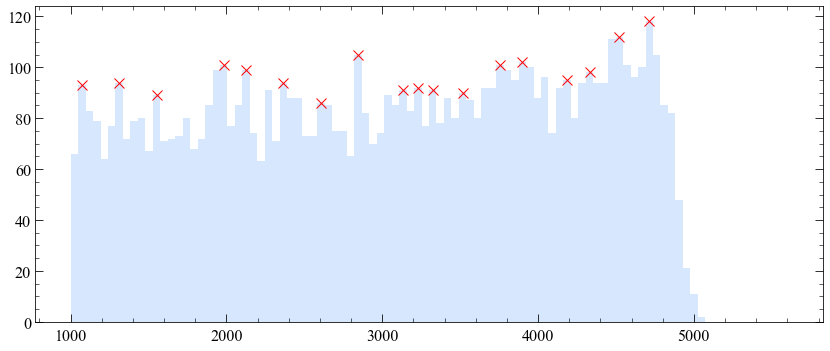

In [1855]:

print(f"len(r2_i) = {len(r2_i)}")

# calculate optimal bin width
hist_range    = [1000,5600]
r2            = r2_i[r2_i >= hist_range[0]]
n_tot         = float(len(r2))
# num_bins      = int(np.sqrt(n_tot))
# print(f"num_bins = int(      np.sqrt(n_tot)) = {num_bins}")
# num_bins_mult =  1.2 if         n_tot < 1000 \
#             else 1.3 if 1000 <= n_tot < 1500 \
#             else 1.4 if 1500 <= n_tot < 2500 \
#             else 1.5 if 2500 <= n_tot < 4000 \
#             else 1.6 if 4000 <= n_tot < 6000 \
#             else 1.7 if 6000 <= n_tot < 8000 \
#             else 1.8
# num_bins      = int(num_bins_mult * np.sqrt(n_tot))
# print(f"num_bins = int({num_bins_mult} * np.sqrt(n_tot)) = {num_bins}") 



# if n_tot < 1000:
#     num_bins  = int(num_bins * 1.6)
# elif 1000 <= n_tot < 2000:
#     num_bins  = int(num_bins * 1.5)
# elif 2000 <= n_tot < 4000:
#     num_bins  = int(num_bins * 1.4)
# elif 4000 <= n_tot < 8000:
#     num_bins  = int(num_bins * 1.3)
# else: 
#     num_bins  = int(num_bins * 1.0)

# num_bins      = 100
# if n_tot < 1000:
#     num_bins  = int(num_bins * 0.8)
# elif 1000 <= n_tot < 2000:
#     num_bins  = int(num_bins * 0.9)
# elif 2000 <= n_tot < 3000:
#     num_bins  = int(num_bins * 1.0)
# elif 3000 <= n_tot < 4000:
#     num_bins  = int(num_bins * 1.1)
# elif 4000 <= n_tot < 6000:
#     num_bins  = int(num_bins * 1.2)
# elif 6000 <= n_tot < 10000:
#     num_bins  = int(num_bins * 1.3)
# elif 10000 <= n_tot < 14000:
#     num_bins  = int(num_bins * 1.4)
# else: 
#     num_bins  = int(num_bins * 1.5)


num_bins      = 'sqrt' 
n_counts, r_bin_edges = np.histogram(r2, bins=num_bins, range=hist_range)
r_bin_vals            = (r_bin_edges[:-1] + r_bin_edges[1:]) / 2
bin_widths            = np.diff(r_bin_edges)
bin_width_val         = bin_widths[0]
num_bins = len(r_bin_edges) - 1
print(f"num_bins =                    'sqrt' = {num_bins}")
print()
print(f"n_tot           = {n_tot}")
print(f"num_bins        = {num_bins}")
print(f"bin_width_val   = {bin_width_val}")

# mask zero count bins
non0_mask      = n_counts > 0
n_counts_no0   = n_counts[non0_mask]
r_bin_vals_no0 = r_bin_vals[non0_mask]

# # ----------------------------------------------------------------------------
no_zeros_bins_mask = (n_counts > 0 ) & (r_bin_vals >= hist_range[0])

# ----------------------------------------------------------------------------
# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# plot histogram
ax.bar(r_bin_vals, n_counts, width=bin_widths, \
       color='xkcd:powder blue', alpha=0.5)
# ----------------------------------------------------------------------------

height       = 0.81 * np.max(n_counts) if num_bins > 100 else 0.68 * np.max(n_counts) 
threshold    = None 
dist_div     = 1 if num_bins <= 75 else 3 if 75 < num_bins <= 150 else 5 
distance     = int(np.sqrt(num_bins)/(2 * dist_div)) if num_bins >= 50 else None
min_for_prom = np.min(n_counts[r_bin_vals<3000])
min_for_prom = min_for_prom if min_for_prom != 0 else 5
prominence   = np.max(n_counts) / min_for_prom
width        = 1 if num_bins <= 40 else 1.1 if 40 < num_bins <= 110 else 1.2
wlen         = None
rel_height   = 0.6 if num_bins <=100 else 0.5
plateau_size = None

peaks, \
properties \
= find_peaks(n_counts, height=height, threshold=threshold, \
             distance=distance, prominence=prominence, \
             width=width, wlen=wlen, rel_height=rel_height, \
             plateau_size=plateau_size)

peak_r2_vals = r_bin_vals[peaks]
peak_heights = n_counts[peaks] #properties['peak_heights']
print(f"peak_heights = {peak_heights}")
print(f"peaks        = {peaks}")
print(f"len(peaks)   = {len(peaks)}")

if len(peaks) == 0:
    _, max_index, _ = find_max_min_index_from_data_subset(r_bin_vals, n_counts, 
                                                          rel_val = 4000, cond='>')
    peaks = np.append(peaks, max_index)
    peak_r_vals = r_bin_vals[peaks]
    peak_heights = n_counts[peaks]

_, max_hist_past_last_peak_index, _ = find_max_min_index_from_data_subset(r_bin_vals, n_counts, \
                                                                rel_index=peaks[-1], cond='>')
    

r_bin_val_max_past_last_peak_index = r_bin_vals[max_hist_past_last_peak_index]
n_count_max_past_last_peak_index   = n_counts[max_hist_past_last_peak_index]
print(f"r_bin_val_max_past_last_peak_index = {r_bin_val_max_past_last_peak_index}")
print(f"n_count_max_past_last_peak_index = {n_count_max_past_last_peak_index}")


if n_count_max_past_last_peak_index > peak_heights[-1] and num_bins < 40:
    peaks = np.append(peaks, max_hist_past_last_peak_index)
    peak_r_vals = r_bin_vals[peaks]
    peak_heights = n_counts[peaks]

peak_indices = peaks
# other peak stuff 
left_ips     = properties['left_ips']
right_ips    = properties['right_ips']
left_ips_indices  = left_ips.astype(int)
left_peak_r2_vals  = r_bin_vals[left_ips_indices]
left_peak_n_count  = n_counts[left_ips_indices]

if len(peaks) == 0:
    left_ips_indices = np.append(left_ips_indices, max_index - 1)
    left_peak_r2_vals  = r_bin_vals[left_ips_indices]
    left_peak_n_count  = n_counts[left_ips_indices]

# Plot the detected peaks
plt.plot(r_bin_vals[peaks], n_counts[peaks], 'rx', label='Peaks')

# print peak paramter info
print()
print(f"np.max(n_counts) = {np.max(n_counts)}")
print(f"num_bins         = {num_bins}")
print(f"height        = {height}")
print(f"threshold     = {threshold}")
print(f"distance      = {distance}")
print(f"prominence    = {prominence}")
print(f"width         = {width}")
print(f"wlen          = {wlen}")

# # Print the peaks and their corresponding bin centers
# print()
# print(f"peak indices:    {peak_indices}")
# print(f"number of peaks: {len(peaks)}")
# print(f"peak heights:    {n_counts[peaks]}")
# print(f"peak heights:    {peak_heights}")
# print(f"peak r vals:     {r_bin_vals[peaks]}")
# print()
# print(f"left_ips:           {left_ips}")
# print(f"left_ips_indices:   {left_ips_indices}")
# print(f"left_peak_r2_vals:  {left_peak_r2_vals}")
# print(f"left_peak_n_count:  {left_peak_n_count}")

# ax.set_xlim(3000, 5000)
# ax.set_ylim(80, 130)



n_ratio_for_peak = 0.696282121377802
n_counts_avg_for_height_fact = 93.27272727272727
n_ratio_for_height_fact      = 0.7904468412942989
peak_heights = [ 93  94  89 101  99  91  94  86 105  89  91  92  91  88  90 101 102  96
  95  98 112 118]
peaks        = [ 1  6 11 20 23 26 28 33 38 42 44 46 48 50 52 57 60 63 66 69 73 77]
len(peaks)   = 22
r_bin_val_max_past_last_peak_index = 4761.4580078125
n_count_max_past_last_peak_index = 105

np.max(n_counts_smooth) = 118
num_bins                = 96
sigma                   = 0.05500000000000001
height_fact             = 0.7
height                  = 82.6
width                   = 0.5
left_peak_r2_val        = 2221.875
left_peak_n_count       = 63


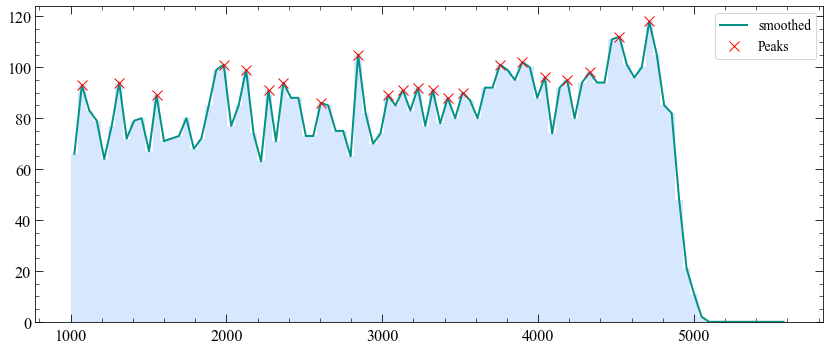

In [1854]:
# smooth before peak finding?

n_counts_avg_for_peak = np.mean(n_counts[(r_bin_vals > 2000) & (r_bin_vals < 3500)])
n_ratio_for_peak      = n_counts_avg_for_peak / np.max(n_counts)
print(f"n_ratio_for_peak = {n_ratio_for_peak}")

# n_counts_smooth = gaussian_filter1d(n_counts, sigma = 0.5   if (num_bins > 100) or  (n_ratio_for_peak < 0.5) 
#                                                 else  0.4   if (num_bins < 100) and (n_ratio_for_peak < 0.5)
#                                                 else  0.8)


n_counts_avg_for_height_fact = np.mean(n_counts[(r_bin_vals > 3500) & (r_bin_vals < 4000)])
n_ratio_for_height_fact      = n_counts_avg_for_height_fact / np.max(n_counts)
print(f"n_counts_avg_for_height_fact = {n_counts_avg_for_height_fact}")
print(f"n_ratio_for_height_fact      = {n_ratio_for_height_fact}")


sigma =   0.4   if (num_bins < 80) and (n_ratio_for_peak < 0.5) \
    else  0.5   if (num_bins > 90) and (n_ratio_for_peak < 0.5) \
    else  0.5   if num_bins < 80 \
    else  0.55  if 80 <= num_bins < 110 \
    else  0.6
sigma = sigma   if n_ratio_for_height_fact < 0.6 \
                else sigma * 0.05 if 0.6 <= n_ratio_for_height_fact < 0.75 \
                else sigma * 0.1

# sigma_left  = 2
# sigma_right = 0.05

# dT_top_cond      =     dT_index <= 5
# dT_mid_cond      = 5 < dT_index <  30
# dT_bot_cond      =     dT_index >= 30

# left_smooth_mask  =       r_bin_vals < 4600 if dT_top_cond \
#                      else r_bin_vals < 4300 if dT_mid_cond \
#                      else r_bin_vals < 3800 
# right_smooth_mask = ~left_smooth_mask

# n_counts_smooth_left  = gaussian_filter1d(n_counts, sigma = sigma_left)
# n_counts_smooth_left  = n_counts_smooth_left[left_smooth_mask]
# #n_counts_smooth_left  = np.array(n_counts_smooth_left)
# n_counts_smooth_right = gaussian_filter1d(n_counts, sigma = sigma_right)
# n_counts_smooth_right = n_counts_smooth_right[right_smooth_mask]
# #n_counts_smooth_right = np.array(n_counts_smooth_right)


# print(f"n_counts_smooth_left  = {n_counts_smooth_left}")
# print(f"n_counts_smooth_right = {n_counts_smooth_right}")

# n_counts_smooth_combine = np.concatenate((n_counts_smooth_left, n_counts_smooth_right))
# n_counts_smooth         = gaussian_filter1d(n_counts_smooth_combine, sigma = 0.1)

n_counts_smooth         = gaussian_filter1d(n_counts, sigma = sigma)

width  = 0.5 #if num_bins < 110 else 1.5 if 120 <= num_bins < 150 else 0.7 if 150 <= num_bins < 190 else 0.8
height_fact = 0.70 if num_bins < 110    else 0.75 if 110 <= num_bins < 130 \
                                        else 0.78 if 130 <= num_bins < 150 \
                                        else 0.80 if 150 <= num_bins < 190 \
                                        else 0.85



height_fact = height_fact       if n_ratio_for_height_fact < 0.6 \
         else height_fact * 0.7 if 0.6 <= n_ratio_for_height_fact < 0.75 \
         else height_fact 
height = height_fact * np.max(n_counts_smooth)


# height = 0.75 * np.max(n_counts_smooth) if num_bins < 190 else 0.85 * np.max(n_counts_smooth)

peaks, \
properties \
= find_peaks(n_counts_smooth, height=height, rel_height=1.0, width=width)

peak_indices = peaks
peak_r2_vals = r_bin_vals[peaks]
peak_heights = n_counts_smooth[peaks] #properties['peak_heights']
print(f"peak_heights = {peak_heights}")
print(f"peaks        = {peaks}")
print(f"len(peaks)   = {len(peaks)}")

if len(peaks) == 0:
    _, max_index, _ = find_max_min_index_from_data_subset(r_bin_vals, n_counts_smooth, 
                                                          rel_val = 4000, cond='>')
    peaks        = np.append(peaks, max_index)
    peak_r_vals  = r_bin_vals[peaks]
    peak_heights = n_counts_smooth[peaks]

_, max_hist_past_last_peak_index, _ \
= find_max_min_index_from_data_subset(r_bin_vals, n_counts_smooth, 
                                      rel_index=peaks[-1], cond='>')
    

r_bin_val_max_past_last_peak_index = r_bin_vals[max_hist_past_last_peak_index]
n_count_max_past_last_peak_index   = n_counts[max_hist_past_last_peak_index]
print(f"r_bin_val_max_past_last_peak_index = {r_bin_val_max_past_last_peak_index}")
print(f"n_count_max_past_last_peak_index = {n_count_max_past_last_peak_index}")


if n_count_max_past_last_peak_index > peak_heights[-1] and num_bins < 40:
    peaks        = np.append(peaks, max_hist_past_last_peak_index)
    peak_r_vals  = r_bin_vals[peaks]
    peak_heights = n_counts[peaks]

peak_indices = peaks
# other peak stuff 
left_ips     = properties['left_ips']
right_ips    = properties['right_ips']
left_ips_indices   = left_ips.astype(int)
left_peak_r2_vals  = r_bin_vals[left_ips_indices]
left_peak_n_counts = n_counts[left_ips_indices]

if len(peaks) == 0:
    left_ips_indices   = np.append(left_ips_indices, max_index - 1)
    left_peak_r2_vals  = r_bin_vals[left_ips_indices]
    left_peak_n_counts = n_counts[left_ips_indices]
    
left_peak_r2_val  = left_peak_r2_vals[-1]
left_peak_n_count = left_peak_n_counts[-1]

# print peak paramter info
print()
print(f"np.max(n_counts_smooth) = {np.max(n_counts_smooth)}")
print(f"num_bins                = {num_bins}")
print(f"sigma                   = {sigma}")
print(f"height_fact             = {height_fact}")
print(f"height                  = {height}")
print(f"width                   = {width}")
print(f"left_peak_r2_val        = {left_peak_r2_val}")
print(f"left_peak_n_count       = {left_peak_n_count}")

# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# plot histogram
ax.bar(r_bin_vals, n_counts, width=bin_widths, \
       color='xkcd:powder blue', alpha=0.5)

# plot individual data
ax.plot(r_bin_vals, n_counts_smooth, \
         lw=2, color='xkcd:teal',label=f"smoothed")

# Plot the detected peaks
plt.plot(r_bin_vals[peaks], n_counts[peaks], 'rx', label='Peaks')

ax.legend()


#### new method attempt on 7/30

In [65]:
# n_counts_smooth         = gaussian_filter1d(n_counts_smooth_combine, sigma = 0.1)

# width       = 0.5 
# height_fact = 0.8 # captures fewer peaks at the end 0.9
# height      = height_fact * np.max(n_counts_smooth[right_smooth_mask])

# peaks, \
# properties \
# = find_peaks(n_counts_smooth, height=height, rel_height=1.0, width=width)

# # peak stuff 
# if len(peak_indices) != 0:
#     peak_indices         = peaks
#     peak_r2_vals         = r2_bin_vals[peak_indices]
#     peak_heights         = n_counts_smooth[peak_indices]
#     left_ips             = properties['left_ips']
#     left_ips_indices     = left_ips.astype(int)
    
# else:
#     _, max_index, _      = find_max_min_index_from_data_subset(r2_bin_vals, 
#                                                                n_counts, 
#                                                                rel_val = smooth_trans_val, cond='>')
#     peak_indices         = np.append(peak_indices, max_index)
#     peak_r2_vals         = r2_bin_vals[peak_indices]
#     peak_heights         = n_counts[peak_indices]
#     left_ips_indices     = np.append(left_ips_indices, max_index - 2)


# left_peak_r2_vals    = r2_bin_vals[left_ips_indices]
# left_peak_n_counts   = n_counts[left_ips_indices]  
# left_peak_r2_val     = left_peak_r2_vals[-1]
# left_peak_n_count    = left_peak_n_counts[-1]
# left_of_peak_r2_val  = left_peak_r2_val
# left_of_peak_n_count = left_peak_n_count

# # get final (or only) peak r2 and count values 
# final_peak_r2_val = peak_r2_vals[-1]
# final_peak_height = peak_heights[-1]

# # plot individual data
# ax.plot(r2_bin_vals, n_counts_smooth, \
#          lw=2, color='xkcd:teal',label=f"smoothed")

# # Plot the detected peaks
# ax.plot(r2_bin_vals[peaks], n_counts[peaks], 'rx', label='Peaks')

###### look at number of counts in each calT slice

In [35]:
# get_list_shape(r2_events[0])

In [33]:
print(len(r2_events))
print(len(r2_events[0]))
print(type(r2_events))

25
36
<class 'list'>


In [34]:
print(np.array(r2_events[1][5]))

[ 527.88922119  327.9369812   638.99804688 ... 4302.89892578 1667.16467285
 1306.52307129]


In [35]:
hist_range    = [1000.,5600.]
print(hist_range[0])
print(len(r2_events[1][0]))

1000.0
6191


In [36]:
N_events                = []
N_events_avg            = []
calT_index_N_events_avg = []

for calT_index in range(len(r2_events)):
    
    N_events_per_calT = []
    
    for dT_index in range(len(r2_events[0])):
        
        r2_events_per_calT_dT_i = np.array(r2_events[calT_index][dT_index])
        r2_events_per_calT_dT   = r2_events_per_calT_dT_i[r2_events_per_calT_dT_i >= hist_range[0]]
        N_events_per_calT_dT    = len(r2_events_per_calT_dT)
        N_events_per_calT.append(N_events_per_calT_dT)
    
    N_events.append(N_events_per_calT)

for calT_index in range(len(N_events)):    
    N_events_avg_calT = np.mean(N_events[calT_index])
    N_events_avg.append(N_events_avg_calT)
    calT_index_N_events_avg.append((calT_index, N_events_avg_calT))


# for calT_index in range(len(N_events)):
#     if calT_index < 10:
#         print(f"calT [0{calT_index}]:    N_events_avg = {int(N_events_avg[calT_index])}")
#         print(f"----------------------------------")
#         print()
#         print(f"N_events[0{calT_index}] = {N_events[calT_index]}")
#         print()
#         print(f"___________________________________________________________________________________")
#         print()
#     else:
#         print(f"calT [{calT_index}]:    N_events_avg = {int(N_events_avg[calT_index])}")
#         print(f"----------------------------------")
#         print()
#         print(f"N_events[{calT_index}] = {N_events[calT_index]}")
#         print()
#         print(f"___________________________________________________________________________________")
#         print()

for calT_index in range(len(N_events)):
    if calT_index < 10:
        print(f"calT [0{calT_index}]:    N_events_avg = {int(N_events_avg[calT_index])}")
    else:
        print(f"calT [{calT_index}]:    N_events_avg = {int(N_events_avg[calT_index])}")

calT [00]:    N_events_avg = 5478
calT [01]:    N_events_avg = 4947
calT [02]:    N_events_avg = 0
calT [03]:    N_events_avg = 9226
calT [04]:    N_events_avg = 23975
calT [05]:    N_events_avg = 22078
calT [06]:    N_events_avg = 24785
calT [07]:    N_events_avg = 37189
calT [08]:    N_events_avg = 18838
calT [09]:    N_events_avg = 3647
calT [10]:    N_events_avg = 10860
calT [11]:    N_events_avg = 12694
calT [12]:    N_events_avg = 6862
calT [13]:    N_events_avg = 2042
calT [14]:    N_events_avg = 800
calT [15]:    N_events_avg = 7628
calT [16]:    N_events_avg = 35627
calT [17]:    N_events_avg = 8962
calT [18]:    N_events_avg = 5614
calT [19]:    N_events_avg = 3991
calT [20]:    N_events_avg = 1236
calT [21]:    N_events_avg = 23270
calT [22]:    N_events_avg = 10372
calT [23]:    N_events_avg = 21282
calT [24]:    N_events_avg = 5149


In [37]:
print(N_events[18])

[7221, 6412, 6335, 6538, 6367, 6433, 6290, 6204, 6490, 6259, 6086, 6280, 6053, 5918, 5816, 5665, 5642, 5650, 5534, 5377, 5631, 5398, 5301, 5185, 5337, 5323, 5182, 5330, 5259, 5015, 4962, 4839, 4763, 4558, 4462, 3013]


###### ordered calT slices list

In [38]:
# sorted results

# Sort the results by the average number of events
ordered_calT_index_N_events_avg = sorted(calT_index_N_events_avg, key=lambda x: x[1])

# print
for calT_index, avg_events in ordered_calT_index_N_events_avg:
    if calT_index < 10:
        print(f"calT [0{calT_index}]:    N_avg_per_calT = {int(avg_events)}")
    else:
        print(f"calT [{calT_index}]:    N_avg_per_calT = {int(avg_events)}")
        

calT [02]:    N_avg_per_calT = 0
calT [14]:    N_avg_per_calT = 800
calT [20]:    N_avg_per_calT = 1236
calT [13]:    N_avg_per_calT = 2042
calT [09]:    N_avg_per_calT = 3647
calT [19]:    N_avg_per_calT = 3991
calT [01]:    N_avg_per_calT = 4947
calT [24]:    N_avg_per_calT = 5149
calT [00]:    N_avg_per_calT = 5478
calT [18]:    N_avg_per_calT = 5614
calT [12]:    N_avg_per_calT = 6862
calT [15]:    N_avg_per_calT = 7628
calT [17]:    N_avg_per_calT = 8962
calT [03]:    N_avg_per_calT = 9226
calT [22]:    N_avg_per_calT = 10372
calT [10]:    N_avg_per_calT = 10860
calT [11]:    N_avg_per_calT = 12694
calT [08]:    N_avg_per_calT = 18838
calT [23]:    N_avg_per_calT = 21282
calT [05]:    N_avg_per_calT = 22078
calT [21]:    N_avg_per_calT = 23270
calT [04]:    N_avg_per_calT = 23975
calT [06]:    N_avg_per_calT = 24785
calT [16]:    N_avg_per_calT = 35627
calT [07]:    N_avg_per_calT = 37189


###### ordered calT slices by number of counts - ranges

##### look at slice

In [39]:
# get data
calT_index = 14 # 1 5 7 23
dT_index   = 35
r2_i       = r2_events[calT_index][dT_index]

# histogram settings 

# hist_range    = [0,5600]
hist_range    = [1000,5600]
r2            = r2_i[r2_i >= hist_range[0]]
n_tot         = float(len(r2))
print(f"[{calT_index},{dT_index}] n_tot_initial = {int(len(r2_i))}")
print(f"[{calT_index},{dT_index}] n_tot         = {int(n_tot)}")


[14,35] n_tot_initial = 785
[14,35] n_tot         = 679


n_tot         = 679
num_bins_mult = 1.6
num_bins      = 41


(1000.0, 5300.0)

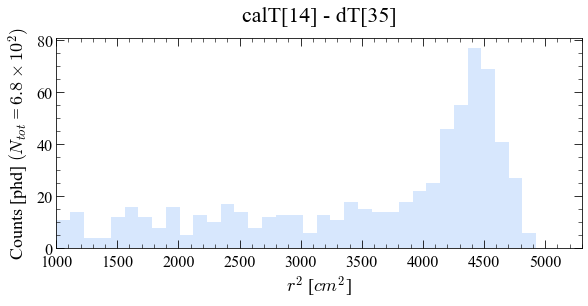

In [42]:
# histogram settings 
hist_range    = [1000,5600]
r2            = r2_i[r2_i >= hist_range[0]]
n_tot         = float(len(r2))
# num_bins_mult =      1.6  if         n_tot <= 700 \
#                 else 1.4  if 700   < n_tot <= 1000 \
#                 else 1.2  if 1000  < n_tot <= 2000 \
#                 else 1.15 if 2000  < n_tot <= 3000 \
#                 else 1.1  if 3000  < n_tot <= 5500 \
#                 else 1.0  if 5500  < n_tot <= 15000 \
#                 else 0.9  if 15000 < n_tot <= 23000 \
#                 else 0.8  if 23000 < n_tot <= 30000 \
#                 else 0.6
n_tot_range_1  =                   (n_tot <= 800  )
n_tot_range_2  = (800   < n_tot) & (n_tot <= 1500 )
n_tot_range_3  = (1500  < n_tot) & (n_tot <= 2000 )
n_tot_range_4  = (2000  < n_tot) & (n_tot <= 2500 ) #**
n_tot_range_5  = (2500  < n_tot) & (n_tot <= 3000 )
n_tot_range_6  = (3000  < n_tot) & (n_tot <= 5500 )
n_tot_range_7  = (5500  < n_tot) & (n_tot <= 10000)
n_tot_range_8  = (10000 < n_tot) & (n_tot <= 15000)
n_tot_range_9  = (15000 < n_tot) & (n_tot <= 23000) 
n_tot_range_10 = (23000 < n_tot) & (n_tot <= 30000)
num_bins_mult =      1.6  if n_tot_range_1  \
                else 1.6  if n_tot_range_2  \
                else 1.2  if n_tot_range_3  \
                else 1.2  if n_tot_range_4  \
                else 1.15 if n_tot_range_5  \
                else 1.1  if n_tot_range_6  \
                else 0.9  if n_tot_range_7  \
                else 0.8  if n_tot_range_8  \
                else 0.75 if n_tot_range_9  \
                else 0.7  if n_tot_range_10 \
                else 0.6
num_bins      = int(num_bins_mult * np.sqrt(n_tot))
#num_bins      = 80

# debug
print(f"n_tot         = {int(n_tot)}")
print(f"num_bins_mult = {num_bins_mult}")
print(f"num_bins      = {num_bins}")

# create histogram  
n_counts, r2_bin_edges = np.histogram(r2, bins=num_bins, range=hist_range)
r2_bin_vals            = (r2_bin_edges[:-1] + r2_bin_edges[1:]) / 2
bin_widths             = np.diff(r2_bin_edges)
bin_width_val          = bin_widths[0]

# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# plot histogram
ax.bar(r2_bin_vals, n_counts, width=bin_widths, \
       color='xkcd:powder blue', alpha=0.5)

# create counts for label
n_tot_num_for_label = "{:.1e}".format(n_tot)
base, exponent = n_tot_num_for_label.split("e")
n_tot_num_for_label = f"${base} \\times {{10}}^{int(exponent)}$"

# labels, plot settings
title_label = (f"calT[{calT_index}] - dT[{dT_index}]")
ax.set_title(title_label, y=1.05, fontsize=22)
ax.set_xlabel(f"$r^2$ [${{cm}}^2$]")
ax.set_ylabel(f"Counts [phd] $(N_{{tot}}$ = {n_tot_num_for_label}$)$")
#ax.legend(loc="lower left")

ax.set_xlim(1000, 5300)

smooth_trans_val = 4300
avg_to_var_ratio = 8.6952681737347
avg (nonzero_counts) = 105.8
var (nonzero_counts) = 148.05
mean to var ratio    = 8.69527

sigma_left  = 2.0
sigma_right = 0.3



(3000.0, 5300.0)

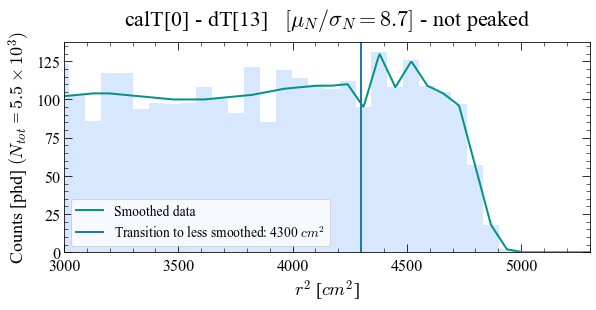

In [47]:
# transition value settings 
dT_top_cond      =       dT_index <= 5
dT_mid1_cond     = 6  <= dT_index <= 17
dT_mid2_cond     = 18 <= dT_index <= 29
dT_bot_cond      =       dT_index >= 30

if calT_index == 23:
    smooth_trans_val =       4400 if dT_top_cond \
                        else 4200 if dT_mid1_cond \
                        else 4100 if dT_mid2_cond \
                        else 3800     
    
elif n_tot > 10000 and calT_index != 23:
    smooth_trans_val =       4500 if dT_top_cond \
                        else 4400 if dT_mid1_cond \
                        else 4250 if dT_mid2_cond \
                        else 4000 
else:
    smooth_trans_val =       4500 if dT_top_cond \
                        else 4300 if dT_mid1_cond \
                        else 4150 if dT_mid2_cond \
                        else 3800 

print(f"smooth_trans_val = {smooth_trans_val}")

# find mean to variance ratio 
no_zero_bins_mask        = n_counts > 0
r2_bin_vals_nonzero      = r2_bin_vals[no_zero_bins_mask]
n_counts_nonzero         = n_counts[no_zero_bins_mask]
# max_nonzero_count_index  = np.argmax(n_counts_nonzero)
_, max_nonzero_count_index, _ \
                         = find_max_min_index_from_data_subset(r2_bin_vals_nonzero, 
                                                               n_counts_nonzero, 
                                                               rel_val=smooth_trans_val, 
                                                               cond='>=')
max_nonzero_count_r2_val = r2_bin_vals_nonzero[max_nonzero_count_index]
max_nonzero_count_n      = n_counts_nonzero[max_nonzero_count_index]
# r2_less_than_max_mask    = r2_bin_vals_nonzero <= r2_bin_vals_nonzero[max_nonzero_count_index + 2]
# avg_nonzero_counts, \
# std_nonzero_counts       = weighted_avg_and_std(n_counts_nonzero[r2_less_than_max_mask], np.sqrt(n_counts_nonzero[r2_less_than_max_mask]))
# var_nonzero_counts       = std_nonzero_counts**2
# avg_to_var_ratio         = avg_nonzero_counts / std_nonzero_counts
# # variance_nonzero_counts = np.var(n_counts_nonzero)
# print(f"avg (nonzero_counts) = {np.round(avg_nonzero_counts,2)}")
# print(f"var (nonzero_counts) = {np.round(var_nonzero_counts,2)}")
# print(f"mean to var ratio    = {np.round(avg_to_var_ratio,5)}")
# print()

# find mean to variance ratio 
post_3000_mask             = (r2_bin_vals > 3000) & (n_counts > 0)
r2_bin_vals_post_3000      = r2_bin_vals[post_3000_mask]
n_counts_post_3000         = n_counts[post_3000_mask]
# max_post_3000_count_index  = np.argmax(n_counts_post_3000)
_, max_post_3000_count_index, _ \
                         = find_max_min_index_from_data_subset(r2_bin_vals_post_3000, 
                                                               n_counts_post_3000, 
                                                               rel_val=smooth_trans_val, 
                                                               cond='>=')
max_post_3000_count_r2_val = r2_bin_vals_post_3000[max_post_3000_count_index]
max_post_3000_count_n      = n_counts_post_3000[max_post_3000_count_index]
r2_less_than_max_mask      = r2_bin_vals_post_3000 <= r2_bin_vals_post_3000[max_post_3000_count_index]
avg_post_3000_counts, \
std_post_3000_counts       = weighted_avg_and_std(n_counts_post_3000[r2_less_than_max_mask], 
                                                  np.sqrt(n_counts_post_3000[r2_less_than_max_mask]))
var_post_3000_counts       = std_post_3000_counts**2
avg_to_var_ratio           = avg_post_3000_counts / std_post_3000_counts
# variance_nonzero_counts = np.var(n_counts_nonzero)
print(f"avg_to_var_ratio = {avg_to_var_ratio}")
print(f"avg (nonzero_counts) = {np.round(avg_post_3000_counts,2)}")
print(f"var (nonzero_counts) = {np.round(var_post_3000_counts,2)}")
print(f"mean to var ratio    = {np.round(avg_to_var_ratio,5)}")
print()

# decide on what counts as peaked from avg_to_var_ratio
peak_Avg_Var_ratio_cond =  avg_to_var_ratio <= 5.0

# Create the conditional part of the title
peak_status = " - peaked" if peak_Avg_Var_ratio_cond else " - not peaked"


        
left_smooth_mask  = r2_bin_vals < smooth_trans_val
right_smooth_mask = ~left_smooth_mask


sigma_left  =    2.0 if        num_bins < 75  \
            else 2.5 if 75  <= num_bins < 120 \
            else 3.0 if 120 <= num_bins < 140 \
            else 4.0
sigma_right =    0.01 if peak_Avg_Var_ratio_cond and num_bins >= 75 \
            else 0.2  if peak_Avg_Var_ratio_cond and num_bins  < 75 \
            else 0.3
# sigma_right =    0.2  if        num_bins < 75  and     peak_Avg_Var_ratio_cond \
#             else 0.15 if 75  <= num_bins < 120 and     peak_Avg_Var_ratio_cond \
#             else 0.1  if 120 <= num_bins < 140 and     peak_Avg_Var_ratio_cond \
#             else 0.05 if        num_bins > 140 and     peak_Avg_Var_ratio_cond \
#             else 0.5  if        num_bins < 75  and not peak_Avg_Var_ratio_cond \
#             else 0.5  if 75  <= num_bins < 120 and not peak_Avg_Var_ratio_cond \
#             else 0.3  if 120 <= num_bins < 140 and not peak_Avg_Var_ratio_cond \
#             else 0.2  

print(f"sigma_left  = {sigma_left}")
print(f"sigma_right = {sigma_right}")
print()

n_counts_smooth_left  = gaussian_filter1d(n_counts, sigma = sigma_left)
n_counts_smooth_right = gaussian_filter1d(n_counts, sigma = sigma_right)

n_counts_smooth_left  = n_counts_smooth_left[left_smooth_mask]
n_counts_smooth_right = n_counts_smooth_right[right_smooth_mask]

n_counts_smooth_combine = np.concatenate((n_counts_smooth_left, n_counts_smooth_right))


r2_bin_vals_smooth = np.linspace(np.min(r2_bin_vals), np.max(r2_bin_vals), 1000)
interp_func        = interp1d(r2_bin_vals, n_counts_smooth_combine, kind='linear', fill_value="extrapolate")
n_counts_smooth_i  = interp_func(r2_bin_vals_smooth)
n_counts_smooth    = gaussian_filter1d(n_counts_smooth_i, sigma = 0.05)

left_smooth_mask  = r2_bin_vals_smooth < smooth_trans_val
right_smooth_mask = ~left_smooth_mask

# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# plot histogram
ax.bar(r2_bin_vals, n_counts, width=bin_widths, \
       color='xkcd:powder blue', alpha=0.5)

# plot individual smoothed data
ax.plot(r2_bin_vals_smooth, n_counts_smooth, \
         lw=2, color='xkcd:teal',label=f"Smoothed data")

# plot vertical line at transition value
ax.axvline(smooth_trans_val, label=f"Transition to less smoothed: {int(smooth_trans_val)} ${{cm}}^2$")

# labels, plot settings
# Combine everything into the final title
title_label = (f"calT[{calT_index}] - dT[{dT_index}]   "
               f"$[\\mu _N / {{\\sigma}} _N={np.round(avg_to_var_ratio, 2)}]$"
               f"{peak_status}")
ax.set_title(title_label, y=1.05, fontsize=22)
ax.set_xlabel(f"$r^2$ [${{cm}}^2$]")
ax.set_ylabel(f"Counts [phd] $(N_{{tot}}$ = {n_tot_num_for_label}$)$")
ax.legend(loc="lower left")

ax.set_xlim(3000, 5300)
#ax.set_ylim(150, 260)



doesn't meet peaked condition

peak_prominences     = [ 4.          9.98498498 34.25825826 16.35735736]

width                = 0.5
height_fact          = 0.8
height               = 103.68288288288294
rel_height           = 1.0
wlen                 = 300

number of peaks      = 4
peak_indices         = [469 707 738 768]
peak_r2_vals         = [3161.68744502 4240.97885765 4381.55883156 4517.6039676 ]
peak_heights         = [104.         109.98498498 129.6036036  124.48948949]

final_peak_r2_val    = 4517.603967603968
final_peak_height    = 124.48948948948956

heightMax past trans = 129.60360360360366
peak/heightMaxTrans  = 0.96054


(2000.0, 5600.0)

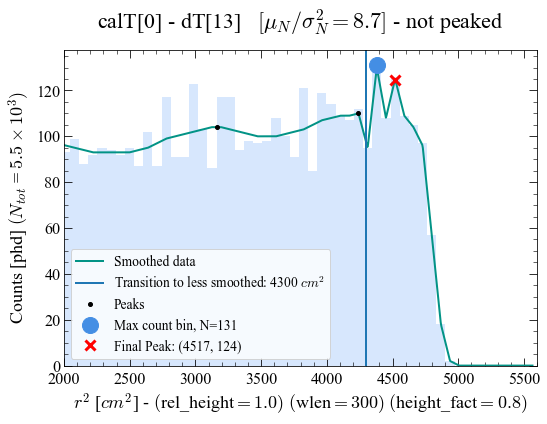

In [48]:
# find peaks from smoothed data 

width       = 0.5 
if peak_Avg_Var_ratio_cond:
    print()
    print(f"meets peaked condition")
    print()
    height_fact = 0.9 
    height      = height_fact * np.max(n_counts_smooth[right_smooth_mask])
    wlen        = 300 
    rel_height  = 0.5
else: 
    print()
    print(f"doesn't meet peaked condition")
    print()
    height_fact = 0.85 if n_tot > 10000 else 0.8 if 10000 >= n_tot > 5000 else 0.7
    # height_fact = 0.8 if num_bins > 50 else 0.7
    # height_fact = height_fact if n_tot < 10000 else 0.85
    height      = height_fact * np.max(n_counts_smooth[right_smooth_mask])
    wlen        = 300 
    rel_height  = 1.0


peaks, \
properties \
             = find_peaks(n_counts_smooth, height=height, rel_height=rel_height, width=width, wlen=wlen)
peak_indices = peaks

# peak stuff 
if len(peak_indices) != 0:
    peak_r2_vals         = r2_bin_vals_smooth[peak_indices]
    peak_heights         = n_counts_smooth[peak_indices]
    left_ips             = properties['left_ips']
    left_ips_indices     = left_ips.astype(int)
    
else:
    print(f"0 peaks detected - adding addtional peak at the max beyond r2 = {smooth_trans_val} cm2")
    _, max_index, _      = find_max_min_index_from_data_subset(r2_bin_vals_smooth, 
                                                               n_counts_smooth, 
                                                               rel_val = smooth_trans_val, cond='>')
    peak_indices         = np.append(peak_indices, max_index)
    peak_r2_vals         = r2_bin_vals_smooth[peak_indices]
    peak_heights         = n_counts_smooth[peak_indices]
    left_ips_indices     = np.append(left_ips_indices, max_index - 2)

# get peak values 
left_peak_r2_vals    = r2_bin_vals_smooth[left_ips_indices]
left_peak_n_counts   = n_counts_smooth[left_ips_indices]  
left_peak_r2_val     = left_peak_r2_vals[-1]
left_peak_n_count    = left_peak_n_counts[-1]
left_of_peak_r2_val  = left_peak_r2_val
left_of_peak_n_count = left_peak_n_count

# get final (or only) peak r2 and count values 
final_peak_r2_val = peak_r2_vals[-1]
final_peak_height = peak_heights[-1]
final_peak_index  = peak_indices[-1]

peak_prominences = properties['prominences']
print(f"peak_prominences     = {peak_prominences}")
print()

# print peak paramter info 
print(f"width                = {width}")
print(f"height_fact          = {height_fact}")
print(f"height               = {height}")
print(f"rel_height           = {rel_height}")
print(f"wlen                 = {wlen}")
print()
print(f"number of peaks      = {len(peak_indices)}")
print(f"peak_indices         = {peak_indices}")
print(f"peak_r2_vals         = {peak_r2_vals}")
print(f"peak_heights         = {peak_heights}")
print()
print(f"final_peak_r2_val    = {final_peak_r2_val}")
print(f"final_peak_height    = {final_peak_height}")
print()
# print(f"left_of_peak_r2_val  = {left_of_peak_r2_val}")
# print(f"left_of_peak_n_count = {left_peak_n_count}")
# print()
print(f"heightMax past trans = {np.max(n_counts_smooth[right_smooth_mask])}")
print(f"peak/heightMaxTrans  = {np.round(final_peak_height / np.max(n_counts_smooth[right_smooth_mask]), 5)}")


# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

# plot histogram
ax.bar(r2_bin_vals, n_counts, width=bin_widths, \
       color='xkcd:powder blue', alpha=0.5)

# plot individual smoothed data
ax.plot(r2_bin_vals_smooth, n_counts_smooth, \
         lw=2, color='xkcd:teal',label=f"Smoothed data")

# plot vertical line at transition value
ax.axvline(smooth_trans_val, label=f"Transition to less smoothed: {int(smooth_trans_val)} ${{cm}}^2$")

# Plot the detected peaks
ax.plot(peak_r2_vals, peak_heights, 'k.', ms=8, label='Peaks')

# Plot max point
ax.plot(max_nonzero_count_r2_val, max_nonzero_count_n, 'o', color="xkcd:dark sky blue", ms=16, label=f"Max count bin, N={max_nonzero_count_n}")

# plot the final peak 
ax.plot(final_peak_r2_val, final_peak_height, 'rx', ms=10, mew=3,  
        label=f"Final Peak: ({int(final_peak_r2_val)}, {int(final_peak_height)})")
# ax.plot(left_of_peak_r2_val, left_of_peak_n_count, 'r|', ms=35, mew=2, 
#         label=f"Left edge of final peak: ({int(left_of_peak_r2_val)}, {int(left_of_peak_n_count)})")

# set title, x, y labels 
n_tot_num_for_label = "{:.1e}".format(n_tot)
base, exponent = n_tot_num_for_label.split("e")
n_tot_num_for_label = f"${base} \\times {{10}}^{int(exponent)}$"

# Create the conditional part of the title
peak_status = " - peaked" if peak_Avg_Var_ratio_cond else " - not peaked"

# Combine everything into the final title
title_label = (f"calT[{calT_index}] - dT[{dT_index}]   "
               f"$[\\mu _N / {{\\sigma}}^2 _N={np.round(avg_to_var_ratio, 2)}]$"
               f"{peak_status}")

ax.set_title(title_label, y=1.05, fontsize=22)
ax.set_xlabel(f"$r^2$ [${{cm}}^2$] - $($rel_height$ = {rel_height})$ $($wlen$ = {wlen})$ $($height_fact$ = {height_fact})$")
ax.set_ylabel(f"Counts [phd] $(N_{{tot}}$ = {n_tot_num_for_label}$)$")
ax.legend(loc="lower left")

ax.set_xlim(2000, 5600)
# ax.set_ylim(150, 260)


### smooth data?

#### method as of 7/29 - functional

r_bin_val_last_peak = 4542.0
n_count_last_peak   = 203
left_peak_r2_val    = 4511.3330078125
left_peak_n_count   = 180

last_nonzero_n_count = 1

stddev_approx_num_bins = 4.333342621304217
stddev_approx_num_bins = 5
num_sigmas_before_peak = 0.495
n_counts_avg_before_peak = 130.2450980392157

     ~* multiple peaks *~
               &            
 ~* pronounced final peak *~ 

combine_val1 = 4476.219946289062
combine_val2 = 4586.296332465277



(-5.0, 270.6666666666667)

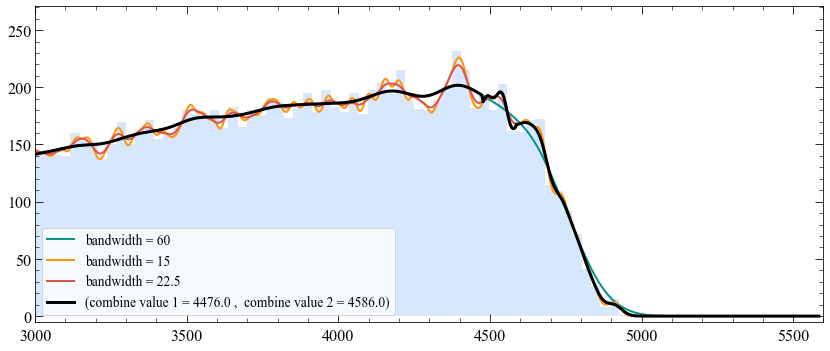

In [1810]:

# get last peak
r_bin_val_last_peak = r_bin_vals[peak_indices][-1]
n_count_last_peak   = n_counts[peak_indices][-1]
print(f"r_bin_val_last_peak = {r_bin_val_last_peak}")
print(f"n_count_last_peak   = {n_count_last_peak}")
print(f"left_peak_r2_val    = {left_peak_r2_val}")
print(f"left_peak_n_count   = {left_peak_n_count}")
print()

# get last zero r-val
no_zeros_bins_mask   = (n_counts > 0)
r_bin_vals_nonzero   = r_bin_vals[no_zeros_bins_mask]
num_nonzero_bins     = len(r_bin_vals_nonzero)
last_nonzero_r_val   = r_bin_vals_nonzero[-1]
# *** CHANGE *** ADD
n_counts_nonzero     = n_counts[no_zeros_bins_mask]
last_nonzero_n_count = n_counts_nonzero[-1]
print(f"last_nonzero_n_count = {last_nonzero_n_count}")
print()
# *** CHANGE ***

# get distance from last peak to last nonzero r-val
dist_last_peak_to_last_r_val = last_nonzero_r_val - r_bin_val_last_peak

# standard deviation guess (peak to last r-val / 3)
stddev_approx          = dist_last_peak_to_last_r_val / 3
stddev_approx_num_bins = stddev_approx / bin_width_val
print(f"stddev_approx_num_bins = {stddev_approx_num_bins}")
stddev_approx_num_bins = int(np.ceil(stddev_approx_num_bins))
print(f"stddev_approx_num_bins = {stddev_approx_num_bins}")

# # get how many sigmas should be included before the peak 
# left_of_peak_index        = left_ips_indices[-1]
# left_of_peak_n_counts     = n_counts[left_of_peak_index]
# num_sigmas                = np.arange(0.2, 4.0, 0.01)
# gauss_height_amp1         = f_gaussian_val((num_sigmas), 1, 0, 1)
# gh_a1                     = gauss_height_amp1
# left_of_n_to_peak_n_ratio = left_of_peak_n_counts / n_count_last_peak
# lontpn_ratio              = left_of_n_to_peak_n_ratio
# idx_before                = np.where((gh_a1[:-1] >= lontpn_ratio) & (gh_a1[1:] <= lontpn_ratio))[0]
# idx_btwn                  = [[index, index + 1] for index in idx_before][0]
# num_sigmas_before_peak    = np.mean(num_sigmas[idx_btwn])
# print(f"num_sigmas_before_peak = {num_sigmas_before_peak}")

num_sigmas_before_peak = get_num_sigmas_before_peak(amp_height=n_count_last_peak, target_height=left_peak_n_count)
print(f"num_sigmas_before_peak = {num_sigmas_before_peak}")


# before peak cond
before_peak_cond = r_bin_vals < (r_bin_val_last_peak - dist_last_peak_to_last_r_val)

# get average hist count value where r2 < 3500
n_counts_avg_before_peak = np.mean(n_counts[before_peak_cond])
print(f"n_counts_avg_before_peak = {n_counts_avg_before_peak}")
print()

# declare condition to use for multiple peak situation with pronounced final peak
big_peak_per = 1.25 if num_bins < 100 else 1.4
big_final_peak_cond = n_count_last_peak > big_peak_per * n_counts_avg_before_peak
multiple_peaks_cond = len(peaks) > 1

if multiple_peaks_cond:
    print(f"     ~* multiple peaks *~")
    print(f"               &            ")
    if big_final_peak_cond:
        print(f" ~* pronounced final peak *~ ")
        print()
        # bandwidth2   = 15
        # bandwidth2   = bandwidth2 if num_bins > 100 else bandwidth2 * 2.5
        bw2_i        = 10 if 1.7 * n_counts_avg_before_peak < n_count_last_peak else 15
        bw2_i        = bw2_i * 1.5 if num_bins < 40 else bw2_i
        bw2          = bw2_i if num_bins > 100 else bw2_i * 2.5 if 100 >= num_bins > 70 else bw2_i * 3.0
        bandwidth2   = bw2
        combine_val1 = r_bin_val_last_peak - stddev_approx * num_sigmas_before_peak #1.5
        # combine_val1 = combine_val1 if num_bins > 75 else r_bin_val_last_peak - 2 * stddev_approx * num_sigmas_before_peak
        combine_val2 = r_bin_val_last_peak + stddev_approx / 3.0
    else: 
        print(f"~* no pronounced final peak *~")
        print()
        # bandwidth2   = 30
        # bandwidth2   = bandwidth2 if num_bins > 100 else bandwidth2 * 2
        bw2_i        = 15
        bw2          = bw2_i if num_bins > 100 else bw2_i * 1.5 if 100 >= num_bins > 70 else bw2_i * 2.0
        bandwidth2   = bw2
        combine_val1 = r_bin_val_last_peak - stddev_approx / 2.0
        combine_val2 = r_bin_val_last_peak + stddev_approx / 2.0
        
elif len(peaks) == 1:
    print(f"~* one peak *~")
    print()
    # bandwidth2   = 15
    # bandwidth2   = bandwidth2 if num_bins > 100 else bandwidth2 * 2
    # bw2_i        = 15 
    # *** CHANGE ***
    bw2_i        = 10 if 1.7 * n_counts_avg_before_peak < n_count_last_peak else 15
    bw2_i        = bw2_i * 1.5 if num_bins < 55 else bw2_i
    print(f"bw2_i = {bw2_i}")
    # *** CHANGE ***
    bw2          = bw2_i if num_bins > 100  else bw2_i * 2.0 if 100 >= num_bins > 70 \
                                            else bw2_i * 3.0 if 70  >= num_bins > 40 \
                                            else bw2_i * 4.0 
    
    print(f"bw2 = {bw2}")
    bandwidth2   = bw2
    combine_val1 = r_bin_val_last_peak - stddev_approx * num_sigmas_before_peak
    # combine_val1 = combine_val1 if num_bins > 75 else r_bin_val_last_peak - 1.5 * stddev_approx * num_sigmas_before_peak
    combine_val2 = r_bin_val_last_peak + stddev_approx / 3.0
    
else: 
    PRINT(f"ZERO PEAKS - REEVALUATE")

print(f"combine_val1 = {combine_val1}")
print(f"combine_val2 = {combine_val2}")
print()

bandwidth1     = bandwidth2 * 4
# bandwidth1     = bandwidth2 * 4 if big_final_peak_cond else bandwidth2 * 6
bandwidth3     = bandwidth2 * 1.5


r_smooth_vals_i = np.linspace(r_bin_vals[0], r_bin_vals[-1], 1000)

# Create and plot KDE with adjusted bandwidth
kde1           = gaussian_kde(r2, bw_method=bandwidth1 / np.std(r2))
kde_vals1      = kde1(r_smooth_vals_i) * n_tot * bin_width_val 

# Create and plot KDE with adjusted bandwidth
kde2           = gaussian_kde(r2, bw_method=bandwidth2 / np.std(r2))
kde_vals2      = kde2(r_smooth_vals_i) * n_tot * bin_width_val 

# Create and plot KDE with adjusted bandwidth
kde3           = gaussian_kde(r2, bw_method=bandwidth3 / np.std(r2))
kde_vals3      = kde3(r_smooth_vals_i) * n_tot * bin_width_val 

# join the two 
mask1 = r_smooth_vals_i <= combine_val1
mask2 = (r_smooth_vals_i > combine_val1) & (r_smooth_vals_i <= combine_val2)
mask3 = r_smooth_vals_i > combine_val2

# Use the masks to filter and concatenate the arrays
kde_vals_i = np.concatenate((kde_vals1[mask1], kde_vals2[mask2], kde_vals3[mask3]))

# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# plot histogram
ax.bar(r_bin_vals, n_counts, width=bin_widths, \
       color='xkcd:powder blue', alpha=0.5)

# plot individual data
ax.plot(r_smooth_vals_i, kde_vals1, \
         lw=2, color='xkcd:teal',label=f"bandwidth = {bandwidth1}")
ax.plot(r_smooth_vals_i, kde_vals2, \
         lw=2, color='xkcd:tangerine', label=f"bandwidth = {bandwidth2}")
ax.plot(r_smooth_vals_i, kde_vals3, \
         lw=2, color='xkcd:pale red', label=f"bandwidth = {bandwidth3}")

# plot joined
ax.plot(r_smooth_vals_i, kde_vals_i, lw=3, color='k', \
         label=f"(combine value 1 = {np.round(combine_val1)} ,  combine value 2 = {np.round(combine_val2)})")

ax.legend()
ax.set_xlim(3000,5600)
ax.set_ylim(-5, np.max(n_counts) + np.max(n_counts)/6)

combine_val1_r_smooth_val    = 4477.781356185287
combine_val1_n_counts_smooth = 192.7177878665009



(3000.0, 5300.0)

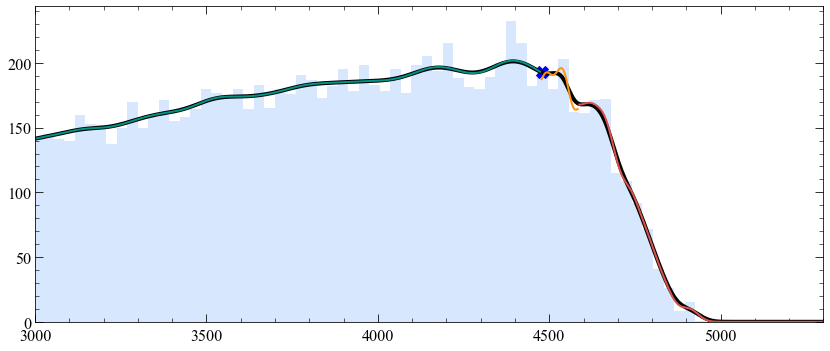

In [1811]:
# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

n_counts    = n_counts
r_bin_edges = r_bin_edges
r_bin_vals  = r_bin_vals


# plot histogram
ax.bar(r_bin_vals, n_counts, width=np.diff(r_bin_edges), \
       color='xkcd:powder blue', alpha=0.5)

# Apply a Gaussian filter to smooth the combined KDE values
kde_vals        = kde_vals_i[r_smooth_vals_i>(hist_range[0]+500)]
r_smooth_vals   = r_smooth_vals_i[r_smooth_vals_i>(hist_range[0]+500)]
sigma           = 4  #if num_bins > 75 else 2
kde_vals_smooth = gaussian_filter1d(kde_vals, sigma=sigma)


combine_val1_index           = np.argmin(np.abs(r_smooth_vals - combine_val1))
combine_val1_r_smooth_val    = r_smooth_vals[combine_val1_index]
combine_val1_n_counts_smooth = kde_vals_smooth[combine_val1_index]

print(f"combine_val1_r_smooth_val    = {combine_val1_r_smooth_val}")
print(f"combine_val1_n_counts_smooth = {combine_val1_n_counts_smooth}")
print()

# Plot joined and smoothed KDE
plt.plot(combine_val1_r_smooth_val, combine_val1_n_counts_smooth, 
         color='b', marker='X', ms=12, label='combined & smoothed')

# Plot joined and smoothed KDE
plt.plot(r_smooth_vals, kde_vals_smooth, lw=4, color='k', label='combined & smoothed')

# plot individual data
plt.plot(r_smooth_vals_i[mask1], kde_vals1[mask1], \
         lw=2, color='xkcd:teal',label=f"bandwidth = {bandwidth1}")
plt.plot(r_smooth_vals_i[mask2], kde_vals2[mask2], \
         lw=2, color='xkcd:tangerine', label=f"bandwidth = {bandwidth2}")
plt.plot(r_smooth_vals_i[mask3], kde_vals3[mask3], \
         lw=2, color='xkcd:pale red', label=f"bandwidth = {bandwidth3}")

plt.xlim(0, 5.6e3)

# peaks_smooth, \
# properties_smooth \
# = find_peaks(kde_vals_smooth, height=0.8 * np.max(kde_vals_smooth), width=1)

# left_ips_smooth_index     = properties_smooth['left_ips'][-1].astype(int)
# left_peak_smooth_r2_vals  = r_smooth_vals[left_ips_smooth_index]
# left_peak_smooth_n_count  = kde_vals_smooth[left_ips_smooth_index]

# r_smooth_val_final_peak   = r_smooth_vals[peaks_smooth][-1]
# n_count_smooth_final_peak = kde_vals_smooth[peaks_smooth][-1]

# print(f"r_smooth_val_final_peak   = {r_smooth_val_final_peak}")
# print(f"n_count_smooth_final_peak = {n_count_smooth_final_peak}")
# print(f"left_peak_smooth_r2_vals  = {left_peak_smooth_r2_vals}")
# print(f"left_peak_smooth_n_count  = {left_peak_smooth_n_count}")

# # Plot the detected peaks
# plt.plot(r_smooth_vals[peaks_smooth], kde_vals_smooth[peaks_smooth], \
#          'xkcd:red', marker='X', ms=12, ls='', label='Peaks')

plt.xlim(3000, 5.3e3)

#### new method attempt on 7/30

dist_peak_to_last_r2 = 489.76248976248917
final_peak_height              = 124.48948948948956
n_counts_avg_before_peak       = 103.86412806858904
1.3 * n_counts_avg_before_peak = 135.02336648916577
1.5 * n_counts_avg_before_peak = 155.79619210288357

multiple_peaks_cond and not big_peak_cond2



(0.0, 151.20420420420427)

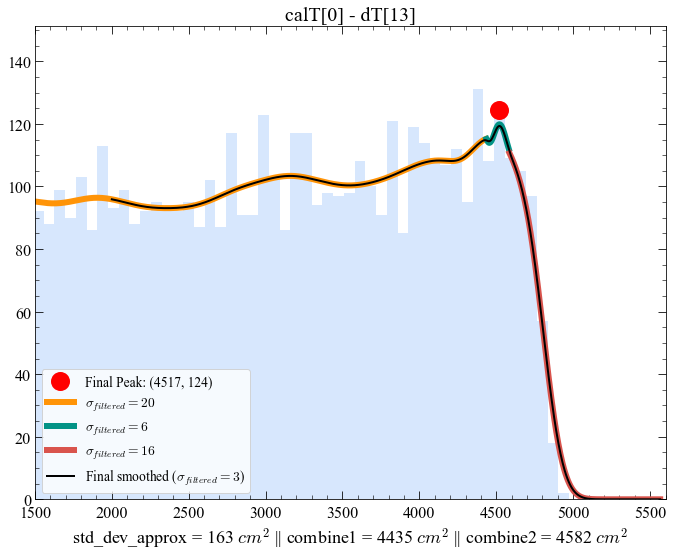

In [60]:
# make mask that removes zeros from r2_bin_vals 
no_zero_counts_mask = n_counts_smooth > 0

# get final nonzero r2_bin_vals value 
r2_smooth_vals_nonzero  = r2_bin_vals_smooth[no_zero_counts_mask]
final_smooth_r2_val     = r2_smooth_vals_nonzero[-1]
n_counts_smooth_nonzero = n_counts_smooth[no_zero_counts_mask]
final_smooth_n_count    = n_counts_smooth_nonzero[-1]

# get approximate standard deviation 
# to use in guessing where bandwidths should change 
dist_peak_to_last_r2    = final_smooth_r2_val - final_peak_r2_val
std_dev_approx          = dist_peak_to_last_r2 / 3

# get average of bins before peak
before_peak_cond         = (r2_smooth_vals_nonzero < (final_peak_r2_val - 0.5 * dist_peak_to_last_r2))\
                            & (r2_smooth_vals_nonzero > (final_peak_r2_val - 3 * dist_peak_to_last_r2))
n_counts_avg_before_peak = np.mean(n_counts_smooth_nonzero[before_peak_cond])
print(f"dist_peak_to_last_r2 = {dist_peak_to_last_r2}")

# define one peak, multiple peaks with pronounced peak masks
one_peak_cond       = len(peak_indices) == 1
multiple_peaks_cond = len(peak_indices)  > 1
big_peak_cond1      = final_peak_height  > 1.5 * n_counts_avg_before_peak
big_peak_cond2      = final_peak_height  > 1.3 * n_counts_avg_before_peak
big_peak_cond       = big_peak_cond1

print(f"final_peak_height              = {final_peak_height}")
print(f"n_counts_avg_before_peak       = {n_counts_avg_before_peak}")
print(f"1.3 * n_counts_avg_before_peak = {1.3 * n_counts_avg_before_peak}")
print(f"1.5 * n_counts_avg_before_peak = {1.5 * n_counts_avg_before_peak}")
print()

# define how many std_dev_approx should be 
# subtracted on the left and added on the right (to the peak r2_val)
if one_peak_cond:
    
    print("one_peak_cond")
    print()
    left_subtract = 1.2  * std_dev_approx
    right_add     = 0.9  * std_dev_approx
    
elif multiple_peaks_cond and big_peak_cond1:
    
    print("multiple_peaks_cond and big_peak_cond1")
    print()
    left_subtract = 0.9  * std_dev_approx
    right_add     = 0.73 * std_dev_approx

elif multiple_peaks_cond and big_peak_cond2 and not big_peak_cond1:
    
    print("multiple_peaks_cond and big_peak_cond2 and not big_peak_cond1")
    print()
    left_subtract = 0.5  * std_dev_approx
    right_add     = 0.6  * std_dev_approx
    
elif multiple_peaks_cond and not big_peak_cond2:
    
    print("multiple_peaks_cond and not big_peak_cond2")
    print()
    left_subtract = 0.5  * std_dev_approx
    right_add     = 0.4  * std_dev_approx
    
else:
    "ERROR:"
    "Something is wrong with one, mult, big peak conditions. "
    print()

# set gaussian filter sigma 
sigma_filter1 = 20
sigma_filter2 = 3 
sigma_filter3 = 8 
sigma_filter2 = sigma_filter2 if num_bins >= 80 else sigma_filter2 * 2
sigma_filter3 = sigma_filter3 if num_bins >= 80 else sigma_filter3 * 2

# set values at which to combine smoothed data 
combine_val1  = final_peak_r2_val - left_subtract
combine_val2  = final_peak_r2_val + right_add

# masks for different regions 
mask_region1 = r2_bin_vals_smooth  < combine_val1
mask_region2 = (combine_val1 <= r2_bin_vals_smooth) & (r2_bin_vals_smooth < combine_val2)
mask_region3 = r2_bin_vals_smooth  >= combine_val2

# smooth n_counts_smooth to different levels
n_smooth1_i = gaussian_filter1d(n_counts_smooth, sigma = sigma_filter1)
n_smooth2_i = gaussian_filter1d(n_counts_smooth, sigma = sigma_filter2)
n_smooth3_i = gaussian_filter1d(n_counts_smooth, sigma = sigma_filter3)

# mask smoothed data to regions
n_smooth1 = n_smooth1_i[mask_region1]
n_smooth2 = n_smooth2_i[mask_region2]
# n_smooth2 = n_counts_smooth[mask_region2]
n_smooth3 = n_smooth3_i[mask_region3]

# join Gaussian KDEs
n_smooth_combined = np.zeros(len(r2_bin_vals_smooth))
n_smooth_combined[mask_region1] = n_smooth1
n_smooth_combined[mask_region2] = n_smooth2
n_smooth_combined[mask_region3] = n_smooth3

# smooth again 
sigma_filter_final = 3 # 15 if multiple_peaks_cond and not big_peak_cond2 else 3 
n_double_smoothed  = gaussian_filter1d(n_smooth_combined, sigma = sigma_filter_final)

# create lim_r2_range_mask to limit r2 values and apply to gauss filtered data 
lim_r2_range_mask = r2_bin_vals_smooth > 2000 #(r2_bin_vals_smooth[0] + 1000)
r2_smooth         = r2_bin_vals_smooth[lim_r2_range_mask]
n_smooth          = n_double_smoothed[lim_r2_range_mask]

# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

# plot histogram
ax.bar(r2_bin_vals, n_counts, width=bin_widths, \
       color='xkcd:powder blue', alpha=0.5)

# plot the final peak 
ax.plot(final_peak_r2_val, final_peak_height, 'ro', ms=16, mew=3,  
        label=f"Final Peak: ({int(final_peak_r2_val)}, {int(final_peak_height)})")

# plot individual smoothed data
ax.plot(r2_bin_vals_smooth[mask_region1], n_smooth1, 
        lw=6, color='xkcd:tangerine',label=f"${{\sigma}}_{{filtered}}={sigma_filter1}$")

# plot individual smoothed data
ax.plot(r2_bin_vals_smooth[mask_region2], n_smooth2, 
        lw=6, color='xkcd:teal',label=f"${{\sigma}}_{{filtered}}={sigma_filter2}$")

# plot individual smoothed data
ax.plot(r2_bin_vals_smooth[mask_region3], n_smooth3, 
        lw=6, color='xkcd:pale red',label=f"${{\sigma}}_{{filtered}}={sigma_filter3}$")

# plot final smoothed data
ax.plot(r2_smooth, n_smooth, 
        lw=2, color='xkcd:black',label=f"Final smoothed (${{\sigma}}_{{filtered}}={sigma_filter_final}$)")

# title
ax.set_title(f"calT[{calT_index}] - dT[{dT_index}]")
ax.set_xlabel(f"std_dev_approx = {int(std_dev_approx)} ${{cm}}^2$ || combine1 = {int(combine_val1)} ${{cm}}^2$ || combine2 = {int(combine_val2)} ${{cm}}^2$")

ax.legend(loc="lower left")
ax.set_xlim(1500, 5600)
ax.set_ylim(0, np.max(n_counts_smooth)+np.max(n_counts_smooth)/6)

### fit

#### method as of 7/29 - functional

##### v0: try something else tarot fit

In [ ]:
max_count_index = np.argmax(n_counts)
min_count_index = np.argmin(r_bin_vals)

gaussian_shape_mask = r_bin_vals > (xbar0-200)

amp0 = n_counts[max_count_index]

xbar0      = r_bin_vals[np.argmax(n_counts)]
_, sigma0  = weighted_avg_and_std(r_bin_vals[gaussian_shape_mask], n_counts[gaussian_shape_mask])


#sigma0     = np.std(r_bin_vals[r_bin_vals > (xbar0-200)])
split_val0 = xbar0
slope0     = (n_counts[max_count_index] - n_counts[min_count_index]) \
            / (r_bin_vals[max_count_index] - r_bin_vals[min_count_index])
intercept0 = n_counts[min_count_index]
p0_tarot   = np.array([amp0, xbar0, sigma0, shift0, slope0, intercept0])

# Define bounds
lower_bounds = [20, xbar0 - 2 * sigma0, 0.5 * sigma0, xbar0 - 3 * sigma0, 0, -200]
upper_bounds = [800, xbar0 + 2 * sigma0, 1.5 * sigma0, xbar0 + 3 * sigma0, 10, 200]

# debug
print(f"amp0       = {np.round(amp0)}")
print(f"xbar0      = {np.round(xbar0)}")
print(f"sigma0     = {np.round(sigma0,2)}")
print(f"split_val0 = {np.round(split_val0,2)}")
print(f"slope0     = {np.round(slope0,2)}")
print(f"intercept0 = {np.round(intercept0)}")
print()

nonzero_mask = n_counts>0
last_nonzero_index = np.argmax(r_bin_vals[nonzero_mask])
nonzero_plus2_mask = r_bin_vals <= r_bin_vals[last_nonzero_index + 2]

r_plot     = r_bin_vals[nonzero_plus2_mask]
n_plot     = n_counts[nonzero_plus2_mask]
sigma_plot = np.sqrt(n_plot) + 1e-6

popt_tarot, pcov_tarot = curve_fit(f_tarot0, r_plot, n_plot, p0_tarot, \
                                   sigma=sigma_plot, absolute_sigma=False, \
                                   bounds=(lower_bounds, upper_bounds))

amp, xbar, sigma, split_val, slope, intercept = popt_tarot 

# debug
print(f"amp       = {np.round(amp,2)}")
print(f"xbar      = {np.round(xbar,2)}")
print(f"sigma     = {np.round(sigma,2)}")
print(f"shift     = {np.round(split_val,2)}")
print(f"slope     = {np.round(slope,4)}")
print(f"intercept = {np.round(intercept,2)}")
print()

r_bins_fine_max      = np.linspace(r_plot[0], r_plot[-1], 1000, endpoint=True)
n_counts_fine_max    = f_tarot0(r_bins_fine_max, *popt_tarot)

# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# plot histogram
ax.bar(r_bin_vals, n_counts, width=np.diff(r_bin_edges), \
       color='xkcd:powder blue', alpha=0.5)

# plot crystal ball function fit attempt
ax.plot(r_bins_fine_max, n_counts_fine_max, '-', linewidth=3, color='xkcd:greeny blue', label='Fitting attempt')
#ax.set_xlim([40,55])
ax.legend()

##### v1: try something else tarot fit (working 7/26)

In [ ]:

# Allow no zeros after N = 0.1
no_zeros_mask    = kde_vals_smooth >= 0.2

# Allow one zero after the first sequence of True values
one_zero_mask       = copy.deepcopy(no_zeros_mask)
# first_zero_index    = np.argmax(~no_zeros_mask)
first_zero_index    = np.argmin(no_zeros_mask)
print(f"first_zero_index = {first_zero_index}")
# if first_zero_index < len(one_zero_mask):
#     one_zero_mask[first_zero_index] = True
one_zero_mask[first_zero_index] = True
    
# Allow two zeros after the first sequence of True values
two_zeros_mask       = copy.deepcopy(one_zero_mask)
second_zero_index    = np.argmax(~one_zero_mask)
print(f"second_zero_index = {second_zero_index}")
# if second_zero_index < len(two_zeros_mask):
#     two_zeros_mask[second_zero_index] = True
two_zeros_mask[second_zero_index] = True
    
r_plot     = r_smooth_vals[two_zeros_mask]
n_plot     = kde_vals_smooth[two_zeros_mask]
sigma_plot = np.sqrt(n_plot)
sigma_plot = np.sqrt(n_plot) + 1e-6

offset_val      = combine_val # - 100
offset          = np.argmax(n_plot[r_plot >= offset_val])
max_count_index = np.where(r_plot >= offset_val)[0][offset] # peaks_smooth[-1] # 
min_count_index = np.argmin(n_plot[r_plot < (r_plot[0] + 500)]) #3500]) 
print(f"min_count_index = {min_count_index}")
min_count_index = np.argmin(r_plot)
print(f"min_count_index = {min_count_index}")
print()
print(f"max count r-val: {r_plot[max_count_index]}")
print(f"n_plot[-1] = {n_plot[-1]}")

print(f"len(np.where(r_plot >= (combine_val - 100))[0]) = {len(np.where(r_plot >= (combine_val - 100))[0])}")
print(f"offset = {offset}")
print()

amp0           = kde_vals_smooth[max_count_index] #n_plot[peaks_smooth][-1]#peak_heights[-1] # 
sub_3500r2_avg = np.mean(n_plot[r_plot<3500])



per_of_height = 2
if sub_3500r2_avg * per_of_height < amp0:
#if len(peaks) == 1:
    print(f"full gaussian")
    print()
    amp0             = n_plot[max_count_index] #  peak_heights[-1]
    r_smooth_val_max = r_plot[-1]
    xbar0            = r_plot[max_count_index]  #  r_bin_vals[peaks][-1]
    sigma0           = (r_smooth_val_max - xbar0) / 3
    print()
    print(f"xbar0      = {np.round(xbar0)}")
    print(f"sigma0     = {np.round(sigma0,2)}")
    print()
    #gauss_shape_start   = xbar0 - 3 * sigma0
    # TRY NOT THE FULL GAUSSIAN SHAPE BECAUSE OF THE LINEAR PART INTERRUPTING
    gauss_shape_start   = xbar0 - 2 * sigma0 
    gaussian_shape_mask = r_plot >= gauss_shape_start
    split_val0          = gauss_shape_start
    
    _, sigma0           = weighted_avg_and_std(r_plot[gaussian_shape_mask], n_plot[gaussian_shape_mask])
    print(f"sigma0     = {np.round(sigma0,2)}")
    slope0              = (   (n_plot[np.argmin(np.abs(r_plot-split_val0))] - n_plot[min_count_index]) \
                            / (r_plot[np.argmin(np.abs(r_plot-split_val0))] - r_plot[min_count_index])  )
    slope0              = 0.0001 if slope0 <= 0.0001 else slope0
    intercept0          = n_plot[min_count_index] 

    # Define bounds
    p0_tarot     = np.array( [      xbar0            ,   sigma0     ,        split_val0         ,  slope0  , intercept0 ])
    lower_bounds =           [ xbar0 - 3.0 * sigma0  , 0.75 * sigma0, split_val0 - 3.00 * sigma0,   0.0001 ,    -200    ] 
    upper_bounds =           [ xbar0 + 3.0 * sigma0  , 2.00 * sigma0, split_val0 + 1.00 * sigma0,   1.000  ,     intercept0+100    ]

else: 
    print(f"gaussian bit")
    print()
    amp0             = n_plot[max_count_index] #  peak_heights[-1]
    r_smooth_val_max = r_plot[-1]
    xbar0          = r_plot[max_count_index] # attempted changed here  #  r_bin_vals[peaks][-1] 
    sigma0         = (r_smooth_val_max - xbar0) / 3#2.5
    print()
    print(f"xbar0      = {np.round(xbar0)}")
    print(f"sigma0     = {np.round(sigma0,2)}")
    print()
    # *** REMOVED -0.5 SIG ***
    gauss_shape_start   = xbar0 - 0.005 * sigma0
    # *** REMOVED -0.5 SIG ***
    split_val0          = gauss_shape_start # xbar0
    gaussian_shape_mask = r_plot >= gauss_shape_start
    _, sigma0        = weighted_avg_and_std(r_plot[gaussian_shape_mask], n_plot[gaussian_shape_mask])
    sigma0              = np.sqrt(sigma0**2 / (1 - 2/np.pi)) # half normal distn
    slope0              = (   (n_plot[np.argmin(np.abs(r_plot-split_val0))] - n_plot[min_count_index]) \
                            / (r_plot[np.argmin(np.abs(r_plot-split_val0))] - r_plot[min_count_index])   )
    slope0              = 0.00001 if slope0 <= 0.00001 else slope0
    intercept0          = n_plot[min_count_index] 

    # *** CHANGED BOUNDS FOR SPLIT_VAL0 FROM (split_val0 - 0.5 * sigma0)
    # Define bounds 
    p0_tarot     = np.array( [        xbar0          ,   sigma0     ,        split_val0        ,  slope0  , intercept0 ])
    lower_bounds =           [ xbar0 - 4.0 * sigma0  , 0.98 * sigma0, split_val0 - 2.0 * sigma0,   0.00001 ,     10     ] 
    upper_bounds =           [ xbar0 + 1.0 * sigma0  , 3.00 * sigma0, split_val0 + 0.4 * sigma0,   1.000  ,     intercept0+100    ]

print(f"amp0                 = {amp0}")
print(f"sub_3500r2_avg       = {sub_3500r2_avg}")
print(f"sub_3500r2_avg * {per_of_height} = {sub_3500r2_avg * per_of_height}")
print(f"gauss_shape_start    = {gauss_shape_start}")
print(f"split_val0           = {np.round(split_val0,2)}")
print()


# Check each initial parameter against its bounds
for i, (p0, lb, ub) in enumerate(zip(p0_tarot, lower_bounds, upper_bounds)):
    if not (lb <= p0 <= ub):
        print(f"Initial parameter {i} (value: {p0}) is out of bounds [{lb}, {ub}]")


# debug
print(f"xbar0      = {np.round(xbar0)}")
print(f"sigma0     = {np.round(sigma0,2)}")
print(f"split_val0 = {np.round(split_val0,2)}")
print(f"slope0     = {np.round(slope0,4)}")
print(f"intercept0 = {np.round(intercept0,4)}")
print()


print()
print(f"n_plot[-1] = {n_plot[-1]}")

popt_tarot, pcov_tarot = curve_fit(f_tarot0, r_plot, n_plot, p0_tarot, \
                                   sigma=sigma_plot, absolute_sigma=True, \
                                   bounds=(lower_bounds, upper_bounds))

# extract paramters from popt_tarot
mu, sig, split, m, b = popt_tarot 

# extract paramters from pcov_tarot
unc_mu    = np.sqrt(pcov_tarot[0, 0])
unc_sig   = np.sqrt(pcov_tarot[1, 1])
unc_split = np.sqrt(pcov_tarot[2, 2])
unc_m     = np.sqrt(pcov_tarot[3, 3])
unc_b     = np.sqrt(pcov_tarot[4, 4])

# debug
print(f"mu    = {np.round(mu,2)}")
print(f"sig   = {np.round(sig,2)}")
print(f"split = {np.round(split,2)}")
print(f"m     = {np.round(m,4)}")
print(f"b     = {np.round(b,4)}")
print()
print(f"unc_mu    = {np.round(unc_mu,2)}")
print(f"unc_sig   = {np.round(unc_sig,2)}")
print(f"unc_split = {np.round(unc_split,6)}")
print(f"unc_m     = {np.round(unc_m,4)}")
print(f"unc_b     = {np.round(unc_b,4)}")
print()

r_bins_fine_max      = np.linspace(r_plot[0], r_plot[-1], 1000, endpoint=True)
n_counts_fine_max    = f_tarot0(r_bins_fine_max, *popt_tarot)

# get height
height_point_index   = np.argmax(n_counts_fine_max)
height_point_r2_bin  = r_bins_fine_max[height_point_index]
height_point_n_count = n_counts_fine_max[height_point_index]

# get partial derivatives of gaussian part at max count (height) to get uncertainty in max count (height)
dTarot_dMu, \
dTarot_dSig, \
dTarot_dSplit, \
dTarot_dM, \
dTarot_dB         = f_tarot_partial_derivs_at_max(height_point_r2_bin, mu, sig, split, m, b)

# get height and uncertainty
r2_at_height = height_point_r2_bin
height       = height_point_n_count
d_height     = np.sqrt(    dTarot_dMu**2    * unc_mu**2 \
                         + dTarot_dSig**2   * unc_sig**2 \
                         + dTarot_dSplit**2 * unc_split**2 \
                         + dTarot_dM**2     * unc_m**2 \
                         + dTarot_dB**2     * unc_b**2       )

# get half height and uncertainty
hh   = height   / 2
d_hh = d_height / 2

# debug
print(f"r2_at_height = {r2_at_height}")
print(f"height       = {height}")
print(f"d_height     = {d_height}")
print(f"hh           = {hh}")
print(f"d_hh         = {d_hh}")

# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# plot histogram
ax.bar(r_bin_vals, n_counts, width=np.diff(r_bin_edges), \
       color='xkcd:powder blue', alpha=0.5)

# plot smoothed line
plt.plot(r_smooth_vals, kde_vals_smooth, lw=1, color='xkcd:cornflower blue', label='smoothed')

# plot tarot function fit attempt
ax.plot(r_bins_fine_max, n_counts_fine_max, '-', linewidth=3, color='xkcd:greeny blue', label='Fitting attempt')

# plot half height constant line 
hh_plot = np.full_like(r_bin_vals, hh) # array with the same length as bin_centers, where every value = hh
ax.plot(r_bin_vals, hh_plot, '-', linewidth=3, zorder=3, color='xkcd:dark cyan') #, label='Half Height')

# plot max height point
ax.errorbar(r2_at_height, height, yerr=d_height, zorder=1, \
            fmt='o', markersize=4, capsize=6, capthick=2, lw=3, color='xkcd:greeny blue', \
            label=f"Fitted height point: ({int(np.round(r2_at_height))} ${{cm}}^2$, "\
                  f"{int(np.round(height))})")

# Plot the detected peaks
plt.plot(r_bin_vals[peaks], n_counts[peaks], 'rx', label='Peaks')


ax.set_xlim([3000,5500])
#ax.set_ylim([-5,70])
ax.legend()

##### v2: try something else tarot fit

In [1812]:
# rename hist stuff to match 
n_counts     = n_counts
r2_bin_edges = r_bin_edges
r2_bin_vals  = r_bin_vals
bin_widths   = bin_widths
peak_indices = peaks

# get peak values 
peak_r2_vals = r2_bin_vals[peak_indices]
peak_heights = n_counts[peak_indices]

# make mask that removes zeros from r2_bin_vals 
no_zero_counts_mask = n_counts > 0

# get final nonzero r2_bin_vals value 
r2_bin_vals_nonzero = r2_bin_vals[no_zero_counts_mask]
final_bin_r2_val    = r2_bin_vals_nonzero[-1]
final_bin_n_counts  = n_counts_nonzero[-1]

# get final (or only) peak r2 and count values 
final_peak_r2_val = peak_r2_vals[-1]
final_peak_height = peak_heights[-1]


# prep smoothed stuff

# rename variables to match main notebook (get all wall points nb)
r2_smooth_vals  = r_smooth_vals
n_smooth_vals   = kde_vals_smooth

# create mask to remove all but two "zero" n_smooth_vals (where n_smooth_vals is very small)
no_zeros_smooth_mask           = n_smooth_vals >= 0.2
one_zero_smooth_mask           = copy.deepcopy(no_zeros_smooth_mask)
i_1st_0                        = np.argmin(no_zeros_smooth_mask)
one_zero_smooth_mask[i_1st_0]  = True
two_zeros_smooth_mask          = copy.deepcopy(one_zero_smooth_mask)
i_2nd_0                        = np.argmin(one_zero_smooth_mask)
two_zeros_smooth_mask[i_2nd_0] = True

# declare values to be fitted by f_tarot
r2_to_fit    = r2_smooth_vals[two_zeros_smooth_mask]
n_to_fit     = n_smooth_vals[two_zeros_smooth_mask]
sigma_to_fit = np.sqrt(n_to_fit) + 1e-6

# create mask to search for minimum n_to_fit value where r2_to_fit is limited
# indices which pass mask are the same as original indices
# find min n_to_fit value index
search_for_min_val  = r2_to_fit[0] + 500
search_for_min_mask = r2_to_fit < search_for_min_val
n_min_index         = 0
print(f"search_for_min_val = {search_for_min_val}")
print()
print(f"n_min_index = {n_min_index}")

# create mask to search for "maximum" n_to_fit value where r2_to_fit is limited
# find indices which pass mask
# find max n_to_fit value index
search_for_max_mask    = r2_to_fit >= combine_val1
passes_SFMmask_indices = np.where(search_for_max_mask)[0]
n_max_index_masked     = np.argmax(n_to_fit[search_for_max_mask])
n_max_index            = passes_SFMmask_indices[n_max_index_masked]

# min and max n_to_fit value info
r2_at_n_min = r2_to_fit[n_min_index]
n_min       = np.mean(n_to_fit[search_for_min_mask])
r2_at_n_max = r2_to_fit[n_max_index]
n_max       = n_to_fit[n_max_index]

# last r2_to_fit value
r2_to_fit_last_val = r2_to_fit[-1]
n_to_fit_last_val  = n_to_fit[-1]

# # get average count value where r2 < 3500
# n_to_fit_avg_before_peak = np.mean(n_to_fit[(r2_to_fit < 3500) & (r2_to_fit >= 1500)])

# *** CHANGE ***

# get average count value where r2 < 3500
n_to_fit_avg_before_peak = np.mean(n_to_fit[(r2_to_fit < (final_peak_r2_val - (final_bin_r2_val - final_peak_r2_val))) \
                                            & (r2_to_fit > r2_to_fit[0] + 500)])

# *** CHANGE ***
avg_to_peak_ratio = 1.25 if num_bins < 100 else 1.5
# declare condition to use for multiple peak situation with pronounced final peak
big_final_smooth_peak_cond = n_count_last_peak > avg_to_peak_ratio * n_to_fit_avg_before_peak

print(f"BIG FINAL PEAK CONDITION:")
print()
print(f"n_count_last_peak               = {n_count_last_peak}")
print(f"                         >")
print(f"{avg_to_peak_ratio} * n_to_fit_avg_before_peak = {avg_to_peak_ratio * n_to_fit_avg_before_peak}")
print(f"")
print(f"where n_to_fit_avg_before_peak  = {n_to_fit_avg_before_peak}")
print()
print()
print(f"For this to have a Big Final Peak, the maximum average before the peak would be:")
print()
print(f"n_count_last_peak / {avg_to_peak_ratio}        = {n_count_last_peak / avg_to_peak_ratio}")

# combine_val1 location in fitting data  
combine_val1_index     = np.argmin(np.abs(r2_to_fit - combine_val1))
combine_val1_r2_to_fit = r2_to_fit[combine_val1_index]
combine_val1_n_to_fit  = n_to_fit[combine_val1_index]

print()
print()
print(f"r2_at_n_max = {r2_at_n_max}")
print(f"n_max       = {n_max}")
print()
print(f"combine_val1_r2_to_fit = {combine_val1_r2_to_fit}")
print(f"combine_val1_n_to_fit  = {combine_val1_n_to_fit}")
print()

# transition value
one_peak_trans_cond       = len(peak_indices) == 1
big_final_peak_trans_cond = big_final_smooth_peak_cond and not one_peak_trans_cond

if one_peak_trans_cond:
    print(f"* ONE PEAK *")
    trans_factor = 0.9  
elif big_final_peak_trans_cond: 
    print(f"* PRONOUNCED PEAK *")
    trans_factor = 0.6 
else:
    print(f"* MULTIPLE PEAKS *")
    trans_factor = 0.2


print()  
dist_combine1_to_n_max = r2_at_n_max - combine_val1_r2_to_fit
trans_val_r2_to_fit    = r2_at_n_max - trans_factor * dist_combine1_to_n_max 
trans_val_index        = np.argmin(np.abs(r2_to_fit - trans_val_r2_to_fit))
trans_val_n_to_fit     = n_to_fit[trans_val_index]
# trans_val_r2_to_fit    = r2_to_fit[trans_val_index]
print(f"dist_combine1_to_n_max = {dist_combine1_to_n_max}")
print(f"trans_val_r2_to_fit    = {trans_val_r2_to_fit}")
print(f"trans_val_n_to_fit     = {trans_val_n_to_fit}")
print()

search_for_min_val = 2000.1675171875977

n_min_index = 0
BIG FINAL PEAK CONDITION:

n_count_last_peak               = 203
                         >
1.5 * n_to_fit_avg_before_peak = 223.19514053987032

where n_to_fit_avg_before_peak  = 148.79676035991355


For this to have a Big Final Peak, the maximum average before the peak would be:

n_count_last_peak / 1.5        = 135.33333333333334


r2_at_n_max = 4477.781356185287
n_max       = 192.7177878665009

combine_val1_r2_to_fit = 4477.781356185287
combine_val1_n_to_fit  = 192.7177878665009

* MULTIPLE PEAKS *

dist_combine1_to_n_max = 0.0
trans_val_r2_to_fit    = 4477.781356185287
trans_val_n_to_fit     = 192.7177878665009



num_sig_of_final_n_val = 3.835

mu0  = 4477.781356185287
sig0 initial = 135.96491913783674

n_max <= trans_val_n_to_fit
len(gh_mms)              = 600
n_max                    = 192.7177878665009
n_max_of_fitted          = 192.35101535875856
trans_val_n_to_fit       = 192.7177878665009

sig0 initial = 135.96491913783674

num_sigmas_before = 0.005


    ~* multiple peaks *~
             &            
~* no pronounced final peak *~


split_size = 0.6798245956891837
mu0    = 4477.781356185287
sig0   = 135.96491913783674
split0 = 4477.101531589598
m0     = 0.03198728515343112
b0     = 97.47200492167907

Initial parameter 0 (value: 4477.781356185287) has bounds [4477.509426347012, 4749.7111944609605]

Initial parameter 1 (value: 135.96491913783674) has bounds [81.57895148270204, 407.8947574135102]

Initial parameter 2 (value: 4477.101531589598) has bounds [4476.4217069939095, 4477.373461427874]

Initial parameter 3 (value: 0.03198728515343112) has bounds [0.0001, 1.0]

Initial parameter 4 (

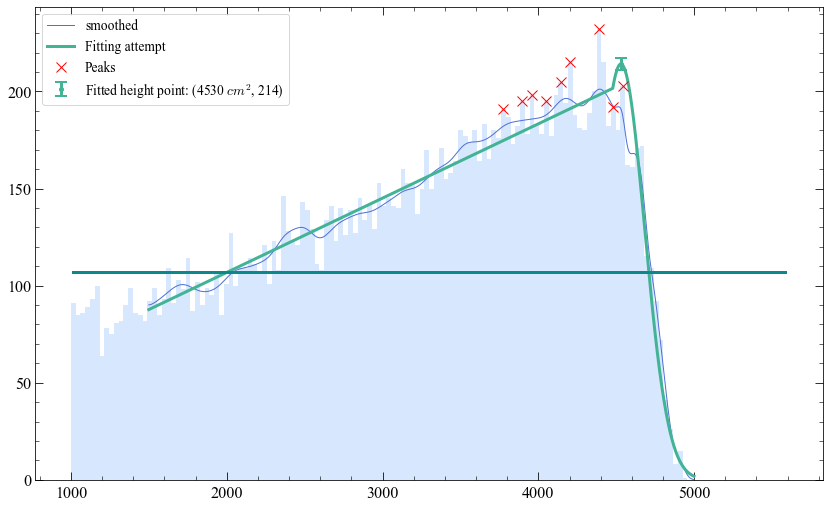

In [1813]:
num_sigmas                = np.arange(0, 6.0, 0.01)
gauss_height_amp1         = f_gaussian_val((num_sigmas), 1, 0, 1)
gh_a1                     = gauss_height_amp1
final_n_val_to_peak_ratio = n_to_fit_last_val / n_max
fntpr                     = final_n_val_to_peak_ratio
idx_before                = np.where((gh_a1[:-1] >= fntpr) & (gh_a1[1:] <= fntpr))[0]
idx_btwn                  = [[index, index + 1] for index in idx_before][0]
num_sig_of_final_n_val    = np.mean(num_sigmas[idx_btwn])
print(f"num_sig_of_final_n_val = {num_sig_of_final_n_val}")
print()

# parameters: gaussian mean and std dev 
mu0  = r2_at_n_max
sig0 = (r2_to_fit_last_val - r2_at_n_max) / num_sig_of_final_n_val #3 
print(f"mu0  = {mu0}")
print(f"sig0 initial = {sig0}")
print()

if n_max > trans_val_n_to_fit:
    
    print(f"n_max > trans_val_n_to_fit")
    
    # height of gaussian of mu0, sig0 at different x positions
    sigmas                       = sig0 * num_sigmas
    gauss_height_mu_minus_sigmas = f_gaussian_val((mu0 - sigmas), n_max, mu0, sig0)
    gh_mms                       = gauss_height_mu_minus_sigmas
    gh_mms_max_index             = 0
    gh_mms_max_plus_one_index    = 1
    gh_mms_max                   = gh_mms[gh_mms_max_index]
    gh_mms_max_plus_one          = gh_mms[gh_mms_max_plus_one_index]

    # find indices of gauss_height_mu_minus_sigmas (gh_mms) 
    # which correspond to the two closest values to n_to_fit_avg_before_peak
    # Find the indices where n_to_fit_avg_before_peak lies between
    print(f"len(gh_mms)                       = {len(gh_mms)}")
    print()
    print(f"n_max                             = {n_max}")
    print(f"r2_at_n_max                       = {r2_at_n_max}")
    print(f"r2_to_fit_last_val                = {r2_to_fit_last_val}")
    print(f"combine_val1_n_counts_smooth      = {trans_val_n_to_fit}")
    print()

    
    # Initial condition check
    if (n_max - trans_val_n_to_fit) <= (gh_mms_max - gh_mms_max_plus_one):
        
        index_before = [0]
    else:
        index_before = np.where((gh_mms[:-1] >= trans_val_n_to_fit) & (gh_mms[1:] <= trans_val_n_to_fit))[0]

    print(f"index_before = {index_before}")
    indices_between = [[index, index + 1] for index in index_before][0]
    print(f"indices_between = {indices_between}")

    num_sigmas_before   = np.mean(num_sigmas[indices_between])
    
    
    print(f"num_sigmas_before = {num_sigmas_before}")
    print()
    # ***** WEIRDNESS WITH NUM_SIGMAS HWY IS NUMBER 0.215 , SHOULDN'T IT BE 0.0015
    print()
else: 
    
    print(f"n_max <= trans_val_n_to_fit")
    
    # height of gaussian of mu0, sig0 at different x positions
    sigmas                       = sig0 * num_sigmas
    _,n_max_of_fitted_index,_    = find_max_min_index_from_data_subset(r2_to_fit, n_to_fit, rel_val=trans_val_r2_to_fit)
    n_max_of_fitted              = n_to_fit[n_max_of_fitted_index]
    r2_at_n_max_of_fitted        = r2_to_fit[n_max_of_fitted_index]
    gauss_height_mu_minus_sigmas = f_gaussian_val((mu0 - sigmas), n_max_of_fitted, mu0, sig0)
    gh_mms                       = gauss_height_mu_minus_sigmas
    gh_mms_max_index             = np.argmax(gh_mms)
    gh_mms_max_plus_one_index    = gh_mms_max_index + 1
    gh_mms_max                   = gh_mms[gh_mms_max_index]
    gh_mms_max_plus_one          = gh_mms[gh_mms_max_plus_one_index]

    # find indices of gauss_height_mu_minus_sigmas (gh_mms) 
    # which correspond to the two closest values to n_to_fit_avg_before_peak
    # Find the indices where n_to_fit_avg_before_peak lies between
    print(f"len(gh_mms)              = {len(gh_mms)}")
    print(f"n_max                    = {n_max}")
    print(f"n_max_of_fitted          = {n_max_of_fitted}")
    print(f"trans_val_n_to_fit       = {trans_val_n_to_fit}")
    print()

#     # Initial condition check
#     if np.abs(n_max_of_fitted - n_max) < (gh_mms_max - gh_mms_max_minus_one):
#         index_before = [gh_mms_max_minus_one_index]
#     else:
#         index_before = np.where((gh_mms[:-1] >= n_to_fit_avg_before_peak) & (gh_mms[1:] <= n_to_fit_avg_before_peak))[0]

    
    # Initial condition check
    if (n_max_of_fitted - n_max) <= (gh_mms_max - gh_mms_max_plus_one):
        index_before      = [0]
        indices_between   = [[index, index + 1] for index in index_before][0]
        
        
    else:
        index_before      = np.where((gh_mms[:-1] >= n_max) & (gh_mms[1:] <= n_max))[0]
        indices_between   = [[index, index + 1] for index in index_before][0]

    num_sigmas_before = np.mean(num_sigmas[indices_between])
    # mu0               = r2_at_n_max_of_fitted
    # sig0              = (r2_to_fit_last_val - r2_at_n_max_of_fitted) / num_sig_of_final_n_val

    print(f"sig0 initial = {sig0}")
    print()
    
    # num_sigmas=0
    print(f"num_sigmas_before = {num_sigmas_before}")
    print()
    print()

# # height of gaussian of mu0, sig0 at different x positions
# sigmas                       = sig0 * num_sigmas
# gauss_height_mu_minus_sigmas = f_gaussian_val((mu0 - sigmas), n_max, mu0, sig0)
# gh_mms                       = gauss_height_mu_minus_sigmas
# gh_mms_max_minus_one_index   = np.argmax(gh_mms)
# gh_mms_max                   = gh_mms[gh_mms_max_minus_one_index]




# # find indices of gauss_height_mu_minus_sigmas (gh_mms) 
# # which correspond to the two closest values to n_to_fit_avg_before_peak
# # Find the indices where n_to_fit_avg_before_peak lies between
# print(f"gh_mms_max               = {gh_mms_max}")
# print(f"n_max                    = {n_max}")
# print(f"n_to_fit_avg_before_peak = {n_to_fit_avg_before_peak}")
# print()

# # # Check transition around the start
# # if gh_mms[0] >= n_max and gh_mms[1] <= n_max:
# #     index_before = [0]

# # # Check transition around the end
# # if gh_mms[-2] >= n_max and gh_mms[-1] <= n_max:
# #     index_before.append(len(gh_mms) - 2)

# if n_max > n_to_fit_avg_before_peak:
#     # Initial condition check
#     if n_max - n_to_fit_avg_before_peak < gh_mms[gh_mms_max_minus_one_index]:
#         print(f"gh_mms[0] = {gh_mms[0]}")
#         print(f"gh_mms[1] = {gh_mms[1]}")
#         index_before = [1]
#     else:
#         index_before = np.where((gh_mms[:-1] >= n_to_fit_avg_before_peak) & (gh_mms[1:] <= n_to_fit_avg_before_peak))[0]

#     print(f"index_before = {index_before}")
#     indices_between = [[index, index + 1] for index in index_before][0]
#     print(f"indices_between = {indices_between}")

#     num_sigmas   = np.mean(num_sigmas[indices_between])
    
    
#     print(f"num_sigmas = {num_sigmas}")
#     print()
#     # ***** WEIRDNESS WITH NUM_SIGMAS HWY IS NUMBER 0.215 , SHOULDN'T IT BE 0.0015
#     print()
# else:
    
#     # height of gaussian of mu0, sig0 at different x positions
#     sigmas                       = sig0 * num_sigmas
#     n_max_of_fitted              = np.max(n_to_fit[r2_to_fit > (r2_at_n_max - 500)])
#     gauss_height_mu_minus_sigmas = f_gaussian_val((mu0 - sigmas), n_max_of_fitted, mu0, sig0)
#     gh_mms                       = gauss_height_mu_minus_sigmas

#     # Initial condition check
#     if n_max - n_to_fit_avg_before_peak < gh_mms[gh_mms_max_minus_one_index]:
#         print(f"gh_mms[0] = {gh_mms[0]}")
#         print(f"gh_mms[1] = {gh_mms[1]}")
#         index_before    = [0]
#         indices_between = [[index, index + 1] for index in index_before][0]
#         num_sigmas      = np.mean(num_sigmas[indices_between])
#         split0          = mu0 - sig0 * num_sigmas
#     else:
#         index_before   = np.where((gh_mms[:-1] >= n_max) & (gh_mms[1:] <= n_max))[0]
#         indices_between = [[index, index + 1] for index in index_before][0]
#         num_sigmas      = np.mean(num_sigmas[indices_between])
#         split0          = mu0 + sig0 * num_sigmas
#     # index_before    = np.where((gh_mms[:-1] >= n_max) & (gh_mms[1:] <= n_max))[0]
#     indices_between = [[index, index + 1] for index in index_before][0]
#     print(f"indices_between = {indices_between}")

    
    
#     # num_sigmas=0
#     print(f"num_sigmas = {num_sigmas}")
#     print()
#     print()

# partial Gaussian shape
if len(peak_indices) > 1: 
    print(f"    ~* multiple peaks *~")
    print(f"             &            ")
    
    if big_final_smooth_peak_cond:
        print(f" ~* pronounced final peak *~ ")
        print()
        print()
        
        # parameter:  split value
        split_size   = sig0 * num_sigmas_before
        split0       = mu0 - split_size
        print(f"split_size = {split_size}")
        split0_index = np.argmin(np.abs(r2_to_fit - split0))
        # split_mask   = r2_to_fit < split0

        # parameters: linear
        m0 = (n_to_fit[split0_index] - n_min) / (r2_to_fit[split0_index] - r2_at_n_min)
        m0 = m0 if m0 > 0.0001 else 0.0001
        b0 = n_min

        
        # # parameter: gaussian std dev
        # _, sig0    = weighted_avg_and_std(r2_to_fit[~split_mask], n_to_fit[~split_mask])
        # sig0       = np.sqrt(sig0**2 / (1 - 2/np.pi)) # weighted std dev to gaussian std dev

        # give bounds to parameters
        p0_tarot     = np.array([       mu0       ,     sig0   ,       split0       ,   m0   ,     b0    ])
        # lower_bounds =          [ mu0 - 0.5 * sig0, 0.90 * sig0, split0 - 0.1 * sig0, 0.0001 ,  0        ]
        # upper_bounds =          [ mu0 + 2.0 * sig0, 1.20 * sig0, split0 + 1.5 * sig0, 1.0    ,  b0 + 100 ]
        # lower_bounds =          [ mu0 - 3.0 * sig0, 0.90 * sig0, split0 - 3.0 * sig0, 0.0001 ,  0        ]
        # upper_bounds =          [ mu0 + 0.1 * sig0, 2.00 * sig0, split0 + 1.0 * sig0, 1.0    ,  b0 + 100 ]
        lower_bounds =          [ mu0 - 0.4 * split_size, 0.60 * sig0, split0 - split_size, 0.0001 ,  0        ]
        upper_bounds =          [ mu0 + 2.0 * sig0       , 3.00 * sig0, split0 + 0.5 * split_size, 1.0    ,  b0 + 100 ]
        
    else: 
        print(f"~* no pronounced final peak *~")
        print()
        print()
                #### #
        
        # parameter:  split value
        split_size   = sig0 * num_sigmas_before
        # split_size   = split_size if split_size > 10 else 10
        split0       = mu0 - split_size
        print(f"split_size = {split_size}")
        # split0       = mu0 + 0.01 * sig0
        split0_index = np.argmin(np.abs(r2_to_fit - split0))
        split_mask   = r2_to_fit < split0

        # parameters: linear
        m0 = (n_to_fit[split0_index] - n_min) / (r2_to_fit[split0_index] - r2_at_n_min)
        m0 = m0 if np.abs(m0 > 0.0001) else 0.0001
        b0 = n_min

        # # parameter: gaussian std dev
        # print(f"1. sig0 = {sig0}")
        # _, sig0    = weighted_avg_and_std(r2_to_fit[~split_mask], n_to_fit[~split_mask])
        # print(f"2. sig0 = {sig0}")
        # sig0       = np.sqrt(sig0**2 / (1 - 2/np.pi)) # weighted std dev to gaussian std dev
        # print(f"3. sig0 = {sig0}")

        # *** CHANGE ***
        # give bounds to parameters
        p0_tarot     = np.array([       mu0       ,     sig0   ,       split0       ,   m0   ,     b0    ])
        # lower_bounds =          [ mu0 - 4.0 * sig0, 0.98 * sig0, split0 - 0.4 * sig0, 0.0001 ,  0        ]
        # upper_bounds =          [ mu0 + 2.0 * sig0, 3.00 * sig0, split0 + 0.4 * sig0, 1.0    ,  b0 + 100 ]
        # *** CHANGE ***
        # lower_bounds =          [ mu0 - 4.0 * sig0, 0.60 * sig0, split0 - 2.0 * sig0, 0.0001 ,  0        ]
        # upper_bounds =          [ mu0 + 2.0 * sig0, 3.00 * sig0, split0 + 1.0 * sig0, 1.0    ,  b0 + 100 ]   
        
        # give bounds to parameters
        p0_tarot     = np.array([          mu0           ,     sig0   ,       split0       ,   m0   ,     b0    ])
        lower_bounds =          [ mu0 - 0.4 * split_size, 0.60 * sig0, split0 - split_size, 0.0001 ,  0        ]
        upper_bounds =          [ mu0 + 2.0 * sig0       , 3.00 * sig0, split0 + 0.4 * split_size, 1.0    ,  b0 + 100 ]

# full Gaussian shape
else: 
    print(f"~* one peak *~")
    print()
    print()
    
    # parameter:  split value 
    split0       = mu0 - sig0 * num_sigmas_before
    split0_index = np.argmin(np.abs(r2_to_fit - split0))

    # parameters: linear
    m0 = (n_to_fit[split0_index] - n_min) / (r2_to_fit[split0_index] - r2_at_n_min)
    m0 = m0 if m0 > 0.0001 else 0.0001
    b0 = n_min

    # give bounds to parameters
    p0_tarot     = np.array([       mu0       ,     sig0   ,       split0       ,   m0   ,    b0     ])
    # lower_bounds =          [ mu0 - 0.5 * sig0, 0.75 * sig0, split0 - 1.0 * sig0, 0.0001 ,  0        ]
    # upper_bounds =          [ mu0 + 0.1 * sig0, 2.00 * sig0, split0 + 1.0 * sig0, 1.0    ,  b0 + 100 ]
    lower_bounds =          [ mu0 - 0.4 * split_size, 0.60 * sig0, split0 - split_size, 0.0001 ,  0        ]
    upper_bounds =          [ mu0 + 2.0 * sig0       , 3.00 * sig0, split0 + 0.5 * split_size, 1.0    ,  b0 + 100 ]
        
# debug
print(f"mu0    = {mu0}")
print(f"sig0   = {sig0}")
print(f"split0 = {split0}")
print(f"m0     = {m0}")
print(f"b0     = {b0}")
print()


for i, (p0, lb, ub) in enumerate(zip(p0_tarot, lower_bounds, upper_bounds)):
                print(f"Initial parameter {i} (value: {p0}) has bounds [{lb}, {ub}]")
                print()

# do the fit 
popt_tarot, pcov_tarot = curve_fit(f_tarot0, r2_to_fit, n_to_fit, p0_tarot, \
                                   sigma=sigma_to_fit, absolute_sigma=True, \
                                   bounds=(lower_bounds, upper_bounds))#, method='dogbox')

print("popt_tarot:", popt_tarot)
print()


# extract paramters from popt_tarot
mu, sig, split, m, b = popt_tarot

# debug
print(f"mu     = {mu}")
print(f"sig    = {sig}")
print(f"split  = {split}")
print(f"m      = {m}")
print(f"b      = {b}")
print()

# extract paramters from pcov_tarot
unc_mu    = np.sqrt(pcov_tarot[0, 0])
unc_sig   = np.sqrt(pcov_tarot[1, 1])
unc_split = np.sqrt(pcov_tarot[2, 2])
unc_m     = np.sqrt(pcov_tarot[3, 3])
unc_b     = np.sqrt(pcov_tarot[4, 4])

# get finer bins
r2_height_fit = np.linspace(r2_to_fit[0], r2_to_fit[-1], 1000, endpoint=True)
n_height_fit  = f_tarot0(r2_height_fit, *popt_tarot)  
print("r2_height_fit[900:905]:", r2_height_fit[900:905])
print("n_height_fit[900:905]:", n_height_fit[900:905])
print()

# get height
height_index = np.argmax(n_height_fit)
r2_at_height = r2_height_fit[height_index]
height       = n_height_fit[height_index]


# get partial derivatives of gaussian part at max count (height) to get uncertainty in max count (height)
# will still work if max count is in linear part because the linear fit has to give positive slope 
# i.e. works because last point of linear = first point of gaussian
dTarot_dMu, \
dTarot_dSig, \
dTarot_dSplit, \
dTarot_dM, \
dTarot_dB        = f_tarot_partial_derivs_at_max(r2_at_height, mu, sig, split, m, b)

# get height uncertainty
d_height = np.sqrt(   dTarot_dMu**2    * unc_mu**2 \
                    + dTarot_dSig**2   * unc_sig**2 \
                    + dTarot_dSplit**2 * unc_split**2 \
                    + dTarot_dM**2     * unc_m**2 \
                    + dTarot_dB**2     * unc_b**2      )

print(f"height_index = {height_index}")
print(f"r2_at_height = {r2_at_height}")
print(f"height       = {height}")
print(f"d_height     = {d_height}")

# get half height and uncertainty
hh_tarot_fitted   = height   / 2
d_hh_tarot_fitted = d_height / 2
hh   = hh_tarot_fitted
d_hh = d_hh_tarot_fitted

# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(15, 9))

# plot histogram
ax.bar(r2_bin_vals, n_counts, width=np.diff(r2_bin_edges), \
       color='xkcd:powder blue', alpha=0.5)

# plot smoothed line
ax.plot(r2_to_fit, n_to_fit, lw=1, color='xkcd:cornflower blue', label='smoothed')

# plot tarot function fit attempt
ax.plot(r2_height_fit, n_height_fit, '-', linewidth=3, color='xkcd:greeny blue', label='Fitting attempt')

# plot half height constant line 
hh_plot = np.full_like(r2_bin_vals, hh) # array with the same length as bin_centers, where every value = hh
ax.plot(r_bin_vals, hh_plot, '-', linewidth=3, zorder=3, color='xkcd:dark cyan') #, label='Half Height')

# plot max height point
ax.errorbar(r2_at_height, height, yerr=d_height, zorder=1, \
            fmt='o', markersize=4, capsize=6, capthick=2, lw=3, color='xkcd:greeny blue', \
            label=f"Fitted height point: ({int(np.round(r2_at_height))} ${{cm}}^2$, "\
                  f"{int(np.round(height))})")

# Plot the detected peaks
ax.plot(r2_bin_vals[peak_indices], n_counts[peak_indices], 'rx', label='Peaks')

#ax.set_xlim([3000,5500])
#ax.set_ylim([-5,np.max(n_to_fit)+20])
ax.legend()

In [62]:
num_sigmas                = np.arange(0.2, 4.0, 0.01)
gauss_height_amp1         = f_gaussian_val((num_sigmas), 1, 0, 1)
gh_a1                     = gauss_height_amp1
final_n_val_to_peak_ratio = n_to_fit_last_val / n_max
fntpr                     = final_n_val_to_peak_ratio
idx_before                = np.where((gh_a1[:-1] >= fntpr) & (gh_a1[1:] <= fntpr))[0]
idx_btwn                  = [[index, index + 1] for index in idx_before][0]
num_sig_of_final_n_val    = np.mean(num_sigmas[idx_btwn])
print(f"num_sig_of_final_n_val = {num_sig_of_final_n_val}")
print()

# parameters: gaussian mean and std dev 
mu0  = r2_at_n_max
sig0 = (r2_to_fit_last_val - r2_at_n_max) / num_sig_of_final_n_val#3 
print(f"mu0  = {mu0}")
print(f"sig0 initial = {sig0}")
print()

# height of gaussian of mu0, sig0 at different x positions
sigmas                       = sig0 * num_sigmas
gauss_height_mu_minus_sigmas = f_gaussian_val((mu0 - sigmas), n_max, mu0, sig0)
gh_mms                       = gauss_height_mu_minus_sigmas
# print(f"gauss height at mu minus sigmas = {gh_mms}")
# print()

# find indices of gauss_height_mu_minus_sigmas (gh_mms) 
# which correspond to the two closest values to n_to_fit_avg_before_peak
# Find the indices where n_to_fit_avg_before_peak lies between
if n_max > n_to_fit_avg_before_peak:
    index_before    = np.where((gh_mms[:-1] >= n_to_fit_avg_before_peak) & (gh_mms[1:] <= n_to_fit_avg_before_peak))[0]
    indices_between = [[index, index + 1] for index in index_before][0]
    print(f"indices_between = {indices_between}")

    num_sigmas = np.mean(num_sigmas[indices_between])
    print(f"num_sigmas = {num_sigmas}")
    print()
    print()
else:
    num_sigmas=0
    print(f"num_sigmas = {num_sigmas}")
    print()
    print()

# partial Gaussian shape
if len(peak_indices) > 1: 
    print(f"    ~* multiple peaks *~")
    print(f"             &            ")
    
    if big_final_smooth_peak_cond:
        print(f" ~* pronounced final peak *~ ")
        print()
        print()
        
        # parameter:  split value
        split0       = mu0 - sig0 * num_sigmas
        split0_index = np.argmin(np.abs(r2_to_fit - split0))
        # split_mask   = r2_to_fit < split0

        # parameters: linear
        m0 = (n_to_fit[split0_index] - n_min) / (r2_to_fit[split0_index] - r2_at_n_min)
        m0 = m0 if m0 > 0.0001 else 0.0001
        b0 = n_min

        # # parameter: gaussian std dev
        # _, sig0    = weighted_avg_and_std(r2_to_fit[~split_mask], n_to_fit[~split_mask])
        # sig0       = np.sqrt(sig0**2 / (1 - 2/np.pi)) # weighted std dev to gaussian std dev

        # give bounds to parameters
        p0_tarot     = np.array([       mu0       ,     sig0   ,       split0       ,   m0   ,     b0    ])
        lower_bounds =          [ mu0 - 3.0 * sig0, 0.90 * sig0, split0 - 3.0 * sig0, 0.0001 ,  0        ]
        upper_bounds =          [ mu0 + 1.0 * sig0, 2.00 * sig0, split0 + 1.0 * sig0, 1.0    ,  b0 + 100 ]
        
    else: 
        print(f"~* no pronounced final peak *~")
        print()
        print()
                #### #
        
        # parameter:  split value
        # split0       = mu0 - sig0 * num_sigmas
        split0       = mu0 + 0.01 * sig0
        split0_index = np.argmin(np.abs(r2_to_fit - split0))
        split_mask   = r2_to_fit < split0

        # parameters: linear
        m0 = (n_to_fit[split0_index] - n_min) / (r2_to_fit[split0_index] - r2_at_n_min)
        m0 = m0 if m0 > 0.0001 else 0.0001
        b0 = n_min

        # parameter: gaussian std dev
        _, sig0    = weighted_avg_and_std(r2_to_fit[~split_mask], n_to_fit[~split_mask])
        sig0       = np.sqrt(sig0**2 / (1 - 2/np.pi)) # weighted std dev to gaussian std dev

        # give bounds to parameters
        p0_tarot     = np.array([       mu0       ,     sig0   ,       split0       ,   m0   ,     b0    ])
        lower_bounds =          [ mu0 - 4.0 * sig0, 0.98 * sig0, split0 - 2.0 * sig0, 0.0001 ,  0        ]
        upper_bounds =          [ mu0 + 1.0 * sig0, 3.00 * sig0, split0 + 0.4 * sig0, 1.0    ,  b0 + 100 ]

# full Gaussian shape
else: 
    print(f"~* one peak *~")
    print()
    print()
    
    # parameter:  split value 
    split0       = mu0 - sig0 * num_sigmas
    split0_index = np.argmin(np.abs(r2_to_fit - split0))

    # parameters: linear
    m0 = (n_to_fit[split0_index] - n_min) / (r2_to_fit[split0_index] - r2_at_n_min)
    m0 = m0 if m0 > 0.0001 else 0.0001
    b0 = n_min

    # give bounds to parameters
    p0_tarot     = np.array([       mu0       ,     sig0   ,       split0       ,   m0   ,    b0     ])
    # lower_bounds =          [ mu0 - 3.0 * sig0, 0.75 * sig0, split0 - 3.0 * sig0, 0.0001 ,  0        ]
    # upper_bounds =          [ mu0 + 1.0 * sig0, 2.00 * sig0, split0 + 1.0 * sig0, 1.0    ,  b0 + 100 ]
    lower_bounds =          [ mu0 - 3.0 * sig0, 0.75 * sig0, split0 - 3.0 * sig0, 0.0001 ,  0        ]
    upper_bounds =          [ mu0 + 3.0 * sig0, 2.00 * sig0, split0 + 1.0 * sig0, 1.0    ,  b0 + 100 ]
        
# debug
print(f"mu0    = {mu0}")
print(f"sig0   = {sig0}")
print(f"split0 = {split0}")
print(f"m0     = {m0}")
print(f"b0     = {b0}")
print()


# do the fit 
popt_tarot, pcov_tarot = curve_fit(f_tarot, r2_to_fit, n_to_fit, p0_tarot, \
                                   sigma=sigma_to_fit, absolute_sigma=True, \
                                   bounds=(lower_bounds, upper_bounds))#, method='dogbox')

print("popt_tarot:", popt_tarot)
print()


# extract paramters from popt_tarot
mu, sig, split, m, b = popt_tarot

# debug
print(f"mu     = {mu}")
print(f"sig    = {sig}")
print(f"split  = {split}")
print(f"m      = {m}")
print(f"b      = {b}")
print()

# extract paramters from pcov_tarot
unc_mu    = np.sqrt(pcov_tarot[0, 0])
unc_sig   = np.sqrt(pcov_tarot[1, 1])
unc_split = np.sqrt(pcov_tarot[2, 2])
unc_m     = np.sqrt(pcov_tarot[3, 3])
unc_b     = np.sqrt(pcov_tarot[4, 4])

# get finer bins
r2_height_fit = np.linspace(r2_to_fit[0], r2_to_fit[-1], 1000, endpoint=True)
n_height_fit  = f_tarot(r2_height_fit, *popt_tarot)  
print("r2_height_fit[900:905]:", r2_height_fit[900:905])
print("n_height_fit[900:905]:", n_height_fit[900:905])
print()

# get height
height_index = np.argmax(n_height_fit)
r2_at_height = r2_height_fit[height_index]
height       = n_height_fit[height_index]


# get partial derivatives of gaussian part at max count (height) to get uncertainty in max count (height)
# will still work if max count is in linear part because the linear fit has to give positive slope 
# i.e. works because last point of linear = first point of gaussian
dTarot_dMu, \
dTarot_dSig, \
dTarot_dSplit, \
dTarot_dM, \
dTarot_dB        = f_tarot_partial_derivs_at_max(r2_at_height, mu, sig, split, m, b)

# get height uncertainty
d_height = np.sqrt(   dTarot_dMu**2    * unc_mu**2 \
                    + dTarot_dSig**2   * unc_sig**2 \
                    + dTarot_dSplit**2 * unc_split**2 \
                    + dTarot_dM**2     * unc_m**2 \
                    + dTarot_dB**2     * unc_b**2      )

print(f"height_index = {height_index}")
print(f"r2_at_height = {r2_at_height}")
print(f"height       = {height}")
print(f"d_height     = {d_height}")

# get half height and uncertainty
hh_tarot_fitted   = height   / 2
d_hh_tarot_fitted = d_height / 2
hh   = hh_tarot_fitted
d_hh = d_hh_tarot_fitted

# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# plot histogram
ax.bar(r2_bin_vals, n_counts, width=np.diff(r2_bin_edges), \
       color='xkcd:powder blue', alpha=0.5)

# plot smoothed line
ax.plot(r2_to_fit, n_to_fit, lw=1, color='xkcd:cornflower blue', label='smoothed')

# plot tarot function fit attempt
ax.plot(r2_height_fit, n_height_fit, '-', linewidth=3, color='xkcd:greeny blue', label='Fitting attempt')

# plot half height constant line 
hh_plot = np.full_like(r2_bin_vals, hh) # array with the same length as bin_centers, where every value = hh
ax.plot(r_bin_vals, hh_plot, '-', linewidth=3, zorder=3, color='xkcd:dark cyan') #, label='Half Height')

# plot max height point
ax.errorbar(r2_at_height, height, yerr=d_height, zorder=1, \
            fmt='o', markersize=4, capsize=6, capthick=2, lw=3, color='xkcd:greeny blue', \
            label=f"Fitted height point: ({int(np.round(r2_at_height))} ${{cm}}^2$, "\
                  f"{int(np.round(height))})")

# Plot the detected peaks
ax.plot(r2_bin_vals[peak_indices], n_counts[peak_indices], 'rx', label='Peaks')

ax.set_xlim([3000,5500])
#ax.set_ylim([-5,np.max(n_to_fit)+20])
ax.legend()




num_sig_of_final_n_val = 3.6250000000000036

mu0  = 4457.699447127792
sig0 initial = 138.58063528911424

num_sigmas = 0


    ~* multiple peaks *~
             &            
~* no pronounced final peak *~


mu0    = 4457.699447127792
sig0   = 166.38786803006815
split0 = 4459.085253480684
m0     = 0.0001
b0     = 104.30354877650575

popt_tarot: [4.45115616e+03 1.67631638e+02 4.44860095e+03 1.00000000e-04
 1.07538762e+02]

mu     = 4451.1561636063925
sig    = 167.63163784279732
split  = 4448.600946341338
m      = 0.00010000000000000337
b      = 107.53876204262237

r2_height_fit[900:905]: [4617.4573259  4620.91790089 4624.37847588 4627.83905087 4631.29962586]
n_height_fit[900:905]: [66.0151974  64.6631713  63.31184794 61.96235216 60.61578273]

height_index = 851
r2_at_height = 4447.889151313133
height       = 107.98355095775369
d_height     = 2.5466141415308803


In [ ]:
# # before edits

# # parameters: gaussian mean and std dev 
# mu0  = r2_at_n_max
# sig0 = (r2_to_fit_last_val - r2_at_n_max) / 3 
        
# # full Gaussian shape
# if 2 * n_to_fit_avg_before_peak < n_max:
#     print(f"~* one peak *~")
#     print()

#     # parameter:  split value 
#     split0       = mu0 - 2 * sig0
#     split0_index = np.argmin(np.abs(r2_to_fit - split0))

#     # parameters: linear
#     m0 = (n_to_fit[split0_index] - n_min) / (r2_to_fit[split0_index] - r2_at_n_min)
#     m0 = m0 if m0 > 0.0001 else 0.0001
#     b0 = n_min

#     # give bounds to parameters
#     p0_tarot     = np.array([       mu0       ,     sig0   ,       split0       ,   m0   ,    b0     ])
#     lower_bounds =          [ mu0 - 3.0 * sig0, 0.75 * sig0, split0 - 3.0 * sig0, 0.0001 ,  0        ]
#     upper_bounds =          [ mu0 + 3.0 * sig0, 2.00 * sig0, split0 + 1.0 * sig0, 1.0    ,  b0 + 100 ]

# # partial Gaussian shape 
# else:
#     print(f"    ~* multiple peaks *~")
#     print()
    
#     # parameter:  split value
#     split0       = mu0 + 0.005 * sig0
#     split0_index = np.argmin(np.abs(r2_to_fit - split0))
#     split_mask   = r2_to_fit < split0

#     # parameters: linear
#     m0 = (n_to_fit[split0_index] - n_min) / (r2_to_fit[split0_index] - r2_at_n_min)
#     m0 = m0 if m0 > 0.0001 else 0.0001
#     b0 = n_min

#     # parameter: gaussian std dev
#     _, sig0    = weighted_avg_and_std(r2_to_fit[~split_mask], n_to_fit[~split_mask])
#     sig0       = np.sqrt(sig0**2 / (1 - 2/np.pi)) # weighted std dev to gaussian std dev

#     # give bounds to parameters
#     p0_tarot     = np.array([       mu0       ,     sig0   ,       split0       ,   m0   ,     b0    ])
#     lower_bounds =          [ mu0 - 4.0 * sig0, 0.98 * sig0, split0 - 2.0 * sig0, 0.0001 ,  0        ]
#     upper_bounds =          [ mu0 + 1.0 * sig0, 3.00 * sig0, split0 + 0.4 * sig0, 1.0    ,  b0 + 100 ]

# # debug
# print(f"mu0    = {mu0}")
# print(f"sig0   = {sig0}")
# print(f"split0 = {split0}")
# print(f"m0     = {m0}")
# print(f"b0     = {b0}")
# print()
    
# # do the fit 
# popt_tarot, pcov_tarot = curve_fit(f_tarot, r2_to_fit, n_to_fit, p0_tarot, \
#                                    sigma=sigma_to_fit, absolute_sigma=True, \
#                                    bounds=(lower_bounds, upper_bounds))

# # extract paramters from popt_tarot
# mu, sig, split, m, b = popt_tarot

# # debug
# print(f"mu     = {mu}")
# print(f"sig    = {sig}")
# print(f"split  = {split}")
# print(f"m      = {m}")
# print(f"b      = {b}")
# print()

# # extract paramters from pcov_tarot
# unc_mu    = np.sqrt(pcov_tarot[0, 0])
# unc_sig   = np.sqrt(pcov_tarot[1, 1])
# unc_split = np.sqrt(pcov_tarot[2, 2])
# unc_m     = np.sqrt(pcov_tarot[3, 3])
# unc_b     = np.sqrt(pcov_tarot[4, 4])

# # get finer bins
# r2_height_fit = np.linspace(r2_to_fit[0], r2_to_fit[-1], 1000, endpoint=True)
# n_height_fit  = f_tarot(r2_height_fit, *popt_tarot)  

# # get height
# height_index = np.argmax(n_height_fit)
# r2_at_height = r2_height_fit[height_index]
# height       = n_height_fit[height_index]

# # get partial derivatives of gaussian part at max count (height) to get uncertainty in max count (height)
# # will still work if max count is in linear part because the linear fit has to give positive slope 
# # i.e. works because last point of linear = first point of gaussian
# dTarot_dMu, \
# dTarot_dSig, \
# dTarot_dSplit, \
# dTarot_dM, \
# dTarot_dB        = f_tarot_partial_derivs_at_max(r2_at_height, mu, sig, split, m, b)

# # get height uncertainty
# d_height = np.sqrt(   dTarot_dMu**2    * unc_mu**2 \
#                     + dTarot_dSig**2   * unc_sig**2 \
#                     + dTarot_dSplit**2 * unc_split**2 \
#                     + dTarot_dM**2     * unc_m**2 \
#                     + dTarot_dB**2     * unc_b**2      )

# # get half height and uncertainty
# hh_tarot_fitted   = height   / 2
# d_hh_tarot_fitted = d_height / 2
# hh   = hh_tarot_fitted
# d_hh = d_hh_tarot_fitted

# # Set up the figure and subplots
# fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# # plot histogram
# ax.bar(r2_bin_vals, n_counts, width=np.diff(r2_bin_edges), \
#        color='xkcd:powder blue', alpha=0.5)

# # plot smoothed line
# ax.plot(r2_to_fit, n_to_fit, lw=1, color='xkcd:cornflower blue', label='smoothed')

# # plot tarot function fit attempt
# ax.plot(r2_height_fit, n_height_fit, '-', linewidth=3, color='xkcd:greeny blue', label='Fitting attempt')

# # plot half height constant line 
# hh_plot = np.full_like(r2_bin_vals, hh) # array with the same length as bin_centers, where every value = hh
# ax.plot(r_bin_vals, hh_plot, '-', linewidth=3, zorder=3, color='xkcd:dark cyan') #, label='Half Height')

# # plot max height point
# ax.errorbar(r2_at_height, height, yerr=d_height, zorder=1, \
#             fmt='o', markersize=4, capsize=6, capthick=2, lw=3, color='xkcd:greeny blue', \
#             label=f"Fitted height point: ({int(np.round(r2_at_height))} ${{cm}}^2$, "\
#                   f"{int(np.round(height))})")

# # Plot the detected peaks
# ax.plot(r2_bin_vals[peak_indices], n_counts[peak_indices], 'rx', label='Peaks')

# #ax.set_xlim([3000,5500])
# #ax.set_ylim([-5,70])
# ax.legend()

#### new method attempt on 7/30

In [73]:
print(f"len(r2_smooth) = {len(r2_smooth)}")
print(f"len(n_smooth)  = {len(n_smooth)}")


len(r2_smooth) = 1000
len(n_smooth)  = 1000


In [57]:

# create mask to remove all but two "zero" n_smooth_vals (where n_smooth_vals is very small)
no_zeros_smooth_mask           = n_smooth >= 0.2
one_zero_smooth_mask           = copy.deepcopy(no_zeros_smooth_mask)
i_1st_0                        = np.argmin(no_zeros_smooth_mask)
one_zero_smooth_mask[i_1st_0]  = True
two_zeros_smooth_mask          = copy.deepcopy(one_zero_smooth_mask)
i_2nd_0                        = np.argmin(one_zero_smooth_mask)
two_zeros_smooth_mask[i_2nd_0] = True

print(f"len(two_zeros_smooth_mask)  = {len(two_zeros_smooth_mask)}")

# declare values to be fitted by f_tarot
r2_to_fit    = r2_smooth[two_zeros_smooth_mask]
n_to_fit     = n_smooth[two_zeros_smooth_mask]
sigma_to_fit = np.sqrt(n_to_fit) + 1e-6

# Find the index of the closest value to combine_r2 in r2_smooth
combine_index = np.argmin(np.abs(r2_to_fit - combine_val1))

# get combine_r2 and its counts in the smoothed data 
combine_r2 = r2_to_fit[combine_index]
combine_n  = n_to_fit[combine_index]

# create mask to search for minimum n_to_fit value where r2_to_fit is limited
# indices which pass mask are the same as original indices
# find min n_to_fit value index
search_for_min_val  = r2_to_fit[0] + 300
search_for_min_mask = r2_to_fit < search_for_min_val
n_min_index         = 0


# if multiple_peaks_cond and not big_peak_cond2:
#     # create mask to search for "maximum" n_to_fit value where r2_to_fit is limited
#     # find indices which pass mask
#     # find max n_to_fit value index
#     search_for_max_mask    = r2_to_fit > smooth_trans_val
#     passes_SFMmask_indices = np.where(search_for_max_mask)[0]
#     n_max_index_masked     = np.argmax(n_to_fit[search_for_max_mask])
#     # search_for_max_mask    = r2_to_fit >= (combine_val1 + 0.1 * std_dev_approx)
#     # passes_SFMmask_indices = np.where(search_for_max_mask)[0]
#     # n_max_index_masked     = np.argmax(n_to_fit[search_for_max_mask])
#     n_max_index            = passes_SFMmask_indices[n_max_index_masked]
# else:
#     # create mask to search for "maximum" n_to_fit value where r2_to_fit is limited
#     # find indices which pass mask
#     # find max n_to_fit value index
#     n_max_index            = np.argmin(np.abs(r2_to_fit - final_peak_r2_val))
    
    
# create mask to search for "maximum" n_to_fit value where r2_to_fit is limited
# find indices which pass mask
# find max n_to_fit value index
n_max_index       = np.argmin(np.abs(r2_to_fit - final_peak_r2_val))

# _, n_max_index, _ = find_max_min_index_from_data_subset(r2_to_fit, n_to_fit, 
#                                                         rel_val=combine_r2, cond='>')


# min and max n_to_fit value info
r2_at_n_min = r2_to_fit[n_min_index]
n_min       = np.mean(n_to_fit[search_for_min_mask])
r2_at_n_max = r2_to_fit[n_max_index]
n_max       = n_to_fit[n_max_index]
print(f"r2_at_n_max = {r2_at_n_max}")

# last r2_to_fit value
r2_to_fit_last_val = r2_to_fit[-1]
n_to_fit_last_val  = n_to_fit[-1]


len(two_zeros_smooth_mask)  = 787
r2_at_n_max = 4517.603967603968


In [59]:
print(f"r2_to_fit_last_val = {r2_to_fit_last_val}")
print(f"n_smooth[-1] = {n_smooth[-1]}")
print(f"n_to_fit_last_val = {n_to_fit_last_val}")

r2_to_fit_last_val = 5102.598052598053
n_smooth[-1] = 0.0
n_to_fit_last_val = 0.16862527138341948


In [55]:
# parameters: gaussian mean and std dev 
mu0  = r2_at_n_max
sig0 = (r2_to_fit_last_val - r2_at_n_max) / 3.5
# if multiple_peaks_cond and not big_peak_cond2:
#     sig0 = (r2_to_fit_last_val - r2_at_n_max) / 4

print(f"r2_smooth[-1] = {r2_smooth[-1]}")
print(f"r2_to_fit_last_val = {r2_to_fit_last_val}")

# parameter:  split value
split0       = combine_r2 #- 0.5 * sig0 if multiple_peaks_cond and not big_peak_cond2 else combine_r2
split0_index = np.argmin(np.abs(r2_to_fit - split0))

# parameters: linear
m0 = (n_to_fit[split0_index] - n_min) / (r2_to_fit[split0_index] - r2_at_n_min)
m0 = m0 if m0 > 0.0001 else 0.0001
b0 = n_min

# # define parameters for each type of spectrum
# # give bounds to parameters
# p0_tarot     = np.array([          mu0     ,     sig0   ,       split0       ,   m0   ,     b0    ])
# lower_bounds =          [ mu0 - 0.1 * sig0 , 0.60 * sig0, split0 - 1.0 * sig0, 0.0001 ,  0        ]
# upper_bounds =          [ mu0 + 1.5 * sig0 , 2.00 * sig0, mu0    - 0.2 * sig0, 1.0    ,  b0 + 100 ]

# if multiple_peaks_cond and not big_peak_cond2:
#     lower_bounds =      [ mu0 - 0.01 * sig0 , 0.60 * sig0, split0 - 0.2 * sig0, 0.0001 ,  0        ]
#     upper_bounds =      [ mu0 + 3.0  * sig0 , 3.00 * sig0, mu0    - 0.2 * sig0, 1.0    ,  b0 + 100 ]

# parameter: force split0 value greater than or equal to mu0
force_split_gte_mu = False

# define parameters for each type of spectrum
# give bounds to parameters
p0_tarot     = np.array([          mu0     ,     sig0   ,       split0       ,   m0   ,     b0    ])

# define split must be >= to mu condition
very_low_count_cond = n_tot_range_1 or n_tot_range_2 or n_tot_range_3 
low_count_cond      = n_tot_range_4
very_low_dT_cond    = dT_index <= 2
low_dT_cond         = dT_index <= 10

# if multiple_peaks_cond and not big_peak_cond2:
# if multiple_peaks_cond and not big_peak_cond2 and not very_low_count_cond and not low_dT_cond:
if very_low_count_cond:

    print(f"very_low_count_cond")
    
    # parameter: force split0 value greater than or equal to mu0
    force_split_gte_mu = False

    # set bounds 
    lower_bounds =      [ mu0 - 0.1 * sig0 , 0.60 * sig0, split0 - 1.0 * sig0, 0.0001 ,  -200      ]
    upper_bounds =      [ mu0 + 1.5 * sig0 , 2.00 * sig0, mu0    - 0.2 * sig0, 1.0    ,  b0 + 100  ]


elif low_count_cond and low_dT_cond: 
    
    print(f"low_count_cond and low_dT_cond")

    # parameter: force split0 value greater than or equal to mu0
    force_split_gte_mu = False

    # set bounds 
    lower_bounds =      [ mu0 - 0.1 * sig0 , 0.60 * sig0, split0 - 1.0 * sig0, 0.0001 ,  -200      ]
    upper_bounds =      [ mu0 + 1.5 * sig0 , 2.00 * sig0, mu0    - 0.2 * sig0, 1.0    ,  b0 + 100  ]

elif not very_low_count_cond and not low_count_cond and very_low_dT_cond: 

    print(f"not very_low_count_cond and not low_count_cond and very_low_dT_cond")

    # parameter: force split0 value greater than or equal to mu0
    force_split_gte_mu = False

    # set bounds 
    lower_bounds =      [ mu0 - 0.1 * sig0 , 0.60 * sig0, split0 - 1.0 * sig0, 0.0001 ,  -200      ]
    upper_bounds =      [ mu0 + 1.5 * sig0 , 2.00 * sig0, mu0    - 0.2 * sig0, 1.0    ,  b0 + 100  ]

elif big_peak_cond2: 

    print(f"big_peak_cond2")

    # parameter: force split0 value greater than or equal to mu0
    force_split_gte_mu = False

    # set bounds 
    lower_bounds =      [ mu0 - 0.1 * sig0 , 0.60 * sig0, split0 - 1.0 * sig0, 0.0001 ,  -200      ]
    upper_bounds =      [ mu0 + 1.5 * sig0 , 2.00 * sig0, mu0    - 0.2 * sig0, 1.0    ,  b0 + 100  ] 

else: 
    
    split0       = mu0 + 0.001 * sig0
    p0_tarot     = np.array([          mu0     ,     sig0   ,       split0       ,   m0   ,     b0    ])
    
    print(f"else")
    print(f"mu0    = {mu0}")
    print(f"split0 = {split0}")

    # parameter: force split0 value greater than or equal to mu0
    force_split_gte_mu = True

    # set bounds
    lower_bounds =      [ mu0 - 0.2 * sig0 , 0.60 * sig0, split0 , 0.0001 ,  0         ]
    upper_bounds =      [ mu0 + 0.1 * sig0 , 3.00 * sig0, mu0 +      3.0 * sig0, 1.0    ,  b0 + 100  ]



r2_smooth[-1] = 5565.151515151516
r2_to_fit_last_val = 5102.598052598053
else
mu0    = 4517.603967603968
split0 = 4517.7711087711095


In [61]:

# debug
print(f"mu0    = {mu0}")
print(f"sig0   = {sig0}")
print(f"split0 = {split0}")
print(f"m0     = {m0}")
print(f"b0     = {b0}")
print()

# check whether initial parameters are in bounds 
for i, (p0, lb, ub) in enumerate(zip(p0_tarot, lower_bounds, upper_bounds)):
    print(f"   Initial parameter {i} (value: {p0}) has bounds [{lb}, {ub}]")
    print()
    if not (lb <= p0 <= ub):
        print(f"OUT OF BOUNDS")
        print(f"!! Initial parameter {i} (value: {p0}) is out of bounds [{lb}, {ub}] !!")
        print()
        
# # do the fit 
# popt_tarot, pcov_tarot = curve_fit(f_tarot0, r2_to_fit, n_to_fit, p0_tarot, \
#                                    sigma=sigma_to_fit, absolute_sigma=False, \
#                                    bounds=(lower_bounds, upper_bounds))

# Define a wrapper function to handle the additional parameter
f_tarot_partial = partial(f_tarot0, force_split_gte_mu=force_split_gte_mu)

# do the fit 
popt_tarot, pcov_tarot = curve_fit(f_tarot_partial, r2_to_fit, n_to_fit, p0_tarot, \
                                   sigma=sigma_to_fit, absolute_sigma=True, \
                                   bounds=(lower_bounds, upper_bounds))

# extract paramters from popt_tarot
mu, sig, split, m, b = popt_tarot

# debug
print(f"mu     = {mu}")
print(f"sig    = {sig}")
print(f"split  = {split}")
print(f"m      = {m}")
print(f"b      = {b}")
print(f"_________________________________________")
print()

# extract paramters from pcov_tarot
unc_mu    = np.sqrt(pcov_tarot[0, 0])
unc_sig   = np.sqrt(pcov_tarot[1, 1])
unc_split = np.sqrt(pcov_tarot[2, 2])
unc_m     = np.sqrt(pcov_tarot[3, 3])
unc_b     = np.sqrt(pcov_tarot[4, 4])

# # get finer bins
# r2_height_fit = np.linspace(r2_to_fit[0], r2_to_fit[-1], 1000, endpoint=True)
# n_height_fit  = f_tarot0(r2_height_fit, *popt_tarot)  

# get finer bins
r2_height_fit = np.linspace(r2_to_fit[0], r2_to_fit[-1], 1000, endpoint=True)
n_height_fit  = f_tarot0(r2_height_fit, *popt_tarot, force_split_gte_mu)  


# get height
height_index = np.argmax(n_height_fit)
r2_at_height = r2_height_fit[height_index]
height       = n_height_fit[height_index]    

# get partial derivatives of gaussian part at max count (height) to get uncertainty in max count (height)
# will still work if max count is in linear part because the linear fit has to give positive slope 
# i.e. works because last point of linear = first point of gaussian
dTarot_dMu, \
dTarot_dSig, \
dTarot_dSplit, \
dTarot_dM, \
dTarot_dB        = f_tarot_partial_derivs_at_max(r2_at_height, mu, sig, split, m, b)

# get height uncertainty
d_height = np.sqrt(   dTarot_dMu**2    * unc_mu**2 \
                    + dTarot_dSig**2   * unc_sig**2 \
                    + dTarot_dSplit**2 * unc_split**2 \
                    + dTarot_dM**2     * unc_m**2 \
                    + dTarot_dB**2     * unc_b**2      )

print(f"height_index = {height_index}")
print(f"r2_at_height = {r2_at_height}")
print(f"height       = {height}")
print(f"d_height     = {d_height}")
print()

# get half height and uncertainty
hh   = height   / 2
d_hh = d_height / 2

# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(15, 9))

# plot histogram
ax.bar(r2_bin_vals, n_counts, width=bin_widths, \
       color='xkcd:powder blue', alpha=0.5)

# plot smoothed line
ax.plot(r2_to_fit, n_to_fit, lw=1, color='xkcd:cornflower blue', label='smoothed')

# plot tarot function fit attempt
ax.plot(r2_height_fit, n_height_fit, '-', linewidth=3, color='xkcd:greeny blue', label='Fitting attempt')

# plot half height constant line 
hh_plot = np.full_like(r2_bin_vals, hh) # array with the same length as bin_centers, where every value = hh
ax.plot(r2_bin_vals, hh_plot, '-', linewidth=3, zorder=3, color='xkcd:dark cyan') #, label='Half Height')

# plot max height point
ax.errorbar(r2_at_height, height, yerr=d_height, zorder=1, \
            fmt='o', markersize=4, capsize=6, capthick=2, lw=3, color='xkcd:greeny blue', \
            label=f"Fitted height point: ({int(np.round(r2_at_height))} ${{cm}}^2$, "\
                  f"{int(np.round(height))} $\pm$ {int(np.round(d_height))})")

# Plot the detected peaks
ax.plot(peak_r2_vals, peak_heights, 'rx', label='Peaks')

# Plot the max of smoothed data 
ax.plot(r2_at_n_max, n_max, 'bx', label='Max of smoothed data')

# labels 
ax.set_title(f"calT[{calT_index}] - dT[{dT_index}]")
ax.legend(loc="lower left")

ax.set_xlim([1500,5300])
#ax.set_ylim([-5,np.max(n_to_fit)+20])


mu0    = 4517.603967603968
sig0   = 167.14116714116713
split0 = 4517.7711087711095
m0     = 0.008380413957339511
b0     = 94.29712841390861

   Initial parameter 0 (value: 4517.603967603968) has bounds [4484.175734175735, 4534.318084318085]

   Initial parameter 1 (value: 167.14116714116713) has bounds [100.28470028470028, 501.4235014235014]

   Initial parameter 2 (value: 4517.7711087711095) has bounds [4517.7711087711095, 5019.027469027469]

   Initial parameter 3 (value: 0.008380413957339511) has bounds [0.0001, 1.0]

   Initial parameter 4 (value: 94.29712841390861) has bounds [0, 194.2971284139086]

mu     = 4534.318084318084
sig    = 169.26572849503472
split  = 4688.271202946535
m      = 0.007169631068261736
b      = 77.93985780406395
_________________________________________

height_index = 865
r2_at_height = 4686.536891792148
height       = 111.54059830601172
d_height     = 5.699257212991393



(1500.0, 5300.0)

#### new method attempt on 9/18

In [81]:
r2_smooth = r2_bin_vals_smooth

n_smooth = n_counts_smooth

In [82]:
# create mask to remove all but two "zero" n_smooth_vals (where n_smooth_vals is very small)
no_zeros_smooth_mask           = n_smooth >= 0.2
one_zero_smooth_mask           = copy.deepcopy(no_zeros_smooth_mask)
i_1st_0                        = np.argmin(no_zeros_smooth_mask)
one_zero_smooth_mask[i_1st_0]  = True
two_zeros_smooth_mask          = copy.deepcopy(one_zero_smooth_mask)
i_2nd_0                        = np.argmin(one_zero_smooth_mask)
two_zeros_smooth_mask[i_2nd_0] = True

# declare values to be fitted by f_tarot
r2_to_fit    = r2_smooth[two_zeros_smooth_mask]
n_to_fit     = n_smooth[two_zeros_smooth_mask]
sigma_to_fit = np.sqrt(n_to_fit) + 1e-6

# Find the index of the closest value to combine_r2 in r2_smooth
combine_index = np.argmin(np.abs(r2_to_fit - combine_val1))

# get combine_r2 and its counts in the smoothed data 
combine_r2 = r2_to_fit[combine_index]
combine_n  = n_to_fit[combine_index]

# create mask to search for minimum n_to_fit value where r2_to_fit is limited
# indices which pass mask are the same as original indices
# find min n_to_fit value index
search_for_min_val  = r2_to_fit[0] + 300
search_for_min_mask = r2_to_fit < search_for_min_val
n_min_index         = 0
    
    
# create mask to search for "maximum" n_to_fit value where r2_to_fit is limited
# find indices which pass mask
# find max n_to_fit value index
n_max_index       = np.argmin(np.abs(r2_to_fit - final_peak_r2_val))

# _, n_max_index, _ = find_max_min_index_from_data_subset(r2_to_fit, n_to_fit, 
#                                                         rel_val=combine_r2, cond='>')


# min and max n_to_fit value info
r2_at_n_min = r2_to_fit[n_min_index]
n_min       = np.mean(n_to_fit[search_for_min_mask])
r2_at_n_max = r2_to_fit[n_max_index]
n_max       = n_to_fit[n_max_index]

# last r2_to_fit value
r2_to_fit_last_val = r2_to_fit[-1]
n_to_fit_last_val  = n_to_fit[-1]


In [83]:
# parameters: gaussian mean and std dev 
mu0  = r2_at_n_max
sig0 = (r2_to_fit_last_val - r2_at_n_max) / 3.5
# if multiple_peaks_cond and not big_peak_cond2:
#     sig0 = (r2_to_fit_last_val - r2_at_n_max) / 4

# parameter:  split value
split0       = combine_r2 #- 0.5 * sig0 if multiple_peaks_cond and not big_peak_cond2 else combine_r2
split0_index = np.argmin(np.abs(r2_to_fit - split0))

# parameters: linear
m0 = (n_to_fit[split0_index] - n_min) / (r2_to_fit[split0_index] - r2_at_n_min)
m0 = m0 if m0 > 0.0001 else 0.0001
b0 = n_min

# # define parameters for each type of spectrum
# # give bounds to parameters
# p0_tarot     = np.array([          mu0     ,     sig0   ,       split0       ,   m0   ,     b0    ])
# lower_bounds =          [ mu0 - 0.1 * sig0 , 0.60 * sig0, split0 - 1.0 * sig0, 0.0001 ,  0        ]
# upper_bounds =          [ mu0 + 1.5 * sig0 , 2.00 * sig0, mu0    - 0.2 * sig0, 1.0    ,  b0 + 100 ]

# if multiple_peaks_cond and not big_peak_cond2:
#     lower_bounds =      [ mu0 - 0.01 * sig0 , 0.60 * sig0, split0 - 0.2 * sig0, 0.0001 ,  0        ]
#     upper_bounds =      [ mu0 + 3.0  * sig0 , 3.00 * sig0, mu0    - 0.2 * sig0, 1.0    ,  b0 + 100 ]

# parameter: force split0 value greater than or equal to mu0
force_split_gte_mu = False

# define parameters for each type of spectrum
# give bounds to parameters
p0_tarot     = np.array([          mu0     ,     sig0   ,       split0       ,   m0   ,     b0    ])

# define split must be >= to mu condition
very_low_count_cond = n_tot_range_1 or n_tot_range_2 or n_tot_range_3 
low_count_cond      = n_tot_range_4
very_low_dT_cond    = dT_index <= 2
low_dT_cond         = dT_index <= 10

# if multiple_peaks_cond and not big_peak_cond2:
# if multiple_peaks_cond and not big_peak_cond2 and not very_low_count_cond and not low_dT_cond:
if very_low_count_cond:

    print(f"very_low_count_cond")
    
    # parameter: force split0 value greater than or equal to mu0
    force_split_gte_mu = False

    # set bounds 
    lower_bounds =      [ mu0 - 0.1 * sig0 , 0.60 * sig0, split0 - 1.0 * sig0, 0.0001 ,  -200      ]
    upper_bounds =      [ mu0 + 1.5 * sig0 , 2.00 * sig0, mu0    - 0.2 * sig0, 1.0    ,  b0 + 100  ]


elif low_count_cond and low_dT_cond: 
    
    print(f"low_count_cond and low_dT_cond")

    # parameter: force split0 value greater than or equal to mu0
    force_split_gte_mu = False

    # set bounds 
    lower_bounds =      [ mu0 - 0.1 * sig0 , 0.60 * sig0, split0 - 1.0 * sig0, 0.0001 ,  -200      ]
    upper_bounds =      [ mu0 + 1.5 * sig0 , 2.00 * sig0, mu0    - 0.2 * sig0, 1.0    ,  b0 + 100  ]

elif not very_low_count_cond and not low_count_cond and very_low_dT_cond: 

    print(f"not very_low_count_cond and not low_count_cond and very_low_dT_cond")

    # parameter: force split0 value greater than or equal to mu0
    force_split_gte_mu = False

    # set bounds 
    lower_bounds =      [ mu0 - 0.1 * sig0 , 0.60 * sig0, split0 - 1.0 * sig0, 0.0001 ,  -200      ]
    upper_bounds =      [ mu0 + 1.5 * sig0 , 2.00 * sig0, mu0    - 0.2 * sig0, 1.0    ,  b0 + 100  ]

elif big_peak_cond2: 

    print(f"big_peak_cond2")

    # parameter: force split0 value greater than or equal to mu0
    force_split_gte_mu = False

    # set bounds 
    lower_bounds =      [ mu0 - 0.1 * sig0 , 0.60 * sig0, split0 - 1.0 * sig0, 0.0001 ,  -200      ]
    upper_bounds =      [ mu0 + 1.5 * sig0 , 2.00 * sig0, mu0    - 0.2 * sig0, 1.0    ,  b0 + 100  ] 

else: 
    
    split0       = mu0 + 0.001 * sig0
    p0_tarot     = np.array([          mu0     ,     sig0   ,       split0       ,   m0   ,     b0    ])
    
    print(f"else")
    print(f"mu0    = {mu0}")
    print(f"split0 = {split0}")

    # parameter: force split0 value greater than or equal to mu0
    force_split_gte_mu = True

    # set bounds
    lower_bounds =      [ mu0 - 0.2 * sig0 , 0.60 * sig0, split0 , 0.0001 ,  0         ]
    upper_bounds =      [ mu0 + 0.1 * sig0 , 3.00 * sig0, mu0 +      3.0 * sig0, 1.0    ,  b0 + 100  ]



else
mu0    = 4474.284968806697
split0 = 4474.437414115112


In [84]:

# debug
print(f"mu0    = {mu0}")
print(f"sig0   = {sig0}")
print(f"split0 = {split0}")
print(f"m0     = {m0}")
print(f"b0     = {b0}")
print()

# check whether initial parameters are in bounds 
for i, (p0, lb, ub) in enumerate(zip(p0_tarot, lower_bounds, upper_bounds)):
    print(f"   Initial parameter {i} (value: {p0}) has bounds [{lb}, {ub}]")
    print()
    if not (lb <= p0 <= ub):
        print(f"OUT OF BOUNDS")
        print(f"!! Initial parameter {i} (value: {p0}) is out of bounds [{lb}, {ub}] !!")
        print()
        
# # do the fit 
# popt_tarot, pcov_tarot = curve_fit(f_tarot0, r2_to_fit, n_to_fit, p0_tarot, \
#                                    sigma=sigma_to_fit, absolute_sigma=False, \
#                                    bounds=(lower_bounds, upper_bounds))

# Define a wrapper function to handle the additional parameter
f_tarot_partial = partial(f_tarot0, force_split_gte_mu=force_split_gte_mu)

# do the fit 
popt_tarot, pcov_tarot = curve_fit(f_tarot_partial, r2_to_fit, n_to_fit, p0_tarot, \
                                   sigma=sigma_to_fit, absolute_sigma=True, \
                                   bounds=(lower_bounds, upper_bounds))

# extract paramters from popt_tarot
mu, sig, split, m, b = popt_tarot

# debug
print(f"mu     = {mu}")
print(f"sig    = {sig}")
print(f"split  = {split}")
print(f"m      = {m}")
print(f"b      = {b}")
print(f"_________________________________________")
print()

# extract paramters from pcov_tarot
unc_mu    = np.sqrt(pcov_tarot[0, 0])
unc_sig   = np.sqrt(pcov_tarot[1, 1])
unc_split = np.sqrt(pcov_tarot[2, 2])
unc_m     = np.sqrt(pcov_tarot[3, 3])
unc_b     = np.sqrt(pcov_tarot[4, 4])

# # get finer bins
# r2_height_fit = np.linspace(r2_to_fit[0], r2_to_fit[-1], 1000, endpoint=True)
# n_height_fit  = f_tarot0(r2_height_fit, *popt_tarot)  

# get finer bins
r2_height_fit = np.linspace(r2_to_fit[0], r2_to_fit[-1], 1000, endpoint=True)
n_height_fit  = f_tarot0(r2_height_fit, *popt_tarot, force_split_gte_mu)  


# get height
height_index = np.argmax(n_height_fit)
r2_at_height = r2_height_fit[height_index]
height       = n_height_fit[height_index]    

# get partial derivatives of gaussian part at max count (height) to get uncertainty in max count (height)
# will still work if max count is in linear part because the linear fit has to give positive slope 
# i.e. works because last point of linear = first point of gaussian
dTarot_dMu, \
dTarot_dSig, \
dTarot_dSplit, \
dTarot_dM, \
dTarot_dB        = f_tarot_partial_derivs_at_max(r2_at_height, mu, sig, split, m, b)

# get height uncertainty
d_height = np.sqrt(   dTarot_dMu**2    * unc_mu**2 \
                    + dTarot_dSig**2   * unc_sig**2 \
                    + dTarot_dSplit**2 * unc_split**2 \
                    + dTarot_dM**2     * unc_m**2 \
                    + dTarot_dB**2     * unc_b**2      )

print(f"height_index = {height_index}")
print(f"r2_at_height = {r2_at_height}")
print(f"height       = {height}")
print(f"d_height     = {d_height}")
print()

# get half height and uncertainty
hh   = height   / 2
d_hh = d_height / 2

# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

# plot histogram
ax.bar(r2_bin_vals, n_counts, width=bin_widths, \
       color='xkcd:powder blue', alpha=0.5)

# plot smoothed line
ax.plot(r2_to_fit, n_to_fit, lw=1, color='xkcd:cornflower blue', label='smoothed')

# plot tarot function fit attempt
ax.plot(r2_height_fit, n_height_fit, '-', linewidth=3, color='xkcd:greeny blue', label='Fitting attempt')

# plot half height constant line 
hh_plot = np.full_like(r2_bin_vals, hh) # array with the same length as bin_centers, where every value = hh
ax.plot(r2_bin_vals, hh_plot, '-', linewidth=3, zorder=3, color='xkcd:dark cyan') #, label='Half Height')

# plot max height point
ax.errorbar(r2_at_height, height, yerr=d_height, zorder=1, \
            fmt='o', markersize=4, capsize=6, capthick=2, lw=3, color='xkcd:greeny blue', \
            label=f"Fitted height point: ({int(np.round(r2_at_height))} ${{cm}}^2$, "\
                  f"{int(np.round(height))} $\pm$ {int(np.round(d_height))})")

# Plot the detected peaks
ax.plot(peak_r2_vals, peak_heights, 'rx', label='Peaks')

# Plot the max of smoothed data 
ax.plot(r2_at_n_max, n_max, 'bx', label='Max of smoothed data')

# labels 
ax.set_title(f"calT[{calT_index}] - dT[{dT_index}]")
ax.legend(loc="lower left")

ax.set_xlim([1000,5300])
#ax.set_ylim([-5,np.max(n_to_fit)+20])


mu0    = 4474.284968806697
sig0   = 152.44530841527921
split0 = 4474.437414115112
m0     = 0.04856265490935336
b0     = 263.7324587901577

   Initial parameter 0 (value: 4474.284968806697) has bounds [4443.795907123641, 4489.529499648225]

   Initial parameter 1 (value: 152.44530841527921) has bounds [91.46718504916753, 457.33592524583764]

   Initial parameter 2 (value: 4474.437414115112) has bounds [4474.437414115112, 4931.620894052535]

   Initial parameter 3 (value: 0.04856265490935336) has bounds [0.0001, 1.0]

   Initial parameter 4 (value: 263.7324587901577) has bounds [0, 363.7324587901577]

mu     = 4443.795907123642
sig    = 91.46718504916754
split  = 4631.90400508797
m      = 0.05232362908554257
b      = 208.68207113015296
_________________________________________

height_index = 904
r2_at_height = 4628.820346836339
height       = 450.87875006163006
d_height     = 233.51075530831383



(1000.0, 5300.0)

# trash

In [262]:
# Create a mask initialized to False
test_mask = np.ones_like(n_counts, dtype=bool)
print(test_mask)

# Keep the first zero after a sequence of non-zeros
for i in range(len(n_counts)):
    if n_counts[i] == 0 and n_counts[i - 1] == 0:
        test_mask[i] = False

print(test_mask)


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True 

# verify notebooks work the same 

## values 

In [ ]:
# declare constants for drift time cut

min_dT = 71. # is this supposed to be 71? yes, change from 65
max_dT = 1034. # edit from 1044

# define polygon shape 
polygon_main = [ (0.75e3,1.82e5), (0.94e3,1.5e5), (1.05e3,1.2e5), (1.1e3,0.8e5), (0.98e3,0.97e5), (0.845e3,1.28e5), (0.75e3,1.82e5) ]

# establish eastern time for timer later
est = pytz.timezone('US/Eastern')

# too low to fit value, for fitting r2 value from distribution 
N_too_low_to_find_r2 = 400

In [ ]:
"""
RQs Variable Dictionaries
"""

# open pickle file

# get data 
file_names0 = ['pickle-files/SR3LENR_WS_aprilVersion_Xe131m_rqs-dict.pickle', 
               'pickle-files/SR3LENR_WS_aprilVersion_Xe131m_rqs-dict-post-cuts.pickle', 
               'pickle-files/SR3LENR_WS_aprilVersion_Xe131m_rqs-dict-2sigma.pickle']
loaded_data_list0 = [load_and_display_data(file_name, flag=True) for file_name in file_names0] 


# get dictionaries from pickle files 

# dictionary of rqs - no cuts
rqs_dict = loaded_data_list0[0]

# dictionary of rqs - rough cuts only
rqs_dict_post_cuts = loaded_data_list0[1]

# dictionary of rqs - elliptical selection for all calendar times together
rqs_dict_2sigma  = loaded_data_list0[2]

"""
Calendar Time and Drift Time Slice Information
"""

# get data 
file_names1 = ['pickle-files/SR3LENR_WS_aprilVersion_Xe131m_calT-int-dict.pickle', 
               'pickle-files/SR3LENR_WS_aprilVersion_Xe131m_dT-slice-dict.pickle']

loaded_data_list1 = [load_and_display_data(file_name, flag=False) for file_name in file_names1] 

# Access loaded dictionaries
calT_int_dict = loaded_data_list1[0]
dT_slice_dict = loaded_data_list1[1]

# print calT_dict info
print(f"variables in dictionary: calT_int_dict")
print()
print(f"each interval (index = (0 - {len(calT_int_dict) - 1})) contains variables:")
print(f"    calT_int_dict[i] =  calT_mask, calT_title_string, calT_span")
print(f"_____________________________________________________________________________")

# print dT_slice_dict info
print()
print_keys(dT_slice_dict)
print()
print(f"There are {len(dT_slice_dict['dT_i'])} dT slices in the dictionary.")



## data handling

In [ ]:
# Function to load data from a pickle file and display it

def load_and_display_data(file_name, flag=False):
    """
    ____________________________________________________________________________________________
    FUNC INFO:
    (string) file_name: the path of the file from the location where this function is called 
                        e.g. 'file_name.pickle' OR 'subfolder/file_name.pickle'
                        
    (bool)   flag:      DEFAULT False, set True to view the objects stored in the files
    ____________________________________________________________________________________________
    USAGE:
    * To use for one file:
        loaded_data      = load_and_display_data('file_name_path')
        
    * To use for list of files: 
        file_names       = ['file_name1_path', 'file_name2_path', 'file_name3_path', ...]
        loaded_data_list = [load_and_display_data(file_name) for file_name in file_names] 
    ____________________________________________________________________________________________
    """
    
    
    with open(file_name, 'rb') as file:
        
        loaded_data = pickle.load(file)
        
        if flag == True:
            
            var_names = list(loaded_data.keys())
            print()
            print(f"Loaded Data from {file_name}:")
            print()
            for var_name in var_names:
                print(f"- {var_name}")
            print()
            
    return loaded_data

## basic math

In [ ]:
# linear fit function to fit r^2 from 0 to r^2 at maximum count rate

def f_linear(x, m, b):
    y = m * x + b
    return y

In [ ]:
def f_gaussian_val(x, A, mu, sig):
    
    gaussian_val = A * np.exp(- (x - mu)**2 / (2 * sig**2))
    
    return gaussian_val

## data calculations

In [ ]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they 
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    stddev = math.sqrt(variance)
    return average, stddev



In [ ]:

def get_num_sigmas_away_from_peak(amp_height, target_height):
    
    sigmas        = np.arange(0.2, 5.0, 0.01)
    gauss_amp     = f_gaussian_val((sigmas), 1, 0, 1)
    ratio         = target_height / amp_height
    index_before  = np.where((gauss_amp[:-1] >= ratio) & (gauss_amp[1:] <= ratio))[0]
    index_between = [[index, index + 1] for index in index_before][0]
    num_sigmas    = np.mean(sigmas[index_between])
    
    return num_sigmas


In [ ]:
def find_max_min_index_from_data_subset(data_arr_x, data_arr_y, rel_index=None, rel_val=None, cond='>'):
    """
    Finds the indices of elements in data_arr_x that satisfy a condition relative to a value in data_arr1 at the specified index.
    Also performs a specified search operation on data_arr_y within the subset.

    Parameters:
    - data_arr_x: numpy array, the main array to search through.
    - data_arr_y: numpy array, the second array to use for additional operations (e.g., getting max values).
    - rel_index:  int, the index of the value in data_arr_x to compare against.
    - cond:       str, the condition to use for comparison ('>', '<', '>=', '<=').

    Returns:
    - numpy array: Indices of elements in data_arr_x that satisfy the condition.
    - int:         Index of the value in data_arr_y within the subset satisfying the condition based on the search operation.
    """
    if rel_index:
        rel_val = data_arr_x[rel_index]
    elif rel_val:
        rel_val = rel_val
    else:
        print(f"No rel_index or rel_val provided.")
    
    if   cond == '>':
        passes_cond_mask = data_arr_x > rel_val
    elif cond == '<':
        passes_cond_mask = data_arr_x < rel_val
    elif cond == '>=':
        passes_cond_mask = data_arr_x >= rel_val
    elif cond == '<=':
        passes_cond_mask = data_arr_x <= rel_val
    else:
        raise ValueError(f"Unsupported condition: {cond}")
    
    # get passing indices
    passes_cond_indices = np.where(passes_cond_mask)[0]
    
    # Indices pass the condition
    if len(passes_cond_indices) > 0:
        
        # get subset
        subset_data_arr_y = data_arr_y[passes_cond_indices]
        
        # find indices within subset
        max_index_masked = np.argmax(subset_data_arr_y)
        min_index_masked = np.argmin(subset_data_arr_y)
        
        # find indices of the whole array
        max_index        = passes_cond_indices[max_index_masked]
        min_index        = passes_cond_indices[min_index_masked]
    
    # No indices pass the condition
    else:
        max_index = None  
        min_index = None
    
    return passes_cond_indices, max_index, min_index

## tarot

In [ ]:
def f_tarot(x, mu, sig, split, m, b):
    
    # define mask to split the fit into linear and gaussian parts
    mask = x < split
    
    # left side - linear fit 
    linear        = m * x[mask] + b
    y_split       = linear[-1]
    
    # right side - gaussian
    exp_val_split = - (   split - mu)**2 / (2 * sig**2)
    amp           = y_split / np.exp(exp_val_split)
    exp           = - (x[~mask] - mu)**2 / (2 * sig**2)
    gaussian      = amp * np.exp(exp)
    
    # combine functions
    tarot         = np.zeros_like(x)
    tarot[ mask]  = linear
    tarot[~mask]  = gaussian
    
    return tarot
    

In [ ]:
def f_tarot_partial_derivs_at_max(x_sel, mu, sig, xSplit, m, b):
    
    """
    gaussian part will always contain the height point
    the derivatives of tarot at max height are done with gaussian part 
    
    Gauss = A e^(-(x - mu)^2 / (2 sig**2))
    __________________________________________________________________
    for variable x_sel (x-value of the selected maximum count, i.e. the height r2 bin value):

        m      - slope
        b      - intercept
        xSplit - x-value at split between linear and guassian
        mu     - gaussian mean
        sig    - gaussian standard deviation
    
    Tarot = ( (m * xSplit + b) / e^(-(xSplit - mu)**2 / (2 sig**2)) ) * e^(-(x_sel - mu)**2 / (2 sig**2))
    
    Tarot =   (m * xSplit + b) * e^((xSplit - mu)**2 / (2 sig**2)) * e^(-(x_sel - mu)**2 / (2 sig**2))
    
        y_split   (m, b, xSplit)    =  (m * xSplit + b)
        split_exp (xSplit, mu, sig) =  (xSplit - mu)**2 / (2 * sig**2)
        gauss_exp (mu, sig)         = -(x_sel  - mu)**2 / (2 * sig**2)
        
    Tarot = y_split * e^split_exp * e^gauss_exp
    """

    # get tarot pieces
    ySplit    =  (m * xSplit + b)
    split_exp =  (xSplit - mu)**2 / (2 * sig**2)
    gauss_exp = -(x_sel  - mu)**2 / (2 * sig**2)
    
    # partials of y_split
    dYSplit_dMu      = 0
    dYSplit_dSig     = 0
    dYSplit_dXSplit  = m
    dYSplit_dM       = xSplit
    dYSplit_dB       = 1.
    
    # partials of split_exp
    dSplitExp_dMu     = -(xSplit - mu)    / sig**2
    dSplitExp_dSig    = -(xSplit - mu)**2 / sig**3
    dSplitExp_dXSplit =  (xSplit - mu)    / sig**2
    dSplitExp_dM      = 0
    dSplitExp_dB      = 0
    
    # partials of gauss_exp
    dGaussExp_dMu     = -(x_sel - mu)    / sig**2
    dGaussExp_dSig    =  (x_sel - mu)**2 / sig**3
    dGaussExp_dXSplit = 0
    dGaussExp_dM      = 0
    dGaussExp_dB      = 0
    
    # tarot function at max value gaussian 
    tarot = ySplit * np.exp(split_exp) * np.exp(gauss_exp)
    
    # partials of tarot wrt tarot pieces
    dTarot_dYSplit   = np.exp(split_exp) * np.exp(gauss_exp)
    dTarot_dSplitExp = ySplit * split_exp * np.exp(split_exp) * np.exp(gauss_exp)
    dTarot_dGaussExp = ySplit * np.exp(split_exp) * gauss_exp * np.exp(gauss_exp)
    
    # partials wrt parameters [mu, sig, split, m, b]
    dTarot_dMu     = dTarot_dYSplit * dYSplit_dMu     + dTarot_dSplitExp * dSplitExp_dMu     + dTarot_dGaussExp * dGaussExp_dMu
    dTarot_dSig    = dTarot_dYSplit * dYSplit_dSig    + dTarot_dSplitExp * dSplitExp_dSig    + dTarot_dGaussExp * dGaussExp_dSig
    dTarot_dXSplit = dTarot_dYSplit * dYSplit_dXSplit + dTarot_dSplitExp * dSplitExp_dXSplit + dTarot_dGaussExp * dGaussExp_dXSplit
    dTarot_dM      = dTarot_dYSplit * dYSplit_dM      + dTarot_dSplitExp * dSplitExp_dM      + dTarot_dGaussExp * dGaussExp_dM
    dTarot_dB      = dTarot_dYSplit * dYSplit_dB      + dTarot_dSplitExp * dSplitExp_dB      + dTarot_dGaussExp * dGaussExp_dB
    
    return dTarot_dMu, dTarot_dSig, dTarot_dXSplit, dTarot_dM, dTarot_dB

## confidence ellipse

In [ ]:
# define graphical cut 

def graphical_cut(x, y, polygon):
    
    """
    For a given set of (x, y) points, returns a mask
    that applies a graphical cut such that only points
    within the constructed polygon are selected. 
    The polygon should be in the form: [(x1, y1), (x2, y2), ...]
    """
    # # ---------------------------------------------------
    # # below is from chatgpt
    # # Ensure that the polygon has the correct shape
    # if len(polygon.shape) == 1:
    #     polygon = polygon.reshape(-1, 2)
    # # ---------------------------------------------------
    
    # Join datapoints together
    points = np.vstack((x, y)).T 
    
    # Construct polygon and produce mask
    p = Path(polygon)
    mask = p.contains_points(points)
    
    return mask

# define a confidence ellipse function 

def confidence_ellipse(x, y, ax, n_std, facecolor = 'none', **kwargs):

        """
        Based on function from:
        https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
        - Create a plot of the covariance confidence ellipse of *x* and *y*.
        ________________________________________________________________________________
        Parameters
        ----------
        x, y  : array-like, shape (n, )
                - Input data.
        ax    : matplotlib.axes.Axes
                - The Axes object to draw the ellipse into.
        n_std : float
                - The number of standard deviations to determine the ellipse's radiuses.
        **kwargs
            Forwarded to `~matplotlib.patches.Ellipse`
        Returns
        -------
        matplotlib.patches.Ellipse
        ________________________________________________________________________________

        Plots a confidence ellipse for a 2D Gaussian, and returns the mean (x, y)
        with associated standard errors. Also returns the ellipse as a polygon
        to be used for elliptical cuts.
        """

        # Calculate covariance matrix and pearson coefficient
        cov     = np.cov(x, y)
        pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])

        # Using a special case to obtain the eigenvalues of 2D dataset
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse      = Ellipse((0, 0), width = ell_radius_x * 2, height = ell_radius_y * 2,
                       facecolor = "none", **kwargs)

        # Calculating n_stdevs by square-rooting covariance matrix diagonals
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x  = np.mean(x)
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y  = np.mean(y)
        n_samples = len(x)

        # For non-plotted version
        if (ax == None):
            return 0, mean_x, mean_y, scale_x, scale_y

        # With plots
        else:
            # Create and add contour ellipse
            transf = transforms.Affine2D() \
                    .rotate_deg(45) \
                    .scale(scale_x, scale_y) \
                    .translate(mean_x, mean_y)
            ellipse.set_transform(transf + ax.transData)
            ell_poly = ax.transData.inverted().transform(ellipse.get_verts())
            return ax.add_patch(ellipse), mean_x, mean_y, scale_x, scale_y, ell_poly

        # define function to fit data to confidence ellipse function

def fit_pop_ellipse(S1s, S2s, cuts, poly, nbins=150, show_plot=True, draw_poly=False,
                        bin_range=((100, 1e3),(10**2.5, 1e5)), figsize=(6, 4), overlay=None,
                        logz=False, save_str=None, ret_fit=False, flag=False):

        """
        Plots a 2D histogram of S2c vs. S1c, and fits elliptical contours
        to a population specified by a given polygon, with supplied cuts
        applied. Returns a 2-sigma elliptical cut for the population.
        Additional options allow for drawing the original graphical cut, or
        overlaying the elliptical fit of different data.
        """
        
        # create histogram that will do fit without being plotted
        hist = np.histogram2d(S1s[cuts], S2s[cuts], bins = nbins, range = bin_range)
        
        # If overlay is specified
        (S1ov, S2ov, cutsov) = overlay if overlay != None else (S1s, S2s, cuts)

        # Define rough graphical cut
        popcut = graphical_cut(S1ov, S2ov, poly)
        
        # set up subplots
        fig, ax = plt.subplots(figsize = figsize)
        
        if show_plot:
            
            # Fit 2D Gaussian to selected population
            h = ax.hist2d(S1s[cuts], S2s[cuts], bins = nbins, range = bin_range, 
                          cmin = 1, norm = mplc.LogNorm() if logz else None)
            cb = fig.colorbar(h[3])
            
            # Fit and plot Gaussian contours
            confidence_ellipse(S1ov[cutsov & popcut], S2ov[cutsov & popcut], ax, n_std = 1, edgecolor = "r")
            fit = confidence_ellipse(S1ov[cutsov & popcut], S2ov[cutsov & popcut], ax, n_std = 2, edgecolor = "r")
            ax.plot(fit[1], fit[2], 'r.') # Draw mean as a point
            
            # Draw polygon if specified
            if draw_poly:
                ax.plot(np.array(poly[:, 0]), np.array(poly[:, 1]), "r--")

            # Formatting
            plt.ticklabel_format(axis = "both", style = "sci", scilimits = (0,0), useMathText = True)
            plt.xlabel(r"S1$_{\mathdefault{c}}$ [phd]")
            plt.ylabel(r"S2$_{\mathdefault{c}}$ [phd]")
            cb.set_label(f"SS counts - {len(S1ov[cutsov & popcut])} total")
            if save_str != None:
                plt.savefig("output/{:s}.png".format(save_str), dpi = 300, bbox_inches = 'tight')
            plt.show()
            
            # print(f"if true: fit = {fit}")
            
        else:
            # Fit Gaussian contours
            fit = confidence_ellipse(S1ov[cutsov & popcut], S2ov[cutsov & popcut], 
                                     None if ax is None else ax, n_std = 2)
            
            # Clear the plot
            ax.clear()
            plt.close(fig)
            
        # Return 2-sigma elliptical cut and fit together if specified
        if ret_fit:
            
            if flag == True:
                print(f"graphical_cut(S1s, S2s, fit[-1]) = {graphical_cut(S1s, S2s, fit[-1])}")
                print()
                print(f"fit = {fit}")
                print()
            return graphical_cut(S1s, S2s, fit[-1]), fit
        
        # Otherwise return 2-sigma elliptical cut only
        else: 
            if flag == True:
                print(f"graphical_cut(S1s, S2s, fit[-1]) = {graphical_cut(S1s, S2s, fit[-1])}")
                print()
            return graphical_cut(S1s, S2s, fit[-1])
        


## the actual functions

### setup

In [ ]:

def get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, \
                                                    calT_int_dict, dT_slice_dict,\
                                                    calT_index, dT_index, \
                                                    poly=polygon_main, \
                                                    plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                                    show_ellipse_plots=False, \
                                                    flag=False):
    # __________________________________________________________________________________
    """
    select a single calendar time interval 
    """
    
    # unpack calendar time interval dictionary
    calT_mask, calT_title_string, calT_span = calT_int_dict[calT_index]
    
    # apply calT_mask (work with one calT_index)
    rqs_dict_calT_int = apply_mask_to_dict(rqs_dict, calT_mask)
    
    # unpack rqs dictionary (one calendar time)
    s1c_phd = rqs_dict_calT_int['s1c_phd']
    s2c_phd = rqs_dict_calT_int['s2c_phd']
    cuts    = rqs_dict_calT_int['cuts']
    
    # exclude empty time periods
    if len(s1c_phd) == 0:
        
        # make return value empty array
        r2_vals_one_calT_onedT = [] # *** changed from [0] ***
        
        if flag == True:
            print(f"calT_index[{calT_index}] is empty")
        
    else:
        if flag == True:
            print(f"calT_index[{calT_index}]")
        # __________________________________________________________________________________
        """
        create and apply 2 sigma elliptical mask 
        """

        # whether to show the ellipse plot generated by creating 2 sigma mask 
        make_ell_plot = True if show_ellipse_plots else False 

        # create the 2 sigma elliptical mask
        ellipse_mask   = fit_pop_ellipse(s1c_phd, s2c_phd, cuts, poly, \
                                         show_plot = make_ell_plot, nbins=100, \
                                         bin_range = plot_range_ellipse)

        # apply ell_mask (work with tight fit around source signal)
        rqs_dict_calT_int_2sigma_sel = apply_mask_to_dict(rqs_dict_calT_int, ellipse_mask)

        # unpack rqs dictionary (one calendar time interval with elliptical selection)
        dT_vals = rqs_dict_calT_int_2sigma_sel['dT_us']
        r2_vals = rqs_dict_calT_int_2sigma_sel['r2_cm2']

        # __________________________________________________________________________________
        """
        select a single drift time interval 
        """

        # unpack drift time dictionary
        dT_i = dT_slice_dict['dT_i']
        dT_f = dT_slice_dict['dT_f']

        # create mask to select single drift time slice
        dT_mask = ( dT_vals >= dT_i[dT_index] ) & ( dT_vals < dT_f[dT_index] )

        # apply dT_mask to r2_vals to select single drift time slice
        r2_vals_one_calT_onedT = r2_vals[dT_mask]

        # __________________________________________________________________________________
    
    return r2_vals_one_calT_onedT
    

In [ ]:
def get_adjacent_hist_bins(count_vals, bin_vals, num_adj, \
                           N_desired=None, threshold=None, \
                           flag=False):
    """
    INPUTS:
    count_vals - count values of a premade histogram
    bin_vals   - bin center values of a premade histogram
    N_target   - target count value for a set of adjacent bins to most closely match 
    num_adj    - how many adjacent bins to use 
    threshold  - some bin number that needs to be surpassed to start looking for set of adjacent bins
    ______________________________________________
    OUTPUTS:
    bins_adj      - the set of num_adj bin_vals that correspond to N_target
    counts_adj    - the set of num_adj count_vals that correspond to N_target
    count_dif_adj - N_target subtracted from the counts_adj set of values 
                    (the closer the count_vals entry was to N_target, 
                    the closer it now is to 0)
    ______________________________________________
    """
    
    if threshold != None:
        
        # define the minimum bin condition mask
        min_bin_mask = (bin_vals >= threshold) #& (count_vals > 0)
        
    else:
        min_bin_mask = (bin_vals == bin_vals)
        
    # define bin and count values to be to able use the threshold or not 
    bins   = bin_vals[min_bin_mask]   if threshold != None else bin_vals 
    counts = count_vals[min_bin_mask] if threshold != None else count_vals 
    
    if flag:
        print(f"len(bins)   = {len(bins)}")
        print(f"len(counts) = {len(counts)}")
        print()
    
    # create list of the sums of every set of num_adj bins
    #
    #       e.g. num_adj=3 -> sets of bin indices: [0,1,2], [1,2,3], [2,3,4],...
    #                      -> example bin values:  [7,5,4], [5,4,8], [4,8,9], ...
    #                      -> example sums:        [16],    [17],    [21], ...  
    #
    sums = np.convolve(counts, np.ones(num_adj), mode='valid')
        
    # get index of sum_index in original histogram 
    sum_index_masked = np.argmin(np.abs(sums - num_adj * N_desired))
    sum_index        = np.where(min_bin_mask)[0][sum_index_masked] if threshold != 0 \
                                                                   else sum_index_masked

    # get num_adjacent number of target indices in original histogram
    desired_indices = np.arange(sum_index, sum_index + num_adj)
    desired_indices = desired_indices[desired_indices < len(count_vals)]

    # get targeted histogram values
    bins_adj      = bin_vals[desired_indices]
    counts_adj    = count_vals[desired_indices]
    count_dif_adj = np.abs(counts_adj - N_desired)
    
    return desired_indices, bins_adj, counts_adj, count_dif_adj
    

In [ ]:
def find_r2_val_at_hh_from_set_of_adj_bins(r2_bins_adj_hh, counts_adj_hh, hh_target_selected, flag=False):

    """
    Given a set of adjacent bins whose average is closest to a target value of "half height" 
    and that half height value, uses a linear fit between the bins to find the r2 value
    that most closely corresponds to the supplied half height.
    
    INPUTS:
    r2_bins_adj_hh - x-value of set of adjacent bins
    counts_adj_hh  - y-value of set of adjacent bins
    hh             - targeted "half height" value
    ______________________________________________
    OUTPUTS:
    r2_bins_fine_hh           - x-values of linear fit 
    n_counts_fine_hh          - y-values of linear fit 
    r2_val_at_hh              - selected r2-value found at target hh
    d_r2_val_at_hh            - uncertainty of r2_val_at_hh
    sig_hh                    - uncertainty in hh from fitting
    hh_count_val_from_lin_fit - hh value from fitting
    ______________________________________________
    """
    
    # convert counts to float values
    counts_adj_hh      = np.array(counts_adj_hh)
    counts_adj_hh      = counts_adj_hh.astype(np.float64)
    r2_bins_adj_hh     = np.array(r2_bins_adj_hh)
    r2_bins_adj_hh     = r2_bins_adj_hh.astype(np.float64)
    hh_target_selected = hh_target_selected.astype(np.float64)
    
    # # remove zeros
    # r2_bins_adj_hh = r2_bins_adj_hh[counts_adj_hh > 0]
    # counts_adj_hh  = counts_adj_hh[counts_adj_hh > 0]
    
    # get uncertainty in counts 
    d_counts_adj_hh = np.sqrt(counts_adj_hh)

    """fit N hh adjacent bins with line to estimate height"""

    # normalize r2 bin data so the lowest r2 bin value = 0
    r2_bins_adj_hh_normalized = r2_bins_adj_hh - r2_bins_adj_hh[0]

    # parameter guess
    m0 = (counts_adj_hh[-1] - counts_adj_hh[0]) / (r2_bins_adj_hh_normalized[-1] - r2_bins_adj_hh_normalized[0])
    b0 = counts_adj_hh[0]
    p_guess_hh    = np.array([m0, b0])
    # p_guess_hh    = [-1.5, 200]

    # old sigma val
    sigma_for_fit = np.sqrt(counts_adj_hh) 

    # linear fit 
    hh_lin_popt, \
    hh_lin_pcov     = curve_fit(f_linear, \
                                      xdata=r2_bins_adj_hh_normalized, \
                                      ydata=counts_adj_hh, p0=p_guess_hh, sigma=sigma_for_fit, absolute_sigma=True)

    # # linear fit 
    # hh_lin_popt, \
    # hh_lin_pcov     = scipy.curve_fit(f_linear, \
    #                                   xdata=r2_bins_adj_hh_normalized, \
    #                                   ydata=counts_adj_hh, p0=p_guess_hh)

#     # old sigma val
#     arr = np.ones_like(sigma_for_fit)
#     sigma_for_fit_avg = np.mean(sigma_for_fit)
#     sigma_for_fit = sigma_for_fit_avg * arr

#     # linear fit 
#     hh_lin_popt, \
#     hh_lin_pcov     = scipy.curve_fit(f_linear, \
#                                       xdata=r2_bins_adj_hh_normalized, \
#                                       ydata=counts_adj_hh, p0=p_guess_hh, sigma=sigma_for_fit, absolute_sigma=True)
    # extract parameters
    m_hh, b_hh         = hh_lin_popt
    # # remove divide by zero errors in dr2_dm calculation
    # m_hh               = m_hh if np.abs(m_hh) < 1e-8 else -1e-8 
    sig_m_hh, sig_b_hh = np.sqrt(hh_lin_pcov[0, 0]), np.sqrt(hh_lin_pcov[1, 1])

    #print(f"hh_lin_popt = {hh_lin_popt}")

    # create finer bins 
    r2_bins_fine_hh     = np.linspace(r2_bins_adj_hh_normalized[0], \
                                      r2_bins_adj_hh_normalized[-1], \
                                      1000, endpoint=True)
    n_counts_fine_hh    = f_linear(r2_bins_fine_hh, *hh_lin_popt)
    n_count_dif_fine_hh = n_counts_fine_hh - hh_target_selected

    r2_bins_fine_hh_actual = r2_bins_fine_hh + r2_bins_adj_hh[0]

    """find r2 at the point that is closest to half the height, using count_dif"""

    hh_index_from_lin_fit = np.argmin(np.abs(n_count_dif_fine_hh))

    # get half height value 
    hh_count_dif_from_lin_fit = n_count_dif_fine_hh[hh_index_from_lin_fit]
    hh_count_val_from_lin_fit = hh_count_dif_from_lin_fit + hh_target_selected

    # get r2 value
    r2_val_at_hh_norm = r2_bins_fine_hh[hh_index_from_lin_fit]
    r2_val_at_hh      = r2_val_at_hh_norm + r2_bins_adj_hh[0]

    # get uncertainty of fitted half height 
    d_hh_dm = hh_count_val_from_lin_fit
    d_hh_db = 1
    sig_hh  = np.sqrt(d_hh_dm**2 * sig_m_hh**2 + d_hh_db**2 * sig_b_hh**2)

    # get uncertainty of fitted r2 norm value
    # original function:   hh_count_val_from_lin_fit = m * r2_val_at_hh_norm + b
    # function:            r2_val_at_hh_norm = (1/m) * hh_count_dif_from_lin_fit - b
    dr2_dm = - (1 / m_hh**2) * hh_count_val_from_lin_fit 
    dr2_db = -1
    d_r2_val_at_hh = np.sqrt( (dr2_dm)**2 * (sig_m_hh)**2 + (dr2_db)**2 * (sig_b_hh)**2 )


    return  r2_bins_fine_hh_actual, n_counts_fine_hh, \
            r2_val_at_hh, d_r2_val_at_hh, \
            sig_hh, hh_count_val_from_lin_fit

### find r2 function

In [ ]:
def V2_find_r2_values_hist_for_one_calT_one_dT(rqs_dict, \
                                               calT_int_dict, dT_slice_dict,\
                                               calT_index, dT_index, \
                                               hist_range=[1.0e3,5.6e3], \
                                               poly=polygon_main, \
                                               plot_range_ellipse=[[0.74e3,1.12e3],[0.78e5,1.82e5]], \
                                               show_ellipse_plots=False, \
                                               plot_x_range=False, \
                                               plot_y_range=False, create_plotting_dict=True, show_fit_plot=False, \
                                               flag=False, flag_return_zero_r2=False, param_flag=False):
    
    """
    Get individual (calT_index, dT_index) slice info
    """
    # get all r2 values for a single calendar time interval and drift time slice
    r2_i = get_all_counts_vs_r2_values_for_one_calT_one_dT(rqs_dict, calT_int_dict, dT_slice_dict,\
                                                           calT_index, dT_index, poly, \
                                                           plot_range_ellipse, show_ellipse_plots, \
                                                           flag=False)
    # restrict r2 values to those >= to hist_range[0]
    r2 = r2_i[r2_i >= hist_range[0]]
    
    if flag:
        print(f"len(r2) = {len(r2)}")
    
    # Return zeros for slices with fewer counts than a selected value
    """
        - N_too_low_to_find_r2: counts too low value (defined at top of notebook)
    """
    # restrict number of events in slice 
    if len(r2) <= N_too_low_to_find_r2:
        
        # return zeros for r2 value at wall and info, emtpy plotting dictionary
        r2_hh   = 0
        d_r2_hh = np.array([0, 0])
        n_tot   = 0
        things_to_plot_dict = {}
        
        # print the count total for the slice that was too low, if desired
        if flag_return_zero_r2:
            n_tot_low_count    = len(r2)
            print(f"n_tot_low_count[{dT_index}] = {n_tot_low_count}")


    # Continue with finding r2 value at wall and info 
    else: 
        
        # _________________________________________________________________________________________
        """
        Create histogram
        """
        
        # create variables for this calT interval and dT slice 
        n_tot    = float(len(r2))
        num_bins = 'sqrt'
        
        # create histogram
        n_counts, r2_bin_edges = np.histogram(r2, bins=num_bins, range=hist_range)
        
        # get other hist values
        r2_bin_vals   = (r2_bin_edges[:-1] + r2_bin_edges[1:]) / 2
        bin_widths    = np.diff(r2_bin_edges)
        bin_width_val = bin_widths[0]
        num_bins      = len(r2_bin_edges) - 1
        
        # debug
        if flag:
            print(f"n_tot           = {n_tot}")
            print(f"num_bins        = {num_bins}")
            print(f"r2_bin_vals[0]  = {r2_bin_vals[0]}")
            print(f"r2_bin_vals[-1] = {r2_bin_vals[-1]}")
            print(f"n_counts[0]     = {n_counts[0]}")
            print(f"n_counts[-1]    = {n_counts[-1]}")    
            print()
        # _________________________________________________________________________________________
        """
        Find peaks
        """
            
        # select peak function parameters
        dist_div_factor = 1 if num_bins <= 75 else 3 if 75 < num_bins <= 150 else 5 
        peak_dist       = int(np.sqrt(num_bins) / (2 * dist_div_factor)) if num_bins >= 50 else None
        peak_height     = 0.6 * np.max(n_counts)
        prom_div_factor = np.min(n_counts[r2_bin_vals < 3000]) 
        prom_div_factor = prom_div_factor if prom_div_factor != 0 else 5
        peak_prom       = np.max(n_counts) / prom_div_factor
        peak_width      = 1 if num_bins <= 40 else 1.2 if 40 < num_bins <= 75 else 1.2 
        peak_rel_height = 0.6 if num_bins <=100 else 0.4

        # find peak positions in histogram 
        peak_indices, properties = find_peaks(n_counts, distance=peak_dist, \
                                              height=peak_height, prominence=peak_prom, \
                                              width=peak_width, rel_height=peak_rel_height)
        
        # if no peaks, add maximum past a r2 = 4300
        if len(peak_indices) == 0:
            _, max_as_peak_index, _   = find_max_min_index_from_data_subset(r2_bin_vals, n_counts, 
                                                                            rel_val = 4300, cond='>')
            
            peak_indices          = np.append(peak_indices, max_as_peak_index)
            peak_r2_vals          = r2_bin_vals[peak_indices]
            peak_heights          = n_counts[peak_indices]
            left_of_peak_indices  = np.append(left_ips_indices, max_as_peak_index - 1)
            left_of_peak_r2_vals  = r2_bin_vals[left_ips_indices]
            left_of_peak_n_counts = n_counts[left_ips_indices]
        
        # get peak values 
        peak_r2_vals          = r2_bin_vals[peak_indices]
        peak_heights          = n_counts[peak_indices]
        left_of_peak_ips      = properties['left_ips']
        left_of_peak_indices  = left_of_peak_ips.astype(int)
        left_of_peak_r2_vals  = r2_bin_vals[left_of_peak_indices]
        left_of_peak_n_counts = n_counts[left_of_peak_indices]

        # get final (or only) peak r2 and count values 
        final_peak_r2_val         = peak_r2_vals[-1]
        final_peak_height         = peak_heights[-1]
        left_of_final_peak_r2_val = left_of_peak_r2_vals[-1]
        left_of_final_peak_height = left_of_peak_n_counts[-1]
        
        # find the maximum count value beyond the peak
        _, max_past_peak_index, _   = find_max_min_index_from_data_subset(r2_bin_vals, n_counts, 
                                                                        rel_index=peak_indices[-1], 
                                                                        cond='>')
        max_height_past_peak        = n_counts[max_past_peak_index]
        max_height_past_peak_r2_val = r2_bin_vals[max_past_peak_index]
        
        # add max_past_peak_index to peak_indices array 
        # if low bins and max_height_past_peak > final_peak_height
        if max_height_past_peak > final_peak_height:
            peak_indices              = np.append(peak_indices, max_past_peak_index)
            peak_r2_vals              = r2_bin_vals[peak_indices]
            peak_heights              = n_counts[peak_indices]
            final_peak_r2_val         = peak_r2_vals[-1]
            final_peak_height         = peak_heights[-1]
            final_peak_index          = peak_indices[-1]
            left_of_final_peak_r2_val = r2_bin_vals[final_peak_index - 1]
            left_of_final_peak_height = n_counts[final_peak_index - 1]
            
        
        # _________________________________________________________________________________________
        """
        SMOOTHING
        """
        
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
        """
        Select values for smoothing data
        
            - bandwidth:   higher bandwidths are smoother
            - combine_val: r2 values at which to combine smoothed data
        """
        
        # make mask that removes zeros from r2_bin_vals 
        no_zero_counts_mask = n_counts > 0
        
        # get final nonzero r2_bin_vals value 
        r2_bin_vals_nonzero = r2_bin_vals[no_zero_counts_mask]
        final_bin_r2_val    = r2_bin_vals_nonzero[-1]
        n_counts_nonzero    = n_counts[no_zero_counts_mask]
        final_bin_n_count   = n_counts_nonzero[-1]
        
        # get approximate standard deviation 
        # to use in guessing where bandwidths should change 
        dist_peak_to_last_r2    = final_bin_r2_val - final_peak_r2_val
        std_dev_approx          = dist_peak_to_last_r2 / 3
        # std_dev_approx_num_bins = int(np.ceil(std_dev_approx / bin_width_val))
        
        # get how many sigmas should be included before the peak
        num_sigmas_b4peak = get_num_sigmas_away_from_peak(final_peak_height, 
                                                       left_of_final_peak_height)
        
        # get average of bins before peak
        before_peak_cond         = r2_bin_vals < (final_peak_r2_val - dist_peak_to_last_r2)
        n_counts_avg_before_peak = np.mean(n_counts[before_peak_cond])
        
        # multiple peaks condition
        multiple_peaks_cond = len(peak_indices) > 1
        
        # multiple peaks with pronounced final peak condition
        peak_mult     = 1.2 if num_bins < 100 else 1.4
        big_peak_cond = final_peak_height > peak_mult * n_counts_avg_before_peak
        
        # select what counts as a low number of bins 
        low_num_bins = 100
        
        # not very peaked data - multiple peaks
        if multiple_peaks_cond:
            
            if big_peak_cond:
                
                # select before peak combine_val
                combine_val1 = final_peak_r2_val - num_sigmas_b4peak * std_dev_approx
                combine_val2 = final_peak_r2_val + std_dev_approx / 3

                # select the bandwidth in peak region
                bw2_i        = 15
                bw2          = bw2_i if num_bins > 100 else bw2_i * 2.5 if 100 >= num_bins > 70 else bw2_i * 3.0
                bandwidth2   = bw2
        
            else:
                
                # select before peak combine_val
                combine_val1 = final_peak_r2_val - std_dev_approx / 2
                combine_val2 = final_peak_r2_val + std_dev_approx / 2

                # select the bandwidth in peak region
                bw2_i        = 25
                bw2          = bw2_i if num_bins > 100 else bw2_i * 1.5 if 100 >= num_bins > 70 else bw2_i * 2.0
                bandwidth2   = bw2
                
        # very peaked data - only one peak 
        elif len(peak_indices) == 1:
            
            # select before peak combine_val
            combine_val1 = final_peak_r2_val - num_sigmas_b4peak * std_dev_approx
            combine_val2 = final_peak_r2_val + std_dev_approx / 3

            # select the bandwidth in peak region
            bw2_i        = 8 if 2 * n_counts_avg_before_peak < final_peak_height else 15
            bw2_i        = bw2_i * 2 if num_bins < 30 else bw2_i * 1.5 if 30 <= num_bins < 45 else bw2_i
            bw2          = bw2_i if num_bins > 100 else bw2_i * 2.0 if 100 >= num_bins > 70 else bw2_i * 3.0
            bandwidth2   = bw2
            
        else:
            print(f"ZERO PEAKS FOUND FOR SMOOTHING")
        
        # select bandwidths to the left and right of peak region 
        bandwidth1 = 3   * bandwidth2
        bandwidth3 = 1.5 * bandwidth2 
        
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
        """
        Smooth data
        
            - use Gaussian kernerl-density estimate (KDE) [selected bandwidths and combination values]
            - then 1D Gaussian filter [smooth joined KDEs with filter for fitting]
        """
                
        # get smooth r2 values over whole histogram range (including zeros)
        r2_smooth_vals_i = np.linspace(r2_bin_vals[0], r2_bin_vals[-1], 1000)
        
        # left right of peak region Gaussian KDE
        kde1        = gaussian_kde(r2, bw_method=bandwidth1 / np.std(r2))
        kde_vals1_i = kde1(r2_smooth_vals_i) * n_tot * bin_width_val
        mask_reg1   = r2_smooth_vals_i <= combine_val1
        kde_vals1   = kde_vals1_i[mask_reg1]
        
        # peak region Gaussian KDE
        kde2        = gaussian_kde(r2, bw_method=bandwidth2 / np.std(r2))
        kde_vals2_i = kde2(r2_smooth_vals_i) * n_tot * bin_width_val
        mask_reg2   = (r2_smooth_vals_i > combine_val1) & (r2_smooth_vals_i <= combine_val2)
        kde_vals2   = kde_vals2_i[mask_reg2]
        
        # right of peak region Gaussian KDE
        kde3        = gaussian_kde(r2, bw_method=bandwidth3 / np.std(r2))
        kde_vals3_i = kde3(r2_smooth_vals_i) * n_tot * bin_width_val
        mask_reg3   = r2_smooth_vals_i > combine_val2
        kde_vals3   = kde_vals3_i[mask_reg3]
        
        # join Gaussian KDEs
        kde_vals_i  = np.concatenate((kde_vals1, kde_vals2, kde_vals3))

        # create lim_r2_range_mask to limit r2 values and apply to kde_vals
        lim_r2_range_mask  = r2_smooth_vals_i > (hist_range[0] + 500)
        kde_vals           = kde_vals_i[lim_r2_range_mask]
        
        # apply lim_r2_range_mask to r2_smooth_vals
        # apply 1D Gaussian filter to kde_vals to make smooth enough for fitting (higher sigma = smoother)
        r2_smooth_vals  = r2_smooth_vals_i[lim_r2_range_mask]
        n_smooth_vals   = gaussian_filter1d(kde_vals, sigma=4)
        
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
        
        
        # _________________________________________________________________________________________
        """
        FITTING TO HEIGHT TO FIND HALF HEIGHT
        """
        
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
        """
        Prepare data for fitting
            
            - mask zeros on the right side
            - find max and min count indices and info
            - find relevant values for parameter guesses
        """
        # create mask to remove all but two "zero" n_smooth_vals (where n_smooth_vals is very small)
        no_zeros_smooth_mask           = n_smooth_vals >= 0.2
        one_zero_smooth_mask           = copy.deepcopy(no_zeros_smooth_mask)
        i_1st_0                        = np.argmin(no_zeros_smooth_mask)
        one_zero_smooth_mask[i_1st_0]  = True
        two_zeros_smooth_mask          = copy.deepcopy(one_zero_smooth_mask)
        i_2nd_0                        = np.argmin(one_zero_smooth_mask)
        two_zeros_smooth_mask[i_2nd_0] = True
        
        # declare values to be fitted by f_tarot
        r2_to_fit    = r2_smooth_vals[two_zeros_smooth_mask]
        n_to_fit     = n_smooth_vals[two_zeros_smooth_mask]
        sigma_to_fit = np.sqrt(n_to_fit) + 1e-6
        
        # create mask to search for minimum n_to_fit value where r2_to_fit is limited
        # indices which pass mask are the same as original indices
        # find min n_to_fit value index
        search_for_min_val  = r2_to_fit[0] + 500
        search_for_min_mask = r2_to_fit < search_for_min_val
        n_min_index         = np.argmin(n_to_fit[search_for_min_mask])
        
        if flag: 
            print(f"search_for_min_val = {search_for_min_val}")
            print()
        
        # create mask to search for "maximum" n_to_fit value where r2_to_fit is limited
        # find indices which pass mask
        # find max n_to_fit value index
        search_for_max_mask    = r2_to_fit >= combine_val1
        passes_SFMmask_indices = np.where(search_for_max_mask)[0]
        n_max_index_masked     = np.argmax(n_to_fit[search_for_max_mask])
        n_max_index            = passes_SFMmask_indices[n_max_index_masked]
        
        # min and max n_to_fit value info
        r2_at_n_min = r2_to_fit[n_min_index]
        n_min       = n_to_fit[n_min_index]
        r2_at_n_max = r2_to_fit[n_max_index]
        n_max       = n_to_fit[n_max_index]
        
        # debug
        if flag:
            print(f"n_min_index = {n_min_index}")
            print(f"n_max_index = {n_max_index}")
            print()

        # last r2_to_fit value
        r2_to_fit_last_val = r2_to_fit[-1]
        n_to_fit_last_val  = n_to_fit[-1]

        # get average count value before peak
        n_to_fit_avg_before_peak = np.mean(n_to_fit[r2_to_fit < (final_peak_r2_val - dist_peak_to_last_r2)])

        # define cond for big final peaks in smooth data
        avg_to_peak_ratio          = 1.25 if num_bins < 100 else 1.5
        big_final_smooth_peak_cond = final_peak_height > avg_to_peak_ratio * n_to_fit_avg_before_peak
        
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
        """
        Estimate fitting parameters
            
            - create two sets of parameters (full Gaussian shape vs. partial Gaussian shape)
                ~ mu0    - gaussian mean    
                         * r2 val at peak of r2_to_fit data 
                ~ sig0   - gaussian std dev 
                         * there are 3 std devs from mean to tail effective end value of a gaussian
                ~ split0 - r2_to_fit value at which to change from linear func to gaussian func
                         * account for left data -> gaussian func start @ (mu0 - num_of_sigmas * sig0)
                         * full gaussian:    num_of_sigmas = 2     [allows for left gauss tail to not go to zero]
                         * partial gaussian: num_of_sigmas = 0.005 [allows for some movement of the split value]
                ~ m0     - linear slope
                         * max N - min N / max r2 - min r2
                ~ b0     - linear intercept
                         * min N
            - give bounds to each set of parameters
        """

        # get how many sigmas after the peak the last r2 values is
        num_sigmas_after = get_num_sigmas_away_from_peak(n_max, n_to_fit_last_val)
        if flag:
            print(f"num_sigmas_after = {num_sigmas_after}")
            print()

        # parameters: gaussian mean and std dev 
        mu0  = r2_at_n_max
        sig0 = (r2_to_fit_last_val - r2_at_n_max) / num_sigmas_after
        if flag:
            print(f"mu0  = {mu0}")
            print(f"sig0 initial = {sig0}")
            print()
        
        # get how many sigmas should be included before the peak
        if n_to_fit_avg_before_peak < n_max:
            num_sigmas_before = get_num_sigmas_away_from_peak(n_max, n_to_fit_avg_before_peak)
            if flag:
                print(f"num_sigmas_before = {num_sigmas_before}")
                print()
        else:
            num_sigmas_before = 0
            if flag:
                print(f"num_sigmas_before = {num_sigmas_before}")
                print()
        
        
        # partial Gaussian shape
        if len(peak_indices) > 1: 
            if flag:
                print(f"    ~* multiple peaks *~")
                print(f"             &            ")

            if big_final_smooth_peak_cond:
                if flag:
                    print(f" ~* pronounced final peak *~ ")
                    print()
                    print()

                # parameter:  split value
                split0       = mu0 - sig0 * num_sigmas_before
                split0_index = np.argmin(np.abs(r2_to_fit - split0))

                # parameters: linear
                m0 = (n_to_fit[split0_index] - n_min) / (r2_to_fit[split0_index] - r2_at_n_min)
                m0 = m0 if m0 > 0.0001 else 0.0001
                b0 = n_min

                # give bounds to parameters
                p0_tarot     = np.array([       mu0       ,     sig0   ,       split0       ,   m0   ,     b0    ])
                lower_bounds =          [ mu0 - 3.0 * sig0, 0.90 * sig0, split0 - 3.0 * sig0, 0.0001 ,  0        ]
                upper_bounds =          [ mu0 + 0.1 * sig0, 2.00 * sig0, split0 + 1.0 * sig0, 1.0    ,  b0 + 100 ]

            else: 
                if flag:
                    print(f"~* no pronounced final peak *~")
                    print()
                    print()

                # parameter:  split value
                split0       = mu0 + 0.01 * sig0
                split0_index = np.argmin(np.abs(r2_to_fit - split0))
                split_mask   = r2_to_fit < split0

                # parameters: linear
                m0 = (n_to_fit[split0_index] - n_min) / (r2_to_fit[split0_index] - r2_at_n_min)
                m0 = m0 if m0 > 0.0001 else 0.0001
                b0 = n_min

                # parameter: gaussian std dev
                _, sig0    = weighted_avg_and_std(r2_to_fit[~split_mask], n_to_fit[~split_mask])
                sig0       = np.sqrt(sig0**2 / (1 - 2/np.pi)) # weighted std dev to gaussian std dev

                # give bounds to parameters
                p0_tarot     = np.array([       mu0       ,     sig0   ,       split0       ,   m0   ,     b0    ])
                lower_bounds =          [ mu0 - 4.0 * sig0, 0.98 * sig0, split0 - 2.0 * sig0, 0.0001 ,  0        ]
                upper_bounds =          [ mu0 + 1.0 * sig0, 3.00 * sig0, split0 + 0.4 * sig0, 1.0    ,  b0 + 100 ]

        # full Gaussian shape
        else: 
            if flag:
                print(f"~* one peak *~")
                print()
                print()

            # parameter:  split value 
            split0       = mu0 - sig0 * num_sigmas_before
            split0_index = np.argmin(np.abs(r2_to_fit - split0))

            # parameters: linear
            m0 = (n_to_fit[split0_index] - n_min) / (r2_to_fit[split0_index] - r2_at_n_min)
            m0 = m0 if m0 > 0.0001 else 0.0001
            b0 = n_min

            # give bounds to parameters
            p0_tarot     = np.array([       mu0       ,     sig0   ,       split0       ,   m0   ,    b0     ])
            lower_bounds =          [ mu0 - 0.5 * sig0, 0.75 * sig0, split0 - 1.0 * sig0, 0.0001 ,  0        ]
            upper_bounds =          [ mu0 + 0.1 * sig0, 2.00 * sig0, split0 + 1.0 * sig0, 1.0    ,  b0 + 100 ]

        # debug
        if flag:
            print(f"mu0    = {mu0}")
            print(f"sig0   = {sig0}")
            print(f"split0 = {split0}")
            print(f"m0     = {m0}")
            print(f"b0     = {b0}")
            print()
            
        # check whether initial parameters are in bounds 
        if param_flag: 
            for i, (p0, lb, ub) in enumerate(zip(p0_tarot, lower_bounds, upper_bounds)):
                if not (lb <= p0 <= ub):
                    print(f"Initial parameter {i} (value: {p0}) is out of bounds [{lb}, {ub}]")
                    print()
                    
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
        """
        Tarot function fit: left linear + right Gaussian fit to find "height" of the wall 
        """

        # do the fit 
        popt_tarot, pcov_tarot = curve_fit(f_tarot, r2_to_fit, n_to_fit, p0_tarot, \
                                           sigma=sigma_to_fit, absolute_sigma=True, \
                                           bounds=(lower_bounds, upper_bounds))#, method='dogbox')
        if flag:
            print("popt_tarot:", popt_tarot)
            print()

        # extract paramters from popt_tarot
        mu, sig, split, m, b = popt_tarot

        # debug
        if flag:
            print(f"mu     = {mu}")
            print(f"sig    = {sig}")
            print(f"split  = {split}")
            print(f"m      = {m}")
            print(f"b      = {b}")
            print()
            print(f"~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~")
            print()

        # extract paramters from pcov_tarot
        unc_mu    = np.sqrt(pcov_tarot[0, 0])
        unc_sig   = np.sqrt(pcov_tarot[1, 1])
        unc_split = np.sqrt(pcov_tarot[2, 2])
        unc_m     = np.sqrt(pcov_tarot[3, 3])
        unc_b     = np.sqrt(pcov_tarot[4, 4])

        # get finer bins
        r2_height_fit = np.linspace(r2_to_fit[0], r2_to_fit[-1], 1000, endpoint=True)
        n_height_fit  = f_tarot(r2_height_fit, *popt_tarot)  
        
        if flag:
            print("r2_height_fit[900:905]:", r2_height_fit[900:905])
            print("n_height_fit[900:905]:", n_height_fit[900:905])

        # get height
        height_index = np.argmax(n_height_fit)
        r2_at_height = r2_height_fit[height_index]
        height       = n_height_fit[height_index]    

        # get partial derivatives of gaussian part at max count (height) to get uncertainty in max count (height)
        # will still work if max count is in linear part because the linear fit has to give positive slope 
        # i.e. works because last point of linear = first point of gaussian
        dTarot_dMu, \
        dTarot_dSig, \
        dTarot_dSplit, \
        dTarot_dM, \
        dTarot_dB        = f_tarot_partial_derivs_at_max(r2_at_height, mu, sig, split, m, b)

        # get height uncertainty
        d_height = np.sqrt(   dTarot_dMu**2    * unc_mu**2 \
                            + dTarot_dSig**2   * unc_sig**2 \
                            + dTarot_dSplit**2 * unc_split**2 \
                            + dTarot_dM**2     * unc_m**2 \
                            + dTarot_dB**2     * unc_b**2      )

        if flag:
            print(f"height_index = {height_index}")
            print(f"r2_at_height = {r2_at_height}")
            print(f"height       = {height}")
            print(f"d_height     = {d_height}")
            # 
            
        # get half height and uncertainty
        hh_tarot_fitted   = height   / 2
        d_hh_tarot_fitted = d_height / 2
        
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

        
        # _________________________________________________________________________________________
        """
        FIND SETS OF ADJACENT BINS in the drop whose average is closest to the desired value
            1. targeted count value = hh_tarot_fitted
            2. targeted count value = hh_tarot_fitted + d_hh_tarot_fitted (left  uncertainty)
            3. targeted count value = hh_tarot_fitted - d_hh_tarot_fitted (right uncertainty)
        """
        
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
        """
        values for finding adjacent bins
            ~ threshold_val_for_hh - the r2 value at the height found through f_tarot
            ~ num_adj_hh           - the number of adjacent bins including and after threshold_val_for_hh
        """
        # set threshold value
        threshold_val_for_hh  = r2_at_height
 
        # create mask that allows only r2 bins >= max count r2 bin val
        threshold_val_for_hh_mask = (r2_bin_vals >= threshold_val_for_hh) & (n_counts > 0)
        # threshold_val_for_hh_mask = (r2_bin_vals >= r2_bin_vals[peaks[-1] - 1]) & (n_counts > 0)

        # make mask to allow one zero after the first sequence of True values
        TV_for_HH_one0_mask  = copy.deepcopy(threshold_val_for_hh_mask)
        TV_for_HH_1st0_index = np.argmin(TV_for_HH_one0_mask)
        TV_for_HH_one0_mask[TV_for_HH_1st0_index] = True

        # set number of adjacent bins used to find r2 value at half height  
        # sqrt(num_bins passing TVHH_one0_at_end_mask)
        num_adj_hh_bins_pass_TVHH = len(r2_bin_vals[TV_for_HH_one0_mask])
        num_adj_hh                = int(np.ceil(np.sqrt(num_adj_hh_bins_pass_TVHH)))
        num_adj_hh                = num_adj_hh if num_adj_hh >= 4 else 4
        
        # debug 
        if flag:
            print(f"num_adj_hh = {num_adj_hh}")
            print()
        
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
        """
        find sets adjacent bins
            ~ select targeted count values for finding bins
            ~ find sets of bins 
        """
        # select targeted hh, d_hh
        hh_target       = hh_tarot_fitted
            
        # find set of num_adj_hh adjacent bins with hh_target 
        desired_indices_hh, \
        r2_bins_adj_hh, \
        counts_adj_hh, \
        count_dif_adj_hh = get_adjacent_hist_bins(n_counts, r2_bin_vals, num_adj=num_adj_hh, \
                                                  N_desired=hh_target, threshold=threshold_val_for_hh) 
        
        # remove 0th index if count val of 0th index lower count val of 1st index
        if counts_adj_hh[0] < counts_adj_hh[1]:
            desired_indices_hh = remove_index(desired_indices_hh, 0)
            r2_bins_adj_hh     = remove_index(r2_bins_adj_hh, 0)
            counts_adj_hh      = remove_index(counts_adj_hh, 0)
            count_dif_adj_hh   = remove_index(count_dif_adj_hh, 0)
            
        # remove zeros
        desired_indices_hh = desired_indices_hh[counts_adj_hh > 0]
        r2_bins_adj_hh     = r2_bins_adj_hh[counts_adj_hh > 0]
        count_dif_adj_hh   = count_dif_adj_hh[counts_adj_hh > 0]
        counts_adj_hh      = counts_adj_hh[counts_adj_hh > 0]
        
        # exclude data sets where there's only one "adjacent bin" 
        if len(r2_bins_adj_hh) <=1:
            
            # return zeros for r2 value at wall and info, emtpy plotting dictionary
            r2_hh   = 0
            d_r2_hh = np.array([0, 0])
            n_tot   = 0
            things_to_plot_dict = {}

            # debug
            if flag_return_zero_r2:
                print(f"(calT_index[{calT_index}], dT_index[{dT_index}]) - *** {len(r2_bins_adj_hh)} adjacent bins ***")
        
        # continue with sets of adjacent bins to map uncertainty in hh value from finding height onto r2 positions
        else:
            
            # select targeted hh, d_hh
            hh_target_left  = hh_tarot_fitted + d_hh_tarot_fitted
            hh_target_right = hh_tarot_fitted - d_hh_tarot_fitted
            
            # find set of num_adj_hh adjacent bins with hh_target 
            _, r2_bins_adj_hh_left, \
            counts_adj_hh_left, _  = get_adjacent_hist_bins(n_counts, r2_bin_vals, num_adj=num_adj_hh, \
                                                            N_desired=hh_target_left, \
                                                            threshold=threshold_val_for_hh) 
            
            # find set of num_adj_hh adjacent bins with hh_target 
            _, r2_bins_adj_hh_right, \
            counts_adj_hh_right, _ = get_adjacent_hist_bins(n_counts, r2_bin_vals, num_adj=num_adj_hh, \
                                                            N_desired=hh_target_right, \
                                                            threshold=threshold_val_for_hh) 
            
            # remove 0th index if count val of 0th index lower count val of 1st index
            if counts_adj_hh_left[0] < counts_adj_hh_left[1]:
                r2_bins_adj_hh_left = remove_index(r2_bins_adj_hh_left, 0)
                counts_adj_hh_left  = remove_index(counts_adj_hh_left, 0)
                
            # remove zeros
            r2_bins_adj_hh_left = r2_bins_adj_hh_left[counts_adj_hh_left > 0]
            counts_adj_hh_left  = counts_adj_hh_left[counts_adj_hh_left > 0]
                
            # remove 0th index if count val of 0th index lower count val of 1st index
            if counts_adj_hh_right[0] < counts_adj_hh_right[1]:
                r2_bins_adj_hh_right = remove_index(r2_bins_adj_hh_right, 0)
                counts_adj_hh_right  = remove_index(counts_adj_hh_right, 0)
                
            # remove zeros
            r2_bins_adj_hh_right = r2_bins_adj_hh_right[counts_adj_hh_right > 0]
            counts_adj_hh_right  = counts_adj_hh_right[counts_adj_hh_right > 0]
            
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            
        # _______________________________________________________________________________________________
            """
            FIND R2 VALUE AT HALF HEIGHT
            """
            
            # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
            """
            Get r2 value and its data 
            """
            # get r2 value at half height 
            r2_bins_fine_hh, \
            n_counts_fine_hh, \
            r2_val_at_hh, \
            d_r2_val_at_hh, \
            d_fitted_n_hh, \
            fitted_n_hh        = find_r2_val_at_hh_from_set_of_adj_bins(r2_bins_adj_hh, \
                                                                        counts_adj_hh, hh_target)
 
            # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
            """
            Get left and right r2 values and their data  
            """
            if len(r2_bins_adj_hh_left) > 1:
                # low r2 value at half height
                r2_bins_fine_hh_left, \
                n_counts_fine_hh_left, \
                r2_val_at_hh_left, \
                _, _, \
                fitted_n_hh_left   = find_r2_val_at_hh_from_set_of_adj_bins(r2_bins_adj_hh_left, \
                                                                            counts_adj_hh_left, \
                                                                            hh_target_left)

            if len(r2_bins_adj_hh_right) > 1:
                # high r2 value at half height
                r2_bins_fine_hh_right, \
                n_counts_fine_hh_right, \
                r2_val_at_hh_right, \
                _, _, \
                fitted_n_hh_right   = find_r2_val_at_hh_from_set_of_adj_bins(r2_bins_adj_hh_right, \
                                                                             counts_adj_hh_right, \
                                                                             hh_target_right)

            # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
            """
            declare assymmetric uncertainty 
            (uncertainty in r2 fit and uncertainty from mapping d_hh onto r2)
            """ 
            if len(r2_bins_adj_hh_left) > 1:
                left_r2_dif  = np.abs(r2_val_at_hh_left  - r2_val_at_hh)
                d_r2_left    = np.sqrt(d_r2_val_at_hh**2 + (left_r2_dif) **2)
            else: 
                d_r2_left    = d_r2_val_at_hh
                
            if len(r2_bins_adj_hh_right) > 1:
                right_r2_dif = np.abs(r2_val_at_hh_right - r2_val_at_hh)
                d_r2_right   = np.sqrt(d_r2_val_at_hh**2 + (right_r2_dif)**2)
            else:
                d_r2_right   = d_r2_val_at_hh

        # _______________________________________________________________________________________________
            """
            GET FINAL VALUES 
            """
            
            # final important values
            r2_hh   = r2_val_at_hh 
            d_r2_hh = np.array([d_r2_left, d_r2_right]) 
            n_hh    = fitted_n_hh   
            
            if flag:
                print()
                print(f"Final important values:")
                print()
                print(f"r2_hh   = {np.round(r2_hh, 2)}")
                print(f"d_r2_hh = {np.round(d_r2_hh, 2)}")
                print(f"n_hh    = {np.round(n_hh, 2)}")
                print(f"_________________________________________")
                print()
                
        # _______________________________________________________________________________________________  
        
            """
            Populate plotting dictionary 
            """
            
            if create_plotting_dict:
                
                # plotting dictionary 
                things_to_plot_dict = {
                    'plot_rangeX_tight':   [3000, r2_to_fit_last_val + 150], 
                    'r2_bin_vals':         r2_bin_vals,
                    'n_counts':            n_counts,
                    'bin_widths':          bin_widths, 
                    'final_peak_r2_val':   final_peak_r2_val, 
                    'final_peak_height':   final_peak_height, 
                    'r2_smooth_vals':      r2_to_fit,
                    'n_smooth_vals':       n_to_fit,
                    'r2_at_height':        r2_at_height, 
                    'height':              height, 
                    'd_height':            d_height, 
                    'r2_height_fit':       r2_height_fit, 
                    'n_height_fit':        n_height_fit, 
                    'hh_line_r2_bin_vals': r2_bin_vals, 
                    'hh_line_n_vals':      np.full_like(r2_bin_vals, hh_target), 
                    'r2_bins_adj_hh':      r2_bins_adj_hh, 
                    'counts_adj_hh':       counts_adj_hh, 
                    'r2_hh':               r2_hh, 
                    'd_r2_hh':             d_r2_hh, 
                    'n_hh':                n_hh, 
                    'r2_bins_fine_hh':     r2_bins_fine_hh,
                    'n_counts_fine_hh':    n_counts_fine_hh
                }

            if show_fit_plot == True:

                # Set up the figure and subplots
                fig, ax = plt.subplots(1, 1, figsize=(15, 6))

                # plot histogram
                ax.bar(r2_bin_vals, n_counts, width=bin_widths, \
                       color='xkcd:powder blue', alpha=0.5)

                # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
                """finding height"""
                
                # plot the detected peaks
                ax.plot(peak_r2_vals, peak_heights, 'rx', ms=10, label='Peaks')
                
                # plot the final peak
                ax.plot(final_peak_r2_val, final_peak_height, 'rX', ms=15, \
                        label='Final peak')

                # plot smoothed data 
                ax.plot(r2_to_fit, n_to_fit, lw=1, color='xkcd:cerulean', \
                        label='Smoothed data')

                # plot half height constant line 
                hh_line_n_vals = np.full_like(r2_bin_vals, hh_target) 
                ax.plot(r2_bin_vals, hh_line_n_vals, '-', linewidth=3, zorder=3, color='xkcd:dark cyan', \
                        label='Half height')

                # plot function 
                ax.plot(r2_height_fit, n_height_fit, '-', linewidth=2, color='xkcd:greeny blue', \
                        label=f"Linear + Gaussian Function")

                # plot max height point
                ax.errorbar(r2_at_height, height, yerr=d_height, zorder=1, \
                            fmt='o', markersize=4, capsize=6, capthick=2, lw=3, color='xkcd:greeny blue', \
                            label=f"Fitted height point: (r2 = {int(np.round(r2_at_height))} ${{cm}}^2$, "\
                                  f"N = {int(np.round(height))})")
                
                # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

                """finding r2"""
                # plot adjacent points to find r2
                ax.plot(r2_bins_adj_hh, counts_adj_hh, marker='.', linestyle='', zorder=5, color='xkcd:light red')

                # plot linear fit
                ax.plot(r2_bins_fine_hh, n_counts_fine_hh, \
                        '-', linewidth=4, color='xkcd:light red', label="Linear fit of adjacent bins")
                
                # plot (r2, hh) fitted point 
                ax.plot(r2_val_at_hh, fitted_n_hh, marker='o', markersize=7, \
                        linestyle='', zorder=110, mew=4, color='xkcd:deep red',
                        label=f"$r^2$ at half height: ({int(np.round(r2_val_at_hh))} ${{cm}}^2$, {int(np.round(fitted_n_hh))})")
                
                # plot vertical lines at the r2 value and the r2 value +- its error
                ax.axvline(r2_hh, ls='-', lw=3, color='xkcd:light red')
                ax.axvline(r2_hh - d_r2_hh[0], ls='dotted', lw=3, color='xkcd:melon')
                ax.axvline(r2_hh + d_r2_hh[1], ls='dotted', lw=3, color='xkcd:melon')

#                 # plot linear fit from fitting hh_target_left
#                 ax.plot(r2_bins_fine_hh_left, n_counts_fine_hh_left, \
#                         '-.', linewidth=1.5, color='xkcd:aqua blue', zorder=100)

#                 # plot linear fit from fitting hh_target_right
#                 ax.plot(r2_bins_fine_hh_right, n_counts_fine_hh_right, \
#                         '-.', linewidth=1.5, color='xkcd:aqua blue', zorder=100)

                # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

                # add labels, set axes of plots
                ax.set_title(f"$t_{{cal}}$[{calT_index}] - $t_{{drift}}$[{dT_index}]", fontsize=26, y=1.02)
                ax.set_xlabel('$r^2$ [${cm}^2$]', fontsize=22, labelpad=10)
                n_tot_num_for_label = "{:.1e}".format(n_tot)
                base, exponent = n_tot_num_for_label.split("e")
                n_tot_num_for_label = f"${base} \\times {{10}}^{int(exponent)}$"
                y_label = f"Counts [phd]  $(N_{{tot}}$ = {n_tot_num_for_label}$)$"
                ax.set_ylabel(y_label, fontsize=22, labelpad=10)
                ax.tick_params(axis='both', labelsize=15)
                
                if plot_x_range:
                    ax.set_xlim(plot_x_range)
                if plot_y_range:
                    ax.set_ylim(plot_y_range)

                # Get handles and labels in the desired order
                handles, labels = ax.get_legend_handles_labels()
                order = [0, 1]  # Order of items in the legend
                # Create the legend with specified order
                legend = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='lower left')
                legend.legendPatch.set_facecolor('white')
                legend.get_frame().set_alpha(1)
        
    if create_plotting_dict:
        return n_tot, r2_hh, d_r2_hh, things_to_plot_dict
    else:
        return n_tot, r2_hh, d_r2_hh
    


In [ ]:
n_tot_test, \
r2_hh_test, \
d_r2_hh_test, \
things_to_plot_dict_test = \
V2_find_r2_values_hist_for_one_calT_one_dT(rqs_dict, \
                                                calT_int_dict, dT_slice_dict,\
                                                calT_index=4, dT_index=19, \
                                                plot_x_range=[3e3,5.3e3], \
                                                plot_y_range=[0,40], create_plotting_dict=True, show_fit_plot=True, \
                                                flag=True, flag_return_zero_r2=False, param_flag=False)

## very old, who knows: try something else tarot fit

In [ ]:
offset          = np.argmax(kde_vals_smooth[r_smooth_vals>(combine_val)])
max_count_index = np.where(r_smooth_vals > (combine_val))[0][offset]
min_count_index = np.argmin(r_smooth_vals)

print(f"max count r-val: {r_smooth_vals[max_count_index]}")
print()
print(f"kde_vals_smooth[-1] = {kde_vals_smooth[-1]}")

no_zeros_mask    = kde_vals_smooth > 0.1


# print(f"max r2 bin = {r_smooth_val_max}")
# print()

amp0           = peak_heights[-1] # kde_vals_smooth[max_count_index]
sub_3500r2_avg = np.mean(kde_vals_smooth[r_smooth_vals<3500])



per_of_height = 2
if sub_3500r2_avg * per_of_height < amp0:
#if len(peaks) == 1:
    print(f"full gaussian")
    print()
    r_smooth_val_max = r_smooth_vals[no_zeros_mask][-1]
    xbar0            = r_smooth_vals[max_count_index]  #  r_bin_vals[peaks][-1]
    sigma0           = (r_smooth_val_max - xbar0) / 3
    print()
    print(f"xbar0      = {np.round(xbar0)}")
    print(f"sigma0     = {np.round(sigma0,2)}")
    print()
    gauss_shape_start   = xbar0 - 3 * sigma0
    gaussian_shape_mask = r_smooth_vals >= gauss_shape_start
    split_val0          = gauss_shape_start
    _, sigma0           = weighted_avg_and_std(r_smooth_vals[gaussian_shape_mask], kde_vals_smooth[gaussian_shape_mask])
    slope0              = ((kde_vals_smooth[np.argmin(np.abs(r_smooth_vals-split_val0))] - kde_vals_smooth[min_count_index]) \
                            / (r_smooth_vals[np.argmin(np.abs(r_smooth_vals-split_val0))] - r_smooth_vals[min_count_index]))
    slope0              = 0.0001 if slope0 <= 0.0001 else slope0
    intercept0          = kde_vals_smooth[min_count_index] 

    # Define bounds
    p0_tarot     = np.array( [      xbar0            ,   sigma0     ,        split_val0         ,  slope0  , intercept0 ])
    lower_bounds =           [ xbar0 - 3.0 * sigma0  , 0.75 * sigma0, split_val0 - 3.00 * sigma0,   0.0001 ,    -200    ] 
    upper_bounds =           [ xbar0 + 3.0 * sigma0  , 2.00 * sigma0, split_val0 + 1.00 * sigma0,   1.000  ,     intercept0+100    ]

else: 
    print(f"gaussian bit")
    print()
    r_smooth_val_max = r_smooth_vals[no_zeros_mask][-1]
    xbar0_i          = r_bin_vals[peaks][-1] # attempted changed here r_smooth_vals[max_count_index] #  
    sigma0_i         = (r_smooth_val_max - xbar0_i) / 2.5
    print()
    print(f"xbar0_i      = {np.round(xbar0_i)}")
    print(f"sigma0_i     = {np.round(sigma0_i,2)}")
    print()
    # *** REMOVED -0.5 SIG ***
    gauss_shape_start   = xbar0_i # - 0.5 * sigma0_i
    # *** REMOVED -0.5 SIG ***
    split_val0          = gauss_shape_start # xbar0
    gaussian_shape_mask = r_smooth_vals >= gauss_shape_start
    _, sigma_try        = weighted_avg_and_std(r_smooth_vals[gaussian_shape_mask], kde_vals_smooth[gaussian_shape_mask])
    xbar0               = xbar0_i
    sigma0              = sigma_try * 1.5
    slope0              = ((kde_vals_smooth[np.argmin(np.abs(r_smooth_vals-split_val0))] - kde_vals_smooth[min_count_index]) \
                            / (r_smooth_vals[np.argmin(np.abs(r_smooth_vals-split_val0))] - r_smooth_vals[min_count_index]))
    slope0              = 0.00001 if slope0 <= 0.00001 else slope0
    intercept0          = kde_vals_smooth[min_count_index] 

    # *** CHANGED BOUNDS FOR SPLIT_VAL0 FROM (split_val0 - 0.5 * sigma0)
    # Define bounds 
    p0_tarot     = np.array( [        xbar0          ,   sigma0     ,        split_val0        ,  slope0  , intercept0 ])
    lower_bounds =           [ xbar0 - 3.0 * sigma0  , 0.80 * sigma0, split_val0 - 1.0 * sigma0,   0.00001 ,     10     ] 
    upper_bounds =           [ xbar0 + 0.5 * sigma0  , 3.00 * sigma0, split_val0 + 6.0 * sigma0,   1.000  ,     intercept0+100    ]

print(f"amp0                 = {amp0}")
print(f"sub_3500r2_avg       = {sub_3500r2_avg}")
print(f"sub_3500r2_avg * {per_of_height} = {sub_3500r2_avg * per_of_height}")
print(f"gauss_shape_start    = {gauss_shape_start}")
print(f"split_val0           = {np.round(split_val0,2)}")
print()


# Check each initial parameter against its bounds
for i, (p0, lb, ub) in enumerate(zip(p0_tarot, lower_bounds, upper_bounds)):
    if not (lb <= p0 <= ub):
        print(f"Initial parameter {i} (value: {p0}) is out of bounds [{lb}, {ub}]")


# debug
print(f"xbar0      = {np.round(xbar0)}")
print(f"sigma0     = {np.round(sigma0,2)}")
print(f"split_val0 = {np.round(split_val0,2)}")
print(f"slope0     = {np.round(slope0,4)}")
print(f"intercept0 = {np.round(intercept0,4)}")
print()

# Allow one zero after the first sequence of True values
one_zero_mask       = copy.deepcopy(no_zeros_mask)
first_zero_index    = np.argmax(~no_zeros_mask)
print(f"first_zero_index = {first_zero_index}")
if first_zero_index < len(one_zero_mask):
    one_zero_mask[first_zero_index] = True
    
# Allow two zeros after the first sequence of True values
two_zeros_mask       = copy.deepcopy(one_zero_mask)
second_zero_index    = np.argmax(~one_zero_mask)
print(f"second_zero_index = {second_zero_index}")
if second_zero_index < len(two_zeros_mask):
    two_zeros_mask[second_zero_index] = True
    
r_plot     = r_smooth_vals[two_zeros_mask]
n_plot     = kde_vals_smooth[two_zeros_mask]
sigma_plot = np.sqrt(n_plot) + 1e-6

print()
print(f"n_plot[-1] = {n_plot[-1]}")

popt_tarot, pcov_tarot = curve_fit(f_tarot0, r_plot, n_plot, p0_tarot, \
                                   sigma=sigma_plot, absolute_sigma=True, \
                                   bounds=(lower_bounds, upper_bounds))

# extract paramters from popt_tarot
mu, sig, split, m, b = popt_tarot 

# extract paramters from pcov_tarot
unc_mu    = np.sqrt(pcov_tarot[0, 0])
unc_sig   = np.sqrt(pcov_tarot[1, 1])
unc_split = np.sqrt(pcov_tarot[2, 2])
unc_m     = np.sqrt(pcov_tarot[3, 3])
unc_b     = np.sqrt(pcov_tarot[4, 4])

# debug
print(f"mu    = {np.round(mu,2)}")
print(f"sig   = {np.round(sig,2)}")
print(f"split = {np.round(split,2)}")
print(f"m     = {np.round(m,4)}")
print(f"b     = {np.round(b,4)}")
print()
print(f"unc_mu    = {np.round(unc_mu,2)}")
print(f"unc_sig   = {np.round(unc_sig,2)}")
print(f"unc_split = {np.round(unc_split,2)}")
print(f"unc_m     = {np.round(unc_m,4)}")
print(f"unc_b     = {np.round(unc_b,4)}")
print()

r_bins_fine_max      = np.linspace(r_plot[0], r_plot[-1], 1000, endpoint=True)
n_counts_fine_max    = f_tarot0(r_bins_fine_max, *popt_tarot)

# get height
height_point_index   = np.argmax(n_counts_fine_max)
height_point_r2_bin  = r_bins_fine_max[height_point_index]
height_point_n_count = n_counts_fine_max[height_point_index]

# get partial derivatives of gaussian part at max count (height) to get uncertainty in max count (height)
dTarot_dMu, \
dTarot_dSig, \
dTarot_dSplit, \
dTarot_dM, \
dTarot_dB         = f_tarot_partial_derivs_at_max(height_point_r2_bin, mu, sig, split, m, b)

# get height and uncertainty
r2_at_height = height_point_r2_bin
height       = height_point_n_count
d_height     = np.sqrt(    dTarot_dMu**2    * unc_mu**2 \
                         + dTarot_dSig**2   * unc_sig**2 \
                         + dTarot_dSplit**2 * unc_split**2 \
                         + dTarot_dM**2     * unc_m**2 \
                         + dTarot_dB**2     * unc_b**2       )

# get half height and uncertainty
hh   = height   / 2
d_hh = d_height / 2

# debug
print(f"r2_at_height = {r2_at_height}")
print(f"height       = {height}")
print(f"d_height     = {d_height}")
print(f"hh           = {hh}")
print(f"d_hh         = {d_hh}")

# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# plot histogram
ax.bar(r_bin_vals, n_counts, width=np.diff(r_bin_edges), \
       color='xkcd:powder blue', alpha=0.5)

# plot smoothed line
plt.plot(r_smooth_vals, kde_vals_smooth, lw=1, color='xkcd:cornflower blue', label='smoothed')

# plot tarot function fit attempt
ax.plot(r_bins_fine_max, n_counts_fine_max, '-', linewidth=3, color='xkcd:greeny blue', label='Fitting attempt')

# plot half height constant line 
hh_plot = np.full_like(r_bin_vals, hh) # array with the same length as bin_centers, where every value = hh
ax.plot(r_bin_vals, hh_plot, '-', linewidth=3, zorder=3, color='xkcd:dark cyan') #, label='Half Height')

# plot max height point
ax.errorbar(r2_at_height, height, yerr=d_height, zorder=1, \
            fmt='o', markersize=4, capsize=6, capthick=2, lw=3, color='xkcd:greeny blue', \
            label=f"Fitted height point: ({int(np.round(r2_at_height))} ${{cm}}^2$, "\
                  f"{int(np.round(height))})")

ax.set_xlim([3000,5500])
# ax.set_ylim([0,150])
ax.legend()

In [ ]:
max_count_index = np.argmax(n_counts)
min_count_index = np.argmin(r_bin_vals)

gaussian_shape_mask = r_bin_vals > (xbar0-200)

xbar0      = r_bin_vals[np.argmax(n_counts)]
_, sigma0  = weighted_avg_and_std(r_bin_vals[gaussian_shape_mask], n_counts[gaussian_shape_mask])


#sigma0     = np.std(r_bin_vals[r_bin_vals > (xbar0-200)])
split_val0 = 4000
slope0     = (n_counts[max_count_index] - n_counts[min_count_index]) \
            / (r_bin_vals[max_count_index] - r_bin_vals[min_count_index])
intercept0 = n_counts[min_count_index]
p0_tarot   = np.array([xbar0, sigma0, shift0, slope0, intercept0])

# Define bounds
lower_bounds = [xbar0 - 2 * sigma0, 0.5 * sigma0, xbar0 - 3 * sigma0, 0, -200]
upper_bounds = [xbar0 + 2 * sigma0, 1.5 * sigma0, xbar0 + 3 * sigma0, 10, 200]

# debug
print(f"xbar0      = {np.round(xbar0)}")
print(f"sigma0     = {np.round(sigma0,2)}")
print(f"split_val0 = {np.round(split_val0,2)}")
print(f"slope0     = {np.round(slope0,2)}")
print(f"intercept0 = {np.round(intercept0)}")
print()

r_plot     = r_bin_vals[n_counts>0]
n_plot     = n_counts[n_counts>0]
sigma_plot = np.sqrt(n_plot) + 1e-6

popt_tarot, pcov_tarot = curve_fit(f_tarot, r_plot, n_plot, p0_tarot, \
                                   sigma=sigma_plot, absolute_sigma=True, \
                                   bounds=(lower_bounds, upper_bounds))

xbar, sigma, split_val, slope, intercept = popt_tarot 

# debug
print(f"xbar      = {np.round(xbar,2)}")
print(f"sigma     = {np.round(sigma,2)}")
print(f"split_val = {np.round(split_val,2)}")
print(f"slope     = {np.round(slope,2)}")
print(f"intercept = {np.round(intercept,2)}")
print()

r_bins_fine_max      = np.linspace(r_bin_vals[0], r_bin_vals[-1], 1000, endpoint=True)
n_counts_fine_max    = f_tarot(r_bins_fine_max, *popt_tarot, flag=True)

# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# plot histogram
ax.bar(r_bin_vals, n_counts, width=np.diff(r_bin_edges), \
       color='xkcd:powder blue', alpha=0.5)

# plot crystal ball function fit attempt
ax.plot(r_bins_fine_max, n_counts_fine_max, '-', linewidth=3, color='xkcd:greeny blue', label='Fitting attempt')
#ax.set_xlim([40,55])
ax.legend()

In [ ]:
max_count_index = np.argmax(kde_vals_smooth)
min_count_index = np.argmin(r_smooth_vals)

print(min_count_index)

xbar0      = r_smooth_vals[np.argmax(kde_vals_smooth)]
gaussian_shape_mask = r_smooth_vals > (xbar0-200)

xbar0, sigma0  = weighted_avg_and_std(r_smooth_vals[gaussian_shape_mask], kde_vals_smooth[gaussian_shape_mask])


split_val0     = xbar0
slope0     = (kde_vals_smooth[max_count_index] - kde_vals_smooth[min_count_index]) \
             / (r_smooth_vals[max_count_index] - r_smooth_vals[min_count_index])
intercept0 = kde_vals_smooth[min_count_index]
p0_tarot   = np.array([xbar0, sigma0, split_val0, slope0, intercept0])

# Define bounds
lower_bounds = [xbar0 - 2 * sigma0, 0.5 * sigma0, xbar0 - 3 * sigma0, 0, -200] # [xbar0 - 2 * sigma0, 0.5 * sigma0, -800, 0, -200] 
upper_bounds = [xbar0 + 2 * sigma0, 1.5 * sigma0, xbar0 + 3 * sigma0, 5, 200]

# debug
print(f"xbar0      = {np.round(xbar0)}")
print(f"sigma0     = {np.round(sigma0,2)}")
print(f"split_val0 = {np.round(split_val0,2)}")
print(f"slope0     = {np.round(slope0,2)}")
print(f"intercept0 = {np.round(intercept0)}")
print()

sigma_func = np.sqrt(kde_vals_smooth) + 1e-6

popt_tarot, pcov_tarot = curve_fit(f_tarot, r_smooth_vals, kde_vals_smooth, p0_tarot, \
                                   sigma=sigma_func, absolute_sigma=True, \
                                   bounds=(lower_bounds, upper_bounds))

xbar, sigma, split_val, slope, intercept = popt_tarot 

# debug
print(f"xbar      = {np.round(xbar,2)}")
print(f"sigma     = {np.round(sigma,2)}")
print(f"split_val = {np.round(split_val,2)}")
print(f"slope     = {np.round(slope,2)}")
print(f"intercept = {np.round(intercept,2)}")
print()

r_bins_fine_max      = np.linspace(r_smooth_vals[0], r_smooth_vals[-1], 1000, endpoint=True)
n_counts_fine_max    = f_tarot(r_bins_fine_max, *popt_tarot)

# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# plot histogram
ax.bar(r_bin_vals, n_counts, width=np.diff(r_bin_edges), \
       color='xkcd:powder blue', alpha=0.5)

# plot smoothed line
plt.plot(r_smooth_vals, kde_vals_smooth, lw=1, color='xkcd:cornflower blue', label='combined & smoothed')

# plot tarot function fit attempt
ax.plot(r_bins_fine_max, n_counts_fine_max, '-', linewidth=3, color='xkcd:greeny blue', label='Fitting attempt')
#ax.set_xlim([40,55])
ax.legend()

In [ ]:
#f_tarot(x, a, b, c, mu, sigma, x_trans)

a0 = 0.05
b0 = 20
c0 = n_counts[np.argmax(n_counts)]
mu0 = 4800
sig0 = 200
x_trans0 = 4800

p0_tarot = np.array([a0,b0,c0,mu0,sig0,x_trans0])

lower_bounds = [0, 0, 0, 4000, 0, 4000]
upper_bounds = [10, 1000, 1000, 7000, 500, 6000]

print(f"p0_tarot = {p0_tarot}")

r_plot     = r_bin_vals #[n_counts>0]
n_plot     = n_counts #[n_counts>0]
sigma_plot = np.sqrt(n_plot) + 1e-6



popt_tarot, pcov_tarot = curve_fit(f_tarot1, r_plot, n_plot, p0_tarot, \
                                   sigma=sigma_plot, absolute_sigma=True, \
                                   bounds=(lower_bounds, upper_bounds))


print(f"popt_tarot = {popt_tarot}")

r_bins_fine_max      = np.linspace(r_plot[0], r_plot[-1], 1000, endpoint=True)
n_counts_fine_max    = f_tarot1(r_bins_fine_max, *popt_tarot)

# Set up the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# plot histogram
ax.bar(r_bin_vals, n_counts, width=np.diff(r_bin_edges), \
       color='xkcd:powder blue', alpha=0.5)

# plot crystal ball function fit attempt
ax.plot(r_bins_fine_max, n_counts_fine_max, '-', linewidth=3, color='xkcd:greeny blue', label='Fitting attempt')
#ax.set_xlim([40,55])
ax.legend()

# sffdwargqw

In [ ]:
# lower_bounds =      [ mu0 + lb_mu0_mod * sig0 , lb_sig0_mod * sig0, split0 + lb_split0_mod * sig0, 0.0001 ,  -200      ]
# upper_bounds =      [ mu0 + ub_mu0_mod * sig0 , ub_sig0_mod * sig0, mu0    + ub_split0_mod * sig0, 1.0    ,  b0 + 200  ]

# OR 

# lower_bounds =      [ mu0 + lb_mu0_mod_fs * sig0 , lb_sig0_mod_fs * sig0, split0 + lb_split0_mod_fs * sig0, 0.0001 ,  -200      ]
# upper_bounds =      [ mu0 + ub_mu0_mod_fs * sig0 , ub_sig0_mod_fs * sig0, mu0    + ub_split0_mod_fs * sig0, 1.0    ,  b0 + 200  ]
"""
# lower bound and upper bound modifications for standard fitting parameters 
lb_mu0_mod    = -0.1
lb_sig0_mod   = 0.60
lb_split0_mod = -1.0
ub_mu0_mod    = 1.5
ub_sig0_mod   = 2.00
ub_split0_mod = -0.2

# lower bound and upper bound modifications for forcing split value to be after gaussian mean fitting parameters 
lb_mu0_mod_fs    = -0.2
lb_sig0_mod_fs   = 0.60
lb_split0_mod_fs = 0
ub_mu0_mod_fs    = 0.1
ub_sig0_mod_fs   = 3.00
ub_split0_mod_fs = 3.00
"""

        if very_low_count_cond:
            
            # parameter: force split0 value greater than or equal to mu0
            force_split_gte_mu = False
        
        elif low_count_cond and low_dT_cond: 
            
            # parameter: force split0 value greater than or equal to mu0
            force_split_gte_mu = False
            
        elif not very_low_count_cond and not low_count_cond and very_low_dT_cond: 
            
            # parameter: force split0 value greater than or equal to mu0
            force_split_gte_mu = False
            
        elif big_peak_cond2: 
            
            # parameter: force split0 value greater than or equal to mu0
            force_split_gte_mu = False
            
        else: 
    
            split0       = mu0 + 0.001 * sig0
            p0_tarot     = np.array([          mu0     ,     sig0   ,       split0       ,   m0   ,     b0    ])

            # parameter: force split0 value greater than or equal to mu0
            force_split_gte_mu = True
            
            # set alternate bounds modifications
            lb_mu0_mod    = lb_mu0_mod_fs
            lb_sig0_mod   = lb_sig0_mod_fs
            lb_split0_mod = lb_split0_mod_fs
            ub_mu0_mod    = ub_mu0_mod_fs
            ub_sig0_mod   = ub_sig0_mod_fs
            ub_split0_mod = ub_split0_mod_fs
            
        # set bounds 
        lower_bounds =      [ mu0 + lb_mu0_mod * sig0 , lb_sig0_mod * sig0, split0 + lb_split0_mod * sig0, 0.0001 ,  -200      ]
        upper_bounds =      [ mu0 + ub_mu0_mod * sig0 , ub_sig0_mod * sig0, mu0    + ub_split0_mod * sig0, 1.0    ,  b0 + 200  ]



In [ ]:
        if very_low_count_cond:
            
            # parameter: force split0 value greater than or equal to mu0
            force_split_gte_mu = False
            
            # set bounds 
            lower_bounds =      [ mu0 - 0.1 * sig0 , 0.60 * sig0, split0 - 1.0 * sig0, 0.0001 ,  -200      ]
            upper_bounds =      [ mu0 + 1.5 * sig0 , 2.00 * sig0, mu0    - 0.2 * sig0, 1.0    ,  b0 + 200  ]
        
        
        elif low_count_cond and low_dT_cond: 
            
            # parameter: force split0 value greater than or equal to mu0
            force_split_gte_mu = False
            
            # set bounds 
            lower_bounds =      [ mu0 - 0.1 * sig0 , 0.60 * sig0, split0 - 1.0 * sig0, 0.0001 ,  -200      ]
            upper_bounds =      [ mu0 + 1.5 * sig0 , 2.00 * sig0, mu0    - 0.2 * sig0, 1.0    ,  b0 + 200  ]
            
        elif not very_low_count_cond and not low_count_cond and very_low_dT_cond: 
            
            # parameter: force split0 value greater than or equal to mu0
            force_split_gte_mu = False
            
            # set bounds 
            lower_bounds =      [ mu0 - 0.1 * sig0 , 0.60 * sig0, split0 - 1.0 * sig0, 0.0001 ,  -200      ]
            upper_bounds =      [ mu0 + 1.5 * sig0 , 2.00 * sig0, mu0    - 0.2 * sig0, 1.0    ,  b0 + 200  ]

        elif big_peak_cond2: 
            
            # parameter: force split0 value greater than or equal to mu0
            force_split_gte_mu = False
            
            # set bounds 
            lower_bounds =      [ mu0 - 0.1 * sig0 , 0.60 * sig0, split0 - 1.0 * sig0, 0.0001 ,  -200      ]
            upper_bounds =      [ mu0 + 1.5 * sig0 , 2.00 * sig0, mu0    - 0.2 * sig0, 1.0    ,  b0 + 200  ] 
            
        else: 
    
            split0       = mu0 + 0.001 * sig0
            p0_tarot     = np.array([          mu0     ,     sig0   ,       split0       ,   m0   ,     b0    ])

            # parameter: force split0 value greater than or equal to mu0
            force_split_gte_mu = True

            # set bounds
            lower_bounds =      [ mu0 - 0.2 * sig0 , 0.60 * sig0, split0          , 0.0001 ,  -200      ]
            upper_bounds =      [ mu0 + 0.1 * sig0 , 3.00 * sig0, mu0 + 1.0 * sig0, 1.0    ,  b0 + 200  ]